In [95]:

import pandas as pd
import random
import itertools
import os
import numpy as np
from datetime import datetime, timedelta
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
import simpy
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tabulate import tabulate

import simulation

In [96]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 20)

def generate_pallets(num_pallets, percentage_mtbf, MTTR, seed=None):
    # Set the random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Define the recipes and volumes
    recipes = list('ABCD')
    volumes = [800, 900, 1000]
    processes = ['Water_supply', 'Reverse_Osmosis', 'Destillation', 'Water_cooling',
       'Preparation', 'Bottling', 'Autoclaving', 'Packaging',
       'Warehousing']

    # Initialize an empty list to store the rows
    data = []

    order_nr = 1
    # Generate the data
    while len(data) < num_pallets:
        for recipe in recipes:
            if len(data) >= num_pallets:
                break
            num_recipe_pallets = np.random.randint(1, min(20, num_pallets - len(data) + 1))  # Limit to max 20 repetitions
            for _ in range(num_recipe_pallets):
                if len(data) >= num_pallets:
                    break
                data.append({'order_id': order_nr, 'recipe': recipe, 'volume': np.random.choice(volumes), 'downtime': {}})
            order_nr += 1  # Increment the order number after finishing with a recipe
            if len(data) < num_pallets:
                data.append({'order_id': order_nr, 'recipe': 'cleaning', 'volume': np.random.choice(volumes), 'downtime': {}})
            order_nr += 1  # Increment the order number after adding a cleaning step

    # Add downtimes
    for _ in range(int(num_pallets * percentage_mtbf)): 
        downtime_process = np.random.choice(processes)
        downtime_duration = np.random.uniform(MTTR - 10, MTTR + 10)  # Downtime duration MTTR ± 10 minutes
        case_id = np.random.randint(0, num_pallets)
        if 'downtime' not in data[case_id]:
            data[case_id]['downtime'] = {}
        data[case_id]['downtime'][downtime_process] = downtime_duration

    # Create the DataFrame
    df = pd.DataFrame(data[:num_pallets])

    return df

minutes_in_year = 365 * 24 * 60
number_failures_in_year = 100
MTBF = minutes_in_year / number_failures_in_year
percentage_mtbf = MTBF / minutes_in_year

# Specify the number of pallets and the random seed
MTTR = 30
num_pallets = 27000
#num_pallets = 1
#num_pallets = 3000
seed = 42
production_plan = generate_pallets(num_pallets, percentage_mtbf, MTTR, seed).reset_index().rename(columns={'index': 'case_id'})

production_plan['case_id'] = production_plan['case_id'] + 1

#production_plan['case_id'] = production_plan['order'].astype(str) + '_' +  production_plan['case_id'].astype(str) 

#production_plan = production_plan.drop(columns=['order'])

print(production_plan['recipe'].value_counts())

# Display the DataFrame
#production_plan = production_plan[production_plan['order'] >996]
#production_plan.loc[production_plan['case_id'] > 13500, 'recipe'] = production_plan.loc[production_plan['case_id'] > 13500, 'recipe'].replace({'C': 'A', 'D': 'B'})
production_plan

recipe
A           6298
D           6117
C           6066
B           6063
cleaning    2456
Name: count, dtype: int64


,case_id,order_id,recipe,volume,downtime
0,1,1,A,800,{}
1,2,1,A,1000,{}
2,3,1,A,1000,{}
3,4,1,A,800,{}
4,5,1,A,800,{}
...,...,...,...,...,...
26995,26996,4911,D,900,{}
26996,26997,4911,D,900,{}
26997,26998,4911,D,800,{}
26998,26999,4912,cleaning,800,{}


In [97]:
print(production_plan)

       case_id  order_id    recipe  volume  \
0            1         1         A     800   
1            2         1         A    1000   
2            3         1         A    1000   
3            4         1         A     800   
4            5         1         A     800   
...        ...       ...       ...     ...   
26995    26996      4911         D     900   
26996    26997      4911         D     900   
26997    26998      4911         D     800   
26998    26999      4912  cleaning     800   
26999    27000      4913         A     800   

                                  downtime  
0                                       {}  
1                                       {}  
2                                       {}  
3                                       {}  
4                                       {}  
...                                    ...  
26995                                   {}  
26996                                   {}  
26997                                   {}

## Generate with a DES an event log (Replacing the real process)

In [98]:
# Updated Process Configuration
process_config = {
    "Destillation": {
        "num_resources": 1,
        "volume_affected": True,
        "events": [
            {
                "name": "heat",
                "recipes": {
                    "standard": {"duration": 1/100, "variability": 0.01},
                    "cleaning": {"duration": 1/100, "variability": 0.01},
                },
            },
        ],
    },
        "Water_cooling": {
        "num_resources": 1,
        "volume_affected": True,
        "events": [
                       {
                "name": "prepare",
                "recipes": {
                    "standard": {"duration": 1/1000, "variability": 0.01},
                    "cleaning": {"duration": 1/1000, "variability": 0.01},
                },
            },
            {
                "name": "cool",
                "recipes": {
                    "standard": {"duration": 1/50, "variability": 0.01},
                    "cleaning": {"duration": 1/50, "variability":0.01},
                },
            },
        ],
    },

        "Preparation": {
        "num_resources": 1,
        "volume_affected": True,
        "events": [
                       {
                "name": "prepare",
                "recipes": {
                    "standard": {"duration": 1/1000, "variability": 0.01},
                    "cleaning": {"duration": 1/1000, "variability": 0.01},
                },
            },
            {
                "name": "working",
                "recipes": {
                    "standard": {"duration": 1/50, "variability": 0.01},
                    "cleaning": {"duration": 1/50, "variability":0.01},
                },
            },
        ],
    },
    "Bottling": {
        "num_resources": 1,
        "volume_affected": True, 
        "events": [
            {
                "name": "prepare",
                "recipes": {
                    "standard": {"duration": 1/1000, "variability": 0.05},
                    "cleaning": {"duration": 1/1000, "variability": 0.05},
                },
            },
            {
                "name": "working",
                "recipes": {
                    "standard": {"duration": 1/90, "variability": 0.05},
                    "cleaning": {"duration": 1/90, "variability": 0.05},
                },
            
            },
            {
                "name": "cool",
                "recipes": {
                    "standard": {"duration": 1/1000, "variability": 0.05},
                    "cleaning": {"duration": 1/1000, "variability": 0.05},
                },
            
            }
        ],
    },
    "Autoclaving": {
        "num_resources": 3,
        "volume_affected": False,
        "events": [
            {
                "name": "prepare",
                "recipes": {
                    "standard": {"duration": 2, "variability": 0.02},
                    "cleaning": {"duration": 0, "variability": 0.02},
                },
            },
            {
                "name": "heat",
                "recipes": {
                    "standard": {"duration": 18.0, "variability": 0.02},
                    "cleaning": {"duration": 10.0, "variability": 0.02},
                },
            },
            {
                "name": "hold",
                "recipes": {
                    "standard": {"duration": 14.0, "variability": 0.02},
                    "cleaning": {"duration": 7.0, "variability": 0.02},
                },
            },
            {
                "name": "cool",
                "recipes": {
                    "standard": {"duration": 28.0, "variability": 0.02},
                    "cleaning": {"duration": 15.0, "variability": 0.02},
                },
            },
        ],
    },
    "Packaging": {
        "num_resources": 2,
        "volume_affected": False,
        "events": [
            {
                "name": "prepare",
                "recipes": {
                    "standard": {"duration": 5, "variability": 0.05},
                    "cleaning": {"duration": 0.001, "variability": 0.05},
                    "downtime": {"duration": 5, "variability": 0.05},
                },
            },
            {
                "name": "working",
                "recipes": {
                    "standard": {"duration": 5, "variability": 0.05},
                    "cleaning": {"duration": 0.001, "variability": 0.05},
                    "downtime": {"duration": 5, "variability": 0.05},
                },
            },
        ],
    },
}

In [99]:
import pandas as pd
from datetime import datetime
import simpy
import random


class ProductionProcess:
    def __init__(self, env, material_flow_log, machine_state_log, seed, process_config, cleaning_config):
        self.env = env
        self.material_flow_log = material_flow_log
        self.machine_state_log = machine_state_log
        self.process_config = process_config
        self.cleaning_config = cleaning_config
        
        # Initialize resources based on the process configuration
        self.resources = {
            process_name: [
                simpy.Resource(env, capacity=1) for _ in range(config["num_resources"])
            ]
            for process_name, config in process_config.items()
        }
        
        # Track machine states
        self.machine_states = {}
        self.machine_pallet_counters = {}
        self.machine_last_recipe = {}
        self.machine_ramped_up = {}
        self.machine_last_activity_end = {}
        
        # Initialize all machines
        for process_name, config in process_config.items():
            for station_id in range(config["num_resources"]):
                machine_key = f"{process_name}_{station_id}"
                self.machine_states[machine_key] = "initial"
                self.machine_pallet_counters[machine_key] = 0
                self.machine_last_recipe[machine_key] = None
                self.machine_ramped_up[machine_key] = False
                self.machine_last_activity_end[machine_key] = 0
        
        random.seed(seed)

    def log_material_event(self, timestamp_start, timestamp_end, process, 
                          resource, case_id, recipe_name, volume):
        """Logs events into the material flow event log - ONLY product info."""
        event = {
            "timestamp_start": timestamp_start,
            "timestamp_end": timestamp_end,
            "process": process,
            "resource": resource,
            "case_id": case_id,
            "recipe_name": recipe_name,
            "volume": volume,
            "log_type": "material_flow"
        }
        self.material_flow_log.append(event)

    def log_machine_state(self, timestamp_start, timestamp_end, process, state, 
                         resource, state_metadata, linked_case_id=None, recipe_name=None):
        """Logs machine state changes into the machine state event log."""
        event = {
            "timestamp_start": timestamp_start,
            "timestamp_end": timestamp_end,
            "process": process,
            "machine_state": state,
            "resource": resource,
            "machine_id": resource,
            "linked_case_id": linked_case_id,  # Only populated for product-linked states
            "recipe_name": recipe_name,
            "has_product": state_metadata.get("has_product", False),
            "log_type": "machine_state"
        }
        self.machine_state_log.append(event)

    def log_standby_if_needed(self, process_name, station_id):
        """Log stand-by period if there was idle time since last activity."""
        machine_key = f"{process_name}_{station_id}"
        last_end = self.machine_last_activity_end[machine_key]
        current_time = self.env.now
        
        # If there was idle time and machine was not in initial state
        if current_time > last_end and self.machine_states[machine_key] not in ["initial"]:
            self.log_machine_state(
                last_end, current_time, process_name, "stand_by",
                f"{process_name}_{station_id+1}",
                {"has_product": False}
            )

    def execute_machine_state(self, process_name, station_id, state_name, state_config, 
                            case_id=None, recipe_name=None, volume=None):
        """Execute a machine state and log appropriately."""
        machine_key = f"{process_name}_{station_id}"
        
        # Get duration from state config
        recipe_config = state_config["recipes"].get(recipe_name, state_config["recipes"].get("standard"))
        if not recipe_config:
            raise ValueError(f"Recipe '{recipe_name}' missing for state '{state_name}'")
        
        # Calculate duration with variability
        scaled_variability = recipe_config["duration"] * recipe_config["variability"]
        duration = random.uniform(
            recipe_config["duration"] - scaled_variability,
            recipe_config["duration"] + scaled_variability,
        )
        
        # Apply volume scaling if state is volume-affected
        if state_config.get("volume_affected", False) and volume:
            duration *= volume
        
        timestamp_start = self.env.now
        yield self.env.timeout(duration)
        timestamp_end = self.env.now
        
        self.machine_states[machine_key] = state_name
        self.machine_last_activity_end[machine_key] = timestamp_end
        
        # Log to machine state log with metadata
        self.log_machine_state(
            timestamp_start, timestamp_end, process_name, state_name,
            f"{process_name}_{station_id+1}",
            state_config,
            linked_case_id=case_id if state_config.get("has_product", False) else None,
            recipe_name=recipe_name
        )
        
        # If state has product, also log to material flow
        if state_config.get("has_product", False):
            self.log_material_event(
                timestamp_start, timestamp_end, process_name,
                f"{process_name}_{station_id+1}",
                case_id, recipe_name, volume
            )

    def needs_cleaning(self, process_name, station_id):
        """Check if machine needs cleaning based on pallet counter."""
        machine_key = f"{process_name}_{station_id}"
        cleaning_threshold = self.cleaning_config.get(process_name, {}).get("pallets_before_cleaning", float('inf'))
        return self.machine_pallet_counters[machine_key] >= cleaning_threshold

    def needs_setup(self, process_name, station_id, recipe_name):
        """Check if setup/changeover is needed due to recipe change."""
        machine_key = f"{process_name}_{station_id}"
        last_recipe = self.machine_last_recipe[machine_key]
        
        if last_recipe is None or last_recipe == recipe_name:
            return False
        if last_recipe == "cleaning" or recipe_name == "cleaning":
            return False
        
        return True

    def execute_process(self, process_name, plan):
        """Executes a given process based on the configuration."""
        config = self.process_config[process_name]
        station_id = random.randint(0, len(self.resources[process_name]) - 1)
        machine_key = f"{process_name}_{station_id}"
        recipe_name = plan.get("recipe", "standard")
        volume = plan.get("volume", 1000)
        case_id = plan["case_id"]

        with self.resources[process_name][station_id].request() as request:
            yield request
            
            # Log any stand-by time before this activity
            self.log_standby_if_needed(process_name, station_id)
            
            # === RAMP-UP (only on first use) ===
            if not self.machine_ramped_up[machine_key]:
                ramp_up_duration = self.cleaning_config.get(process_name, {}).get("ramp_up_duration", 5)
                ramp_up_config = {
                    "has_product": False,
                    "recipes": {"standard": {"duration": ramp_up_duration, "variability": 0.01}}
                }
                yield self.env.process(
                    self.execute_machine_state(
                        process_name, station_id, "ramp_up", ramp_up_config,
                        None, None, None
                    )
                )
                self.machine_ramped_up[machine_key] = True
            
            # === SETUP/CHANGEOVER (if recipe changed) ===
            if self.needs_setup(process_name, station_id, recipe_name):
                setup_duration = self.cleaning_config.get(process_name, {}).get("setup_duration", 3)
                setup_config = {
                    "has_product": False,
                    "recipes": {"standard": {"duration": setup_duration, "variability": 0.02}}
                }
                yield self.env.process(
                    self.execute_machine_state(
                        process_name, station_id, "setup", setup_config,
                        case_id, recipe_name, None
                    )
                )
            
            # === CLEANING (if threshold reached) ===
            if self.needs_cleaning(process_name, station_id) and recipe_name != "cleaning":
                cleaning_duration = self.cleaning_config.get(process_name, {}).get("cleaning_duration", 10)
                cleaning_config = {
                    "has_product": False,
                    "recipes": {"cleaning": {"duration": cleaning_duration, "variability": 0.02}}
                }
                yield self.env.process(
                    self.execute_machine_state(
                        process_name, station_id, "cleaning", cleaning_config,
                        None, "cleaning", None
                    )
                )
                self.machine_pallet_counters[machine_key] = 0

            # === EXECUTE ALL MACHINE STATES ===
            for state in config["machine_states"]:
                yield self.env.process(
                    self.execute_machine_state(
                        process_name, station_id, state["name"], state,
                        case_id, recipe_name, volume
                    )
                )
            
            # Update counters
            if recipe_name != "cleaning":
                self.machine_pallet_counters[machine_key] += 1
            self.machine_last_recipe[machine_key] = recipe_name

    def process(self, plan):
        """Runs the full production plan for a given case_id."""
        for process_name in self.process_config.keys():
            yield self.env.process(self.execute_process(process_name, plan))


def run_simulation(production_plan, process_config, cleaning_config, seed, start_date):
    """Runs the simulation and processes both event logs into DataFrames."""
    material_flow_log = []
    machine_state_log = []
    env = simpy.Environment()
    production_process = ProductionProcess(
        env, material_flow_log, machine_state_log, seed, 
        process_config, cleaning_config
    )

    for case_id in production_plan["case_id"]:
        plan = production_plan[production_plan["case_id"] == case_id].iloc[0].to_dict()
        env.process(production_process.process(plan))

    env.run()

    # Post-process material flow event log
    material_flow_df = pd.DataFrame(material_flow_log)
    if not material_flow_df.empty:
        material_flow_df["date"] = start_date
        material_flow_df["timestamp_start"] = material_flow_df.apply(
            lambda row: row["date"].replace(hour=7, minute=0)
            + pd.Timedelta(minutes=row["timestamp_start"]),
            axis=1,
        )
        material_flow_df["timestamp_end"] = material_flow_df.apply(
            lambda row: row["date"].replace(hour=7, minute=0)
            + pd.Timedelta(minutes=row["timestamp_end"]),
            axis=1,
        )
        material_flow_df["date"] = material_flow_df["timestamp_start"].dt.date

    # Post-process machine state event log
    machine_state_df = pd.DataFrame(machine_state_log)
    if not machine_state_df.empty:
        machine_state_df["date"] = start_date
        machine_state_df["timestamp_start"] = machine_state_df.apply(
            lambda row: row["date"].replace(hour=7, minute=0)
            + pd.Timedelta(minutes=row["timestamp_start"]),
            axis=1,
        )
        machine_state_df["timestamp_end"] = machine_state_df.apply(
            lambda row: row["date"].replace(hour=7, minute=0)
            + pd.Timedelta(minutes=row["timestamp_end"]),
            axis=1,
        )
        machine_state_df["date"] = machine_state_df["timestamp_start"].dt.date

    return material_flow_df, machine_state_df


# NEW CONFIG STRUCTURE - Machine states are explicit with metadata
process_config = {
    "Destillation": {
        "num_resources": 1,
        "machine_states": [  # These are the states that happen inside the machine
            {
                "name": "heat",
                "has_product": True,  # This state involves product
                "volume_affected": True,
                "recipes": {
                    "standard": {"duration": 1/100, "variability": 0.01},
                    "cleaning": {"duration": 1/100, "variability": 0.01},
                },
            },
        ],
    },
    "Water_cooling": {
        "num_resources": 1,
        "machine_states": [
            {
                "name": "prepare",
                "has_product": True,
                "volume_affected": True,
                "recipes": {
                    "standard": {"duration": 1/1000, "variability": 0.01},
                    "cleaning": {"duration": 1/1000, "variability": 0.01},
                },
            },
            {
                "name": "cool",
                "has_product": True,
                "volume_affected": True,
                "recipes": {
                    "standard": {"duration": 1/50, "variability": 0.01},
                    "cleaning": {"duration": 1/50, "variability": 0.01},
                },
            },
        ],
    },
    "Preparation": {
        "num_resources": 1,
        "machine_states": [
            {
                "name": "prepare",
                "has_product": True,
                "volume_affected": True,
                "recipes": {
                    "standard": {"duration": 1/1000, "variability": 0.01},
                    "cleaning": {"duration": 1/1000, "variability": 0.01},
                },
            },
            {
                "name": "working",
                "has_product": True,
                "volume_affected": True,
                "recipes": {
                    "standard": {"duration": 1/50, "variability": 0.01},
                    "cleaning": {"duration": 1/50, "variability": 0.01},
                },
            },
        ],
    },
    "Bottling": {
        "num_resources": 1,
        "machine_states": [
            {
                "name": "prepare",
                "has_product": True,
                "volume_affected": True,
                "recipes": {
                    "standard": {"duration": 1/1000, "variability": 0.05},
                    "cleaning": {"duration": 1/1000, "variability": 0.05},
                },
            },
            {
                "name": "working",
                "has_product": True,
                "volume_affected": True,
                "recipes": {
                    "standard": {"duration": 1/90, "variability": 0.05},
                    "cleaning": {"duration": 1/90, "variability": 0.05},
                },
            },
            {
                "name": "cool",
                "has_product": True,
                "volume_affected": True,
                "recipes": {
                    "standard": {"duration": 1/1000, "variability": 0.05},
                    "cleaning": {"duration": 1/1000, "variability": 0.05},
                },
            }
        ],
    },
    "Autoclaving": {
        "num_resources": 3,
        "machine_states": [
            {
                "name": "prepare",
                "has_product": True,
                "volume_affected": False,
                "recipes": {
                    "standard": {"duration": 2, "variability": 0.02},
                    "cleaning": {"duration": 0, "variability": 0.02},
                },
            },
            {
                "name": "heat",
                "has_product": True,
                "volume_affected": False,
                "recipes": {
                    "standard": {"duration": 18.0, "variability": 0.02},
                    "cleaning": {"duration": 10.0, "variability": 0.02},
                },
            },
            {
                "name": "hold",
                "has_product": True,
                "volume_affected": False,
                "recipes": {
                    "standard": {"duration": 14.0, "variability": 0.02},
                    "cleaning": {"duration": 7.0, "variability": 0.02},
                },
            },
            {
                "name": "cool",
                "has_product": True,
                "volume_affected": False,
                "recipes": {
                    "standard": {"duration": 28.0, "variability": 0.02},
                    "cleaning": {"duration": 15.0, "variability": 0.02},
                },
            },
        ],
    },
    "Packaging": {
        "num_resources": 2,
        "machine_states": [
            {
                "name": "prepare",
                "has_product": True,
                "volume_affected": False,
                "recipes": {
                    "standard": {"duration": 5, "variability": 0.05},
                    "cleaning": {"duration": 0.001, "variability": 0.05},
                },
            },
            {
                "name": "working",
                "has_product": True,
                "volume_affected": False,
                "recipes": {
                    "standard": {"duration": 5, "variability": 0.05},
                    "cleaning": {"duration": 0.001, "variability": 0.05},
                },
            },
        ],
    },
}

# Cleaning configuration
cleaning_config = {
    "Destillation": {
        "pallets_before_cleaning": 50,
        "cleaning_duration": 15,
        "setup_duration": 3,
        "ramp_up_duration": 10
    },
    "Water_cooling": {
        "pallets_before_cleaning": 100,
        "cleaning_duration": 10,
        "setup_duration": 2,
        "ramp_up_duration": 5
    },
    "Preparation": {
        "pallets_before_cleaning": 75,
        "cleaning_duration": 12,
        "setup_duration": 3,
        "ramp_up_duration": 8
    },
    "Bottling": {
        "pallets_before_cleaning": 60,
        "cleaning_duration": 20,
        "setup_duration": 4,
        "ramp_up_duration": 12
    },
    "Autoclaving": {
        "pallets_before_cleaning": 40,
        "cleaning_duration": 25,
        "setup_duration": 5,
        "ramp_up_duration": 15
    },
    "Packaging": {
        "pallets_before_cleaning": 80,
        "cleaning_duration": 8,
        "setup_duration": 2,
        "ramp_up_duration": 6
    },
}

Running simulation...

Discovering process models...

Visualizing Material Flow Heuristic Net...


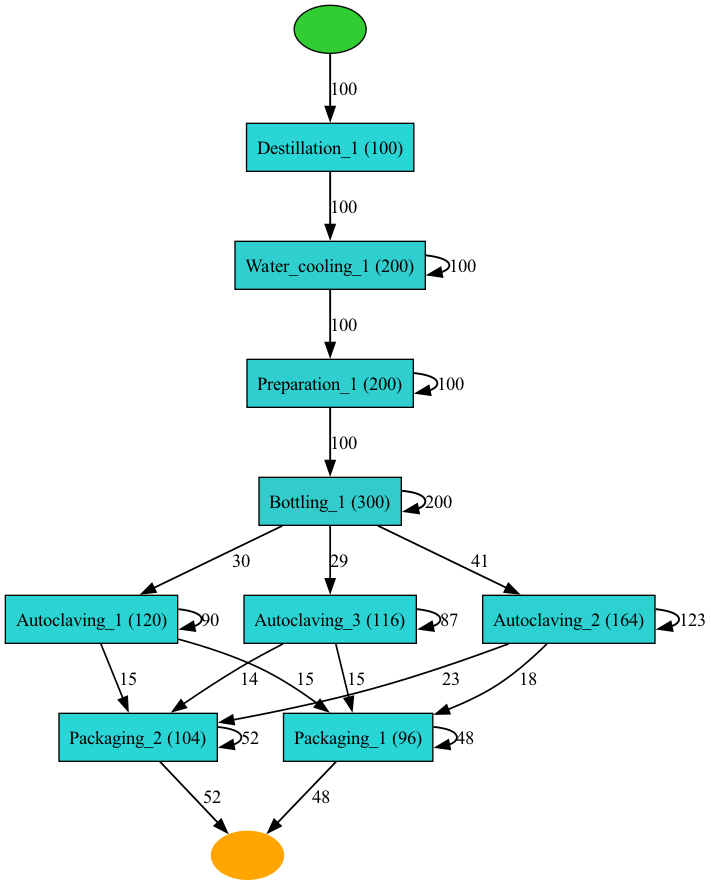


Visualizing Machine State Heuristic Net...


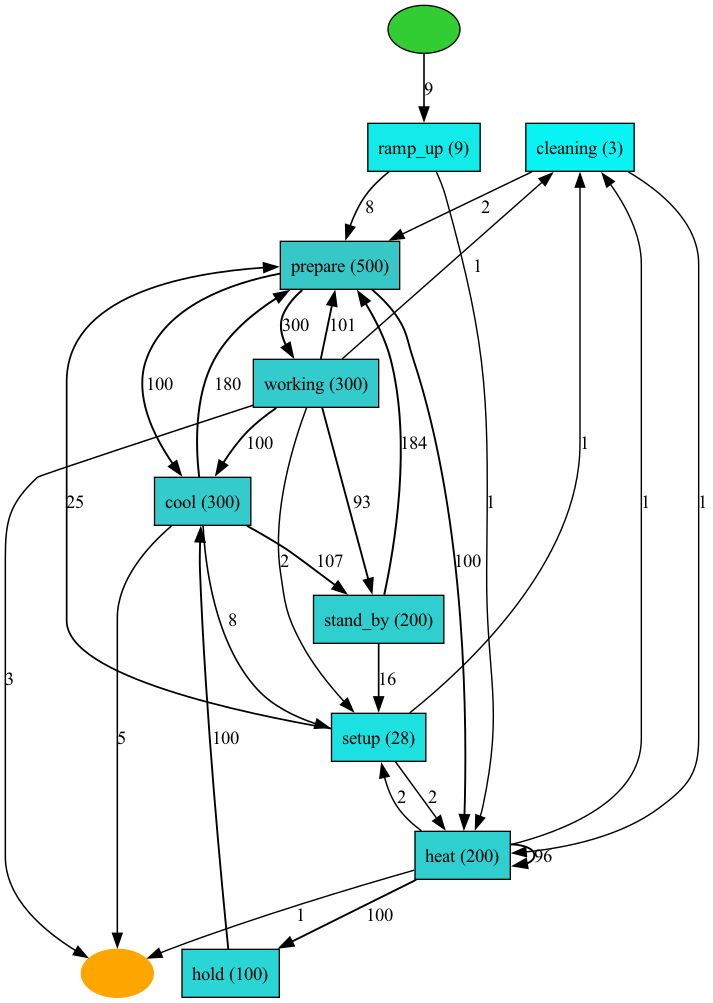

In [100]:

# Example: Create a small production plan for testing
import pandas as pd
from datetime import datetime

# Small test dataset
test_plan = pd.DataFrame({
    'case_id': range(1, 101),
    'order_id': [i // 20 + 1 for i in range(100)],
    'recipe': ['A'] * 30 + ['B'] * 30 + ['A'] * 20 + ['cleaning'] * 5 + ['C'] * 15,
    'volume': [800, 900, 1000] * 33 + [800],
    'downtime': [{}] * 100
})

# Run simulation
start_date = datetime(2024, 1, 1)
seed = 42

print("Running simulation...")
material_df, machine_df = run_simulation(
    test_plan, 
    process_config, 
    cleaning_config,
    seed, 
    start_date
)

# print(f"\n{'='*60}")
# print("MATERIAL FLOW EVENT LOG")
# print(f"{'='*60}")
# print(f"Total events: {len(material_df)}")
# print(f"Unique products (case_ids): {material_df['case_id'].nunique()}")
# print(f"\nFirst 10 events:")
# print(material_df[['timestamp_start', 'timestamp_end', 'process', 'event_type', 
#                 'resource', 'case_id', 'recipe_name', 'volume']].head(10))

# print(f"\n{'='*60}")
# print("MACHINE STATE EVENT LOG")
# print(f"{'='*60}")
# print(f"Total state changes: {len(machine_df)}")
# print(f"Unique machines: {machine_df['machine_id'].nunique()}")
# print(f"\nMachine states breakdown:")
# print(machine_df['machine_state'].value_counts())
# print(f"\nFirst 10 machine state changes:")
# print(machine_df[['timestamp_start', 'timestamp_end', 'process', 'machine_state', 
#                 'machine_id', 'linked_case_id', 'recipe_name']].head(10))

# Try to import pm4py for visualization
try:
    import pm4py
    
    # Format material flow log
    material_log = pm4py.format_dataframe(
        material_df, 
        case_id='case_id', 
        activity_key='resource', 
        timestamp_key='timestamp_start'
    )
    
    # Format machine state log
    machine_log = pm4py.format_dataframe(
        machine_df, 
        case_id='machine_id', 
        activity_key='machine_state', 
        timestamp_key='timestamp_start'
    )
    
    print("\n" + "="*60)
    print("Discovering process models...")
    print("="*60)
    
    # Discover heuristic nets
    material_net = pm4py.discover_heuristics_net(material_log)
    machine_net = pm4py.discover_heuristics_net(machine_log)
    
    print("\nVisualizing Material Flow Heuristic Net...")
    pm4py.view_heuristics_net(material_net, bgcolor='white')
    
    print("\nVisualizing Machine State Heuristic Net...")
    pm4py.view_heuristics_net(machine_net, bgcolor='white')
    
except ImportError:
    print("\npm4py not available - skipping process mining visualization")
except Exception as e:
    print(f"\nError during visualization: {e}")

Running corrected simulation...
Material events: 500
Machine state events: 1328
Adjacent-equal resource pairs across all cases: 0 (should be 0)

First 10 material-flow events:
                timestamp_start                 timestamp_end        process  \
0 2024-01-01 07:00:00.000000000 2024-01-01 07:09:59.064194203   Destillation   
1 2024-01-01 07:09:59.064194203 2024-01-01 07:15:02.243803457  Water_cooling   
2 2024-01-01 07:15:02.243803457 2024-01-01 07:27:07.916355227       Bottling   
3 2024-01-01 07:27:07.916355227 2024-01-01 08:44:10.830879965    Autoclaving   
4 2024-01-01 08:44:10.830879965 2024-01-01 09:00:04.765188358      Packaging   
5 2024-01-01 07:09:59.064194203 2024-01-01 07:09:59.609281849   Destillation   
6 2024-01-01 07:15:02.243803457 2024-01-01 07:15:03.371056253  Water_cooling   
7 2024-01-01 07:27:07.916355227 2024-01-01 07:27:08.641718929       Bottling   
8 2024-01-01 08:44:10.830879965 2024-01-01 09:45:57.322297438    Autoclaving   
9 2024-01-01 09:45:57.32

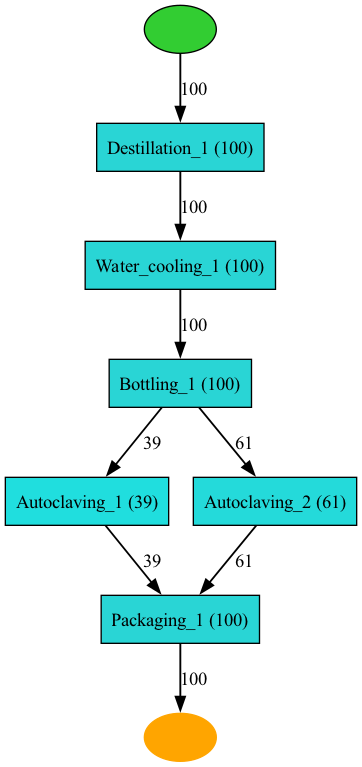


pm4py found: you can use discover_heuristics_net(...) on the material flow df (formatted).


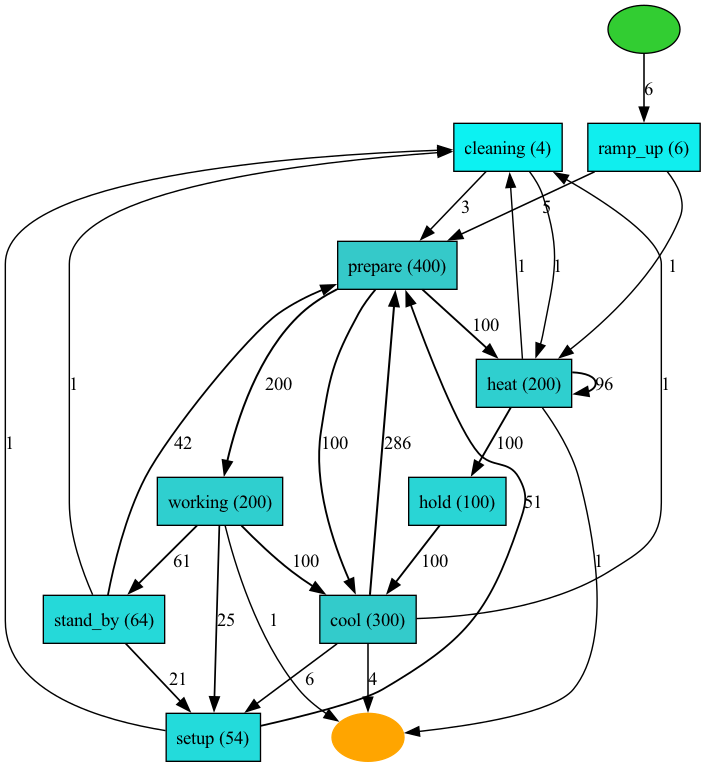

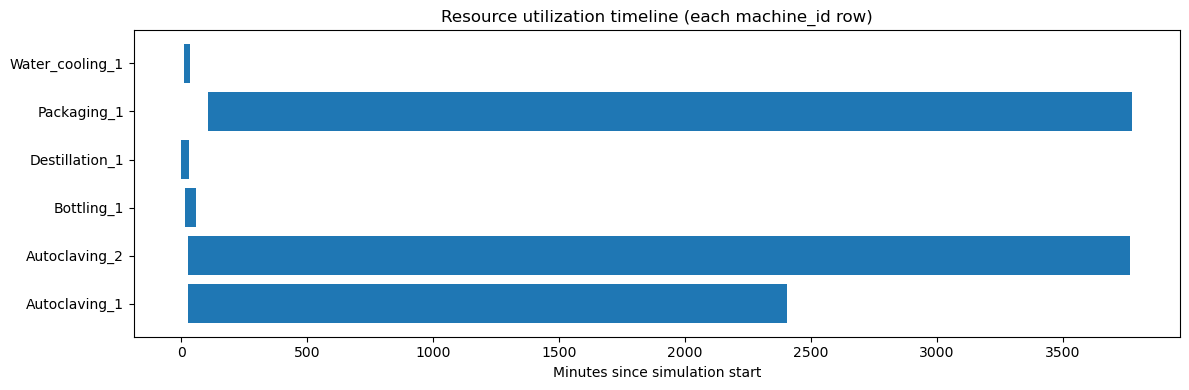


Done. material_df and machine_df are returned by run_simulation() for further analysis.


In [101]:
"""
Corrected production simulation:
- Material flow: only product movements between resources (ONE event per process per case).
- Machine state log: internal machine states only.
- Postprocessing sorts events to avoid loops/time-travel for process mining.

Requirements:
pip install simpy pandas matplotlib networkx
pm4py optional for heuristic nets.

Save as corrected_sim.py and run.
"""

import random
import pandas as pd
import simpy
from datetime import datetime
import matplotlib.pyplot as plt
import math

class ProductionProcess:
    def __init__(self, env, material_flow_log, machine_state_log, seed, process_config, cleaning_config):
        self.env = env
        self.material_flow_log = material_flow_log
        self.machine_state_log = machine_state_log
        self.process_config = process_config
        self.cleaning_config = cleaning_config

        # resources per process (list of simpy.Resource objects)
        self.resources = {
            process_name: [simpy.Resource(env, capacity=1) for _ in range(config["num_resources"])]
            for process_name, config in process_config.items()
        }

        # machine tracking
        self.machine_states = {}
        self.machine_pallet_counters = {}
        self.machine_last_recipe = {}
        self.machine_ramped_up = {}
        self.machine_last_activity_end = {}

        for process_name, config in process_config.items():
            for station_id in range(config["num_resources"]):
                key = f"{process_name}_{station_id}"
                self.machine_states[key] = "initial"
                self.machine_pallet_counters[key] = 0
                self.machine_last_recipe[key] = None
                self.machine_ramped_up[key] = False
                self.machine_last_activity_end[key] = 0

        random.seed(seed)

    # --- Logging helpers ---
    def log_material_event(self, timestamp_start, timestamp_end, process, resource, case_id, recipe_name, volume):
        """Material-flow log: ONE event for the product in that resource (process step)."""
        event = {
            "timestamp_start": timestamp_start,
            "timestamp_end": timestamp_end,
            "process": process,
            "resource": resource,
            "case_id": case_id,
            "recipe_name": recipe_name,
            "volume": volume,
            "log_type": "material_flow"
        }
        self.material_flow_log.append(event)

    def log_machine_state(self, timestamp_start, timestamp_end, process, state, resource, state_metadata,
                          linked_case_id=None, recipe_name=None):
        """Machine-state log: internal states inside the machine."""
        event = {
            "timestamp_start": timestamp_start,
            "timestamp_end": timestamp_end,
            "process": process,
            "machine_state": state,
            "resource": resource,
            "machine_id": resource,
            "linked_case_id": linked_case_id,
            "recipe_name": recipe_name,
            "has_product": state_metadata.get("has_product", False),
            "log_type": "machine_state"
        }
        self.machine_state_log.append(event)

    def log_standby_if_needed(self, process_name, station_id):
        """If there was idle time since last activity, log stand_by in machine-state log (not material)."""
        machine_key = f"{process_name}_{station_id}"
        last_end = self.machine_last_activity_end[machine_key]
        current_time = self.env.now
        if current_time > last_end and self.machine_states[machine_key] not in ["initial"]:
            self.log_machine_state(last_end, current_time, process_name, "stand_by",
                                   f"{process_name}_{station_id+1}",
                                   {"has_product": False})

    # --- Internal machine state execution ---
    def execute_machine_state(self, process_name, station_id, state_name, state_config,
                              case_id=None, recipe_name=None, volume=None):
        """
        Execute one internal state. THIS DOES NOT LOG MATERIAL MOVEMENT.
        Only logs to machine_state_log (internal state).
        """
        machine_key = f"{process_name}_{station_id}"

        # choose recipe key (explicit recipe if available else standard)
        recipe_key = recipe_name if recipe_name in state_config.get("recipes", {}) else "standard"
        recipe_config = state_config["recipes"].get(recipe_key) or state_config["recipes"].get("standard")
        if recipe_config is None:
            raise ValueError(f"Missing recipe for state {state_name} in {process_name}")

        base_dur = float(recipe_config["duration"])
        variability = float(recipe_config.get("variability", 0.0))
        scaled_variability = abs(base_dur) * variability
        duration = random.uniform(base_dur - scaled_variability, base_dur + scaled_variability)

        # volume scaling: interpret very small base durations as "per 1000 units"
        if state_config.get("volume_affected", False) and volume is not None:
            if base_dur < 1.0:
                duration = duration * (volume / 1000.0)
            else:
                duration = duration * volume

        timestamp_start = self.env.now
        yield self.env.timeout(duration)
        timestamp_end = self.env.now

        # update machine trackers
        self.machine_states[machine_key] = state_name
        self.machine_last_activity_end[machine_key] = timestamp_end

        # log the internal machine state
        self.log_machine_state(timestamp_start, timestamp_end, process_name, state_name,
                               f"{process_name}_{station_id+1}", state_config,
                               linked_case_id=(case_id if state_config.get("has_product", False) else None),
                               recipe_name=recipe_name)

    # --- Maintenance helpers ---
    def needs_cleaning(self, process_name, station_id):
        machine_key = f"{process_name}_{station_id}"
        threshold = self.cleaning_config.get(process_name, {}).get("pallets_before_cleaning", float('inf'))
        return self.machine_pallet_counters[machine_key] >= threshold

    def needs_setup(self, process_name, station_id, recipe_name):
        machine_key = f"{process_name}_{station_id}"
        last = self.machine_last_recipe[machine_key]
        if last is None or last == recipe_name:
            return False
        if last == "cleaning" or recipe_name == "cleaning":
            return False
        return True

    # --- Process execution (one process step per case) ---
    def execute_process(self, process_name, plan):
        """
        Acquire the resource, run all internal machine states (logged to machine_state_log),
        and produce ONE material_flow event (start->end on the resource) for the product.
        """
        config = self.process_config[process_name]
        station_id = random.randint(0, len(self.resources[process_name]) - 1)
        machine_key = f"{process_name}_{station_id}"

        recipe_name = plan.get("recipe", plan.get("recipe_name", "standard"))
        volume = plan.get("volume", 1000)
        case_id = plan["case_id"]

        with self.resources[process_name][station_id].request() as req:
            yield req

            # Log stand-by if idle since last activity (machine-state)
            self.log_standby_if_needed(process_name, station_id)

            # We log material start when the product is acquired / starts being processed
            material_start = self.env.now

            # === RAMP-UP (only first time machine used) ===
            if not self.machine_ramped_up[machine_key]:
                ramp_up_duration = self.cleaning_config.get(process_name, {}).get("ramp_up_duration", 5)
                ramp_up_cfg = {"has_product": False, "recipes": {"standard": {"duration": ramp_up_duration, "variability": 0.01}}}
                yield self.env.process(self.execute_machine_state(process_name, station_id, "ramp_up", ramp_up_cfg))
                self.machine_ramped_up[machine_key] = True

            # === SETUP/CHANGEOVER (if recipe changed) ===
            if self.needs_setup(process_name, station_id, recipe_name):
                setup_duration = self.cleaning_config.get(process_name, {}).get("setup_duration", 3)
                setup_cfg = {"has_product": False, "recipes": {"standard": {"duration": setup_duration, "variability": 0.02}}}
                yield self.env.process(self.execute_machine_state(process_name, station_id, "setup", setup_cfg, case_id, recipe_name, None))

            # === CLEANING (if threshold reached) ===
            if self.needs_cleaning(process_name, station_id) and recipe_name != "cleaning":
                cleaning_duration = self.cleaning_config.get(process_name, {}).get("cleaning_duration", 10)
                cleaning_cfg = {"has_product": False, "recipes": {"cleaning": {"duration": cleaning_duration, "variability": 0.02}}}
                yield self.env.process(self.execute_machine_state(process_name, station_id, "cleaning", cleaning_cfg, None, "cleaning", None))
                self.machine_pallet_counters[machine_key] = 0

            # === EXECUTE INTERNAL MACHINE STATES (all logged to machine_state_log) ===
            for state in config["machine_states"]:
                yield self.env.process(self.execute_machine_state(process_name, station_id, state["name"], state, case_id, recipe_name, volume))

            # When leaving the resource, capture end time and append ONE material_flow event.
            material_end = self.env.now
            # resource name uses 1-based index for readability
            resource_label = f"{process_name}_{station_id+1}"
            self.log_material_event(material_start, material_end, process_name, resource_label, case_id, recipe_name, volume)

            # Update counters and last recipe
            if recipe_name != "cleaning":
                self.machine_pallet_counters[machine_key] += 1
            self.machine_last_recipe[machine_key] = recipe_name

    def process(self, plan):
        """Run process steps in deterministic order for the case."""
        for process_name in list(self.process_config.keys()):
            yield self.env.process(self.execute_process(process_name, plan))


def run_simulation(production_plan, process_config, cleaning_config, seed, start_date):
    """Run sim and return processed material & machine state dataframes."""
    material_flow_log = []
    machine_state_log = []
    env = simpy.Environment()
    sim = ProductionProcess(env, material_flow_log, machine_state_log, seed, process_config, cleaning_config)

    # iterate rows: each row => one case path
    for _, row in production_plan.iterrows():
        plan = row.to_dict()
        env.process(sim.process(plan))

    env.run()

    # --- material flow DF ---
    material_df = pd.DataFrame(material_flow_log)
    if not material_df.empty:
        material_df["date"] = pd.to_datetime(start_date)
        material_df["timestamp_start"] = material_df.apply(
            lambda r: r["date"].replace(hour=7, minute=0) + pd.Timedelta(minutes=r["timestamp_start"]), axis=1)
        material_df["timestamp_end"] = material_df.apply(
            lambda r: r["date"].replace(hour=7, minute=0) + pd.Timedelta(minutes=r["timestamp_end"]), axis=1)
        material_df["event_type"] = material_df["log_type"]
        # Sort by case & start time so sequences are consistent for process mining
        material_df = material_df.sort_values(["case_id", "timestamp_start", "timestamp_end"]).reset_index(drop=True)
        material_df["date"] = material_df["timestamp_start"].dt.date

    # --- machine state DF ---
    machine_df = pd.DataFrame(machine_state_log)
    if not machine_df.empty:
        machine_df["date"] = pd.to_datetime(start_date)
        machine_df["timestamp_start"] = machine_df.apply(
            lambda r: r["date"].replace(hour=7, minute=0) + pd.Timedelta(minutes=r["timestamp_start"]), axis=1)
        machine_df["timestamp_end"] = machine_df.apply(
            lambda r: r["date"].replace(hour=7, minute=0) + pd.Timedelta(minutes=r["timestamp_end"]), axis=1)
        machine_df["event_type"] = machine_df["log_type"]
        machine_df = machine_df.sort_values(["machine_id", "timestamp_start", "timestamp_end"]).reset_index(drop=True)
        machine_df["date"] = machine_df["timestamp_start"].dt.date

    return material_df, machine_df


# ----------------- Example configuration (same as yours) -----------------
process_config = {
    "Destillation": {
        "num_resources": 1,
        "machine_states": [
            {
                "name": "heat",
                "has_product": True,
                "volume_affected": True,
                "recipes": {
                    "standard": {"duration": 1/100, "variability": 0.01},
                    "cleaning": {"duration": 1/100, "variability": 0.01},
                },
            },
        ],
    },
    "Water_cooling": {
        "num_resources": 1,
        "machine_states": [
            {
                "name": "prepare",
                "has_product": True,
                "volume_affected": True,
                "recipes": {
                    "standard": {"duration": 1/1000, "variability": 0.01},
                    "cleaning": {"duration": 1/1000, "variability": 0.01},
                },
            },
            {
                "name": "cool",
                "has_product": True,
                "volume_affected": True,
                "recipes": {
                    "standard": {"duration": 1/50, "variability": 0.01},
                    "cleaning": {"duration": 1/50, "variability": 0.01},
                },
            },
        ],
    },
    # "Preparation": {
    #     "num_resources": 1,
    #     "machine_states": [
    #         {
    #             "name": "prepare",
    #             "has_product": True,
    #             "volume_affected": True,
    #             "recipes": {
    #                 "standard": {"duration": 1/1000, "variability": 0.01},
    #                 "cleaning": {"duration": 1/1000, "variability": 0.01},
    #             },
    #         },
    #         {
    #             "name": "working",
    #             "has_product": True,
    #             "volume_affected": True,
    #             "recipes": {
    #                 "standard": {"duration": 1/50, "variability": 0.01},
    #                 "cleaning": {"duration": 1/50, "variability": 0.01},
    #             },
    #         },
    #     ],
    # },
    "Bottling": {
        "num_resources": 1,
        "machine_states": [
            {
                "name": "prepare",
                "has_product": True,
                "volume_affected": True,
                "recipes": {
                    "standard": {"duration": 1/1000, "variability": 0.05},
                    "cleaning": {"duration": 1/1000, "variability": 0.05},
                },
            },
            {
                "name": "working",
                "has_product": True,
                "volume_affected": True,
                "recipes": {
                    "standard": {"duration": 1/90, "variability": 0.05},
                    "cleaning": {"duration": 1/90, "variability": 0.05},
                },
            },
            {
                "name": "cool",
                "has_product": True,
                "volume_affected": True,
                "recipes": {
                    "standard": {"duration": 1/1000, "variability": 0.05},
                    "cleaning": {"duration": 1/1000, "variability": 0.05},
                },
            }
        ],
    },
    "Autoclaving": {
        "num_resources": 2,
        "machine_states": [
            {
                "name": "prepare",
                "has_product": True,
                "volume_affected": False,
                "recipes": {
                    "standard": {"duration": 2, "variability": 0.02},
                    "cleaning": {"duration": 0, "variability": 0.02},
                },
            },
            {
                "name": "heat",
                "has_product": True,
                "volume_affected": False,
                "recipes": {
                    "standard": {"duration": 18.0, "variability": 0.02},
                    "cleaning": {"duration": 10.0, "variability": 0.02},
                },
            },
            {
                "name": "hold",
                "has_product": True,
                "volume_affected": False,
                "recipes": {
                    "standard": {"duration": 14.0, "variability": 0.02},
                    "cleaning": {"duration": 7.0, "variability": 0.02},
                },
            },
            {
                "name": "cool",
                "has_product": True,
                "volume_affected": False,
                "recipes": {
                    "standard": {"duration": 28.0, "variability": 0.02},
                    "cleaning": {"duration": 15.0, "variability": 0.02},
                },
            },
        ],
    },
    "Packaging": {
        "num_resources": 1,
        "machine_states": [
            {
                "name": "prepare",
                "has_product": True,
                "volume_affected": False,
                "recipes": {
                    "standard": {"duration": 5, "variability": 0.05},
                    "cleaning": {"duration": 0.001, "variability": 0.05},
                },
            },
            {
                "name": "working",
                "has_product": True,
                "volume_affected": False,
                "recipes": {
                    "standard": {"duration": 5, "variability": 0.05},
                    "cleaning": {"duration": 0.001, "variability": 0.05},
                },
            },
        ],
    },
}

cleaning_config = {
    "Destillation": {"pallets_before_cleaning": 50, "cleaning_duration": 15, "setup_duration": 3, "ramp_up_duration": 10},
    "Water_cooling": {"pallets_before_cleaning": 100, "cleaning_duration": 10, "setup_duration": 2, "ramp_up_duration": 5},
    "Preparation": {"pallets_before_cleaning": 75, "cleaning_duration": 12, "setup_duration": 3, "ramp_up_duration": 8},
    "Bottling": {"pallets_before_cleaning": 60, "cleaning_duration": 20, "setup_duration": 4, "ramp_up_duration": 12},
    "Autoclaving": {"pallets_before_cleaning": 40, "cleaning_duration": 25, "setup_duration": 5, "ramp_up_duration": 15},
    "Packaging": {"pallets_before_cleaning": 80, "cleaning_duration": 8, "setup_duration": 2, "ramp_up_duration": 6},
}


# ----------------- Example plan and run -----------------
if __name__ == "__main__":
    test_plan = pd.DataFrame({
        'case_id': range(1, 101),
        'order_id': [i // 20 + 1 for i in range(100)],
        'recipe': ['A'] * 30 + ['B'] * 30 + ['A'] * 20 + ['cleaning'] * 5 + ['C'] * 15,
        'volume': [800, 900, 1000] * 33 + [800],
        'downtime': [{}] * 100
    })

    start_date = datetime(2024, 1, 1)
    seed = 42

    print("Running corrected simulation...")
    material_df, machine_df = run_simulation(test_plan, process_config, cleaning_config, seed, start_date)

    print(f"Material events: {len(material_df) if material_df is not None else 0}")
    print(f"Machine state events: {len(machine_df) if machine_df is not None else 0}")

    # quick sanity checks
    if material_df is not None and not material_df.empty:
        # ensure for each case the resource sequence has no immediate duplicates
        dup_counts = 0
        for case, grp in material_df.groupby("case_id"):
            seq = list(grp["resource"])
            # count if any adjacent pair equal
            for a, b in zip(seq, seq[1:]):
                if a == b:
                    dup_counts += 1
        print(f"Adjacent-equal resource pairs across all cases: {dup_counts} (should be 0)")

        # show transitions and first few events
        print("\nFirst 10 material-flow events:")
        print(material_df[['timestamp_start', 'timestamp_end', 'process', 'resource', 'case_id', 'recipe_name', 'volume']].head(10))

    if machine_df is not None and not machine_df.empty:
        print("\nFirst 10 machine-state events:")
        print(machine_df[['timestamp_start', 'timestamp_end', 'process', 'machine_state', 'machine_id', 'linked_case_id', 'recipe_name']].head(10))

    # Build transitions (material)
    if material_df is not None and not material_df.empty:
        material_df = material_df.sort_values(["case_id", "timestamp_start"]).reset_index(drop=True)
        edges = {}
        for case, grp in material_df.groupby("case_id"):
            seq = list(grp["resource"])
            for a, b in zip(seq, seq[1:]):
                edges[(a, b)] = edges.get((a, b), 0) + 1
        edges_df = pd.DataFrame([{"from": k[0], "to": k[1], "count": v} for k, v in edges.items()]).sort_values("count", ascending=False)
        print("\nTop transitions (material flow):")
        print(edges_df.head(20))
    else:
        edges_df = pd.DataFrame()

    # Visualize fallback with networkx if pm4py not installed
    try:
        import pm4py
        print("\npm4py found: you can use discover_heuristics_net(...) on the material flow df (formatted).")
        mf_log = pm4py.format_dataframe(material_df, case_id='case_id', activity_key='resource', timestamp_key='timestamp_start')
        hn = pm4py.discover_heuristics_net(mf_log)
        pm4py.view_heuristics_net(hn, bgcolor='white')

        print("\npm4py found: you can use discover_heuristics_net(...) on the material flow df (formatted).")
        s_log = pm4py.format_dataframe(machine_df, case_id='machine_id', activity_key='machine_state', timestamp_key='timestamp_start')
        hn_state = pm4py.discover_heuristics_net(s_log)
        pm4py.view_heuristics_net(hn_state, bgcolor='white')
    except Exception:
        try:
            import networkx as nx
            G = nx.DiGraph()
            for (u, v), w in edges.items():
                G.add_edge(u, v, weight=w)
            plt.figure(figsize=(10, 6))
            pos = nx.spring_layout(G, seed=1)
            widths = [math.log(1 + G[u][v]["weight"]) for u, v in G.edges()]
            nx.draw_networkx_nodes(G, pos, node_size=1200)
            nx.draw_networkx_labels(G, pos)
            nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=12, width=widths)
            edge_labels = {(u, v): G[u][v]["weight"] for u, v in G.edges()}
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
            plt.title("Material flow transition graph (counts on edges)")
            plt.axis('off')
            plt.show()
        except Exception:
            print("Network visualization not available; inspect edges_df printed above.")

    # Resource utilization (simple Gantt-like) from machine_df
    if machine_df is not None and not machine_df.empty:
        md = machine_df.copy()
        sim_start = md["timestamp_start"].min()
        md["start_min"] = (md["timestamp_start"] - sim_start).dt.total_seconds() / 60.0
        md["end_min"] = (md["timestamp_end"] - sim_start).dt.total_seconds() / 60.0
        machine_ids = sorted(md["machine_id"].unique())
        idx_map = {m: i for i, m in enumerate(machine_ids)}
        fig, ax = plt.subplots(figsize=(12, max(4, len(machine_ids)*0.5)))
        for _, r in md.iterrows():
            y = idx_map[r["machine_id"]]
            ax.broken_barh([(r["start_min"], max(0.01, r["end_min"] - r["start_min"]))], (y - 0.4, 0.8))
        ax.set_yticks(list(idx_map.values()))
        ax.set_yticklabels(list(idx_map.keys()))
        ax.set_xlabel("Minutes since simulation start")
        ax.set_title("Resource utilization timeline (each machine_id row)")
        plt.tight_layout()
        plt.show()

    print("\nDone. material_df and machine_df are returned by run_simulation() for further analysis.")

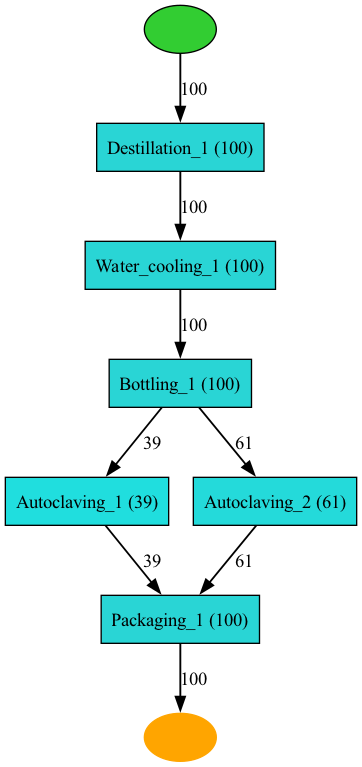

In [102]:
import pm4py
import pandas as pd

df = material_df.copy()

event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='resource', timestamp_key='timestamp_start')

# Discover the Heuristic Net
net = pm4py.discover_heuristics_net(event_log)

# pm4py.save_vis_heuristics_net(net, 'heuristic_net.pdf', bgcolor='white')

# View the Heuristic Net
pm4py.view_heuristics_net(net, bgcolor='white')

Found 6 unique machines
Added machine: Autoclaving_1 at position (0, 2)
Added machine: Autoclaving_2 at position (0, 3)
Added machine: Bottling_1 at position (1, 2)
Added machine: Destillation_1 at position (1, 3)
Added machine: Packaging_1 at position (2, 2)
Added machine: Water_cooling_1 at position (2, 3)


/var/folders/j7/bzg541gd7dg10j_2qvx3s4j00000gn/T/ipykernel_55665/2353472936.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Combined figure saved to: visuals/heuristics_nets_combined.pdf


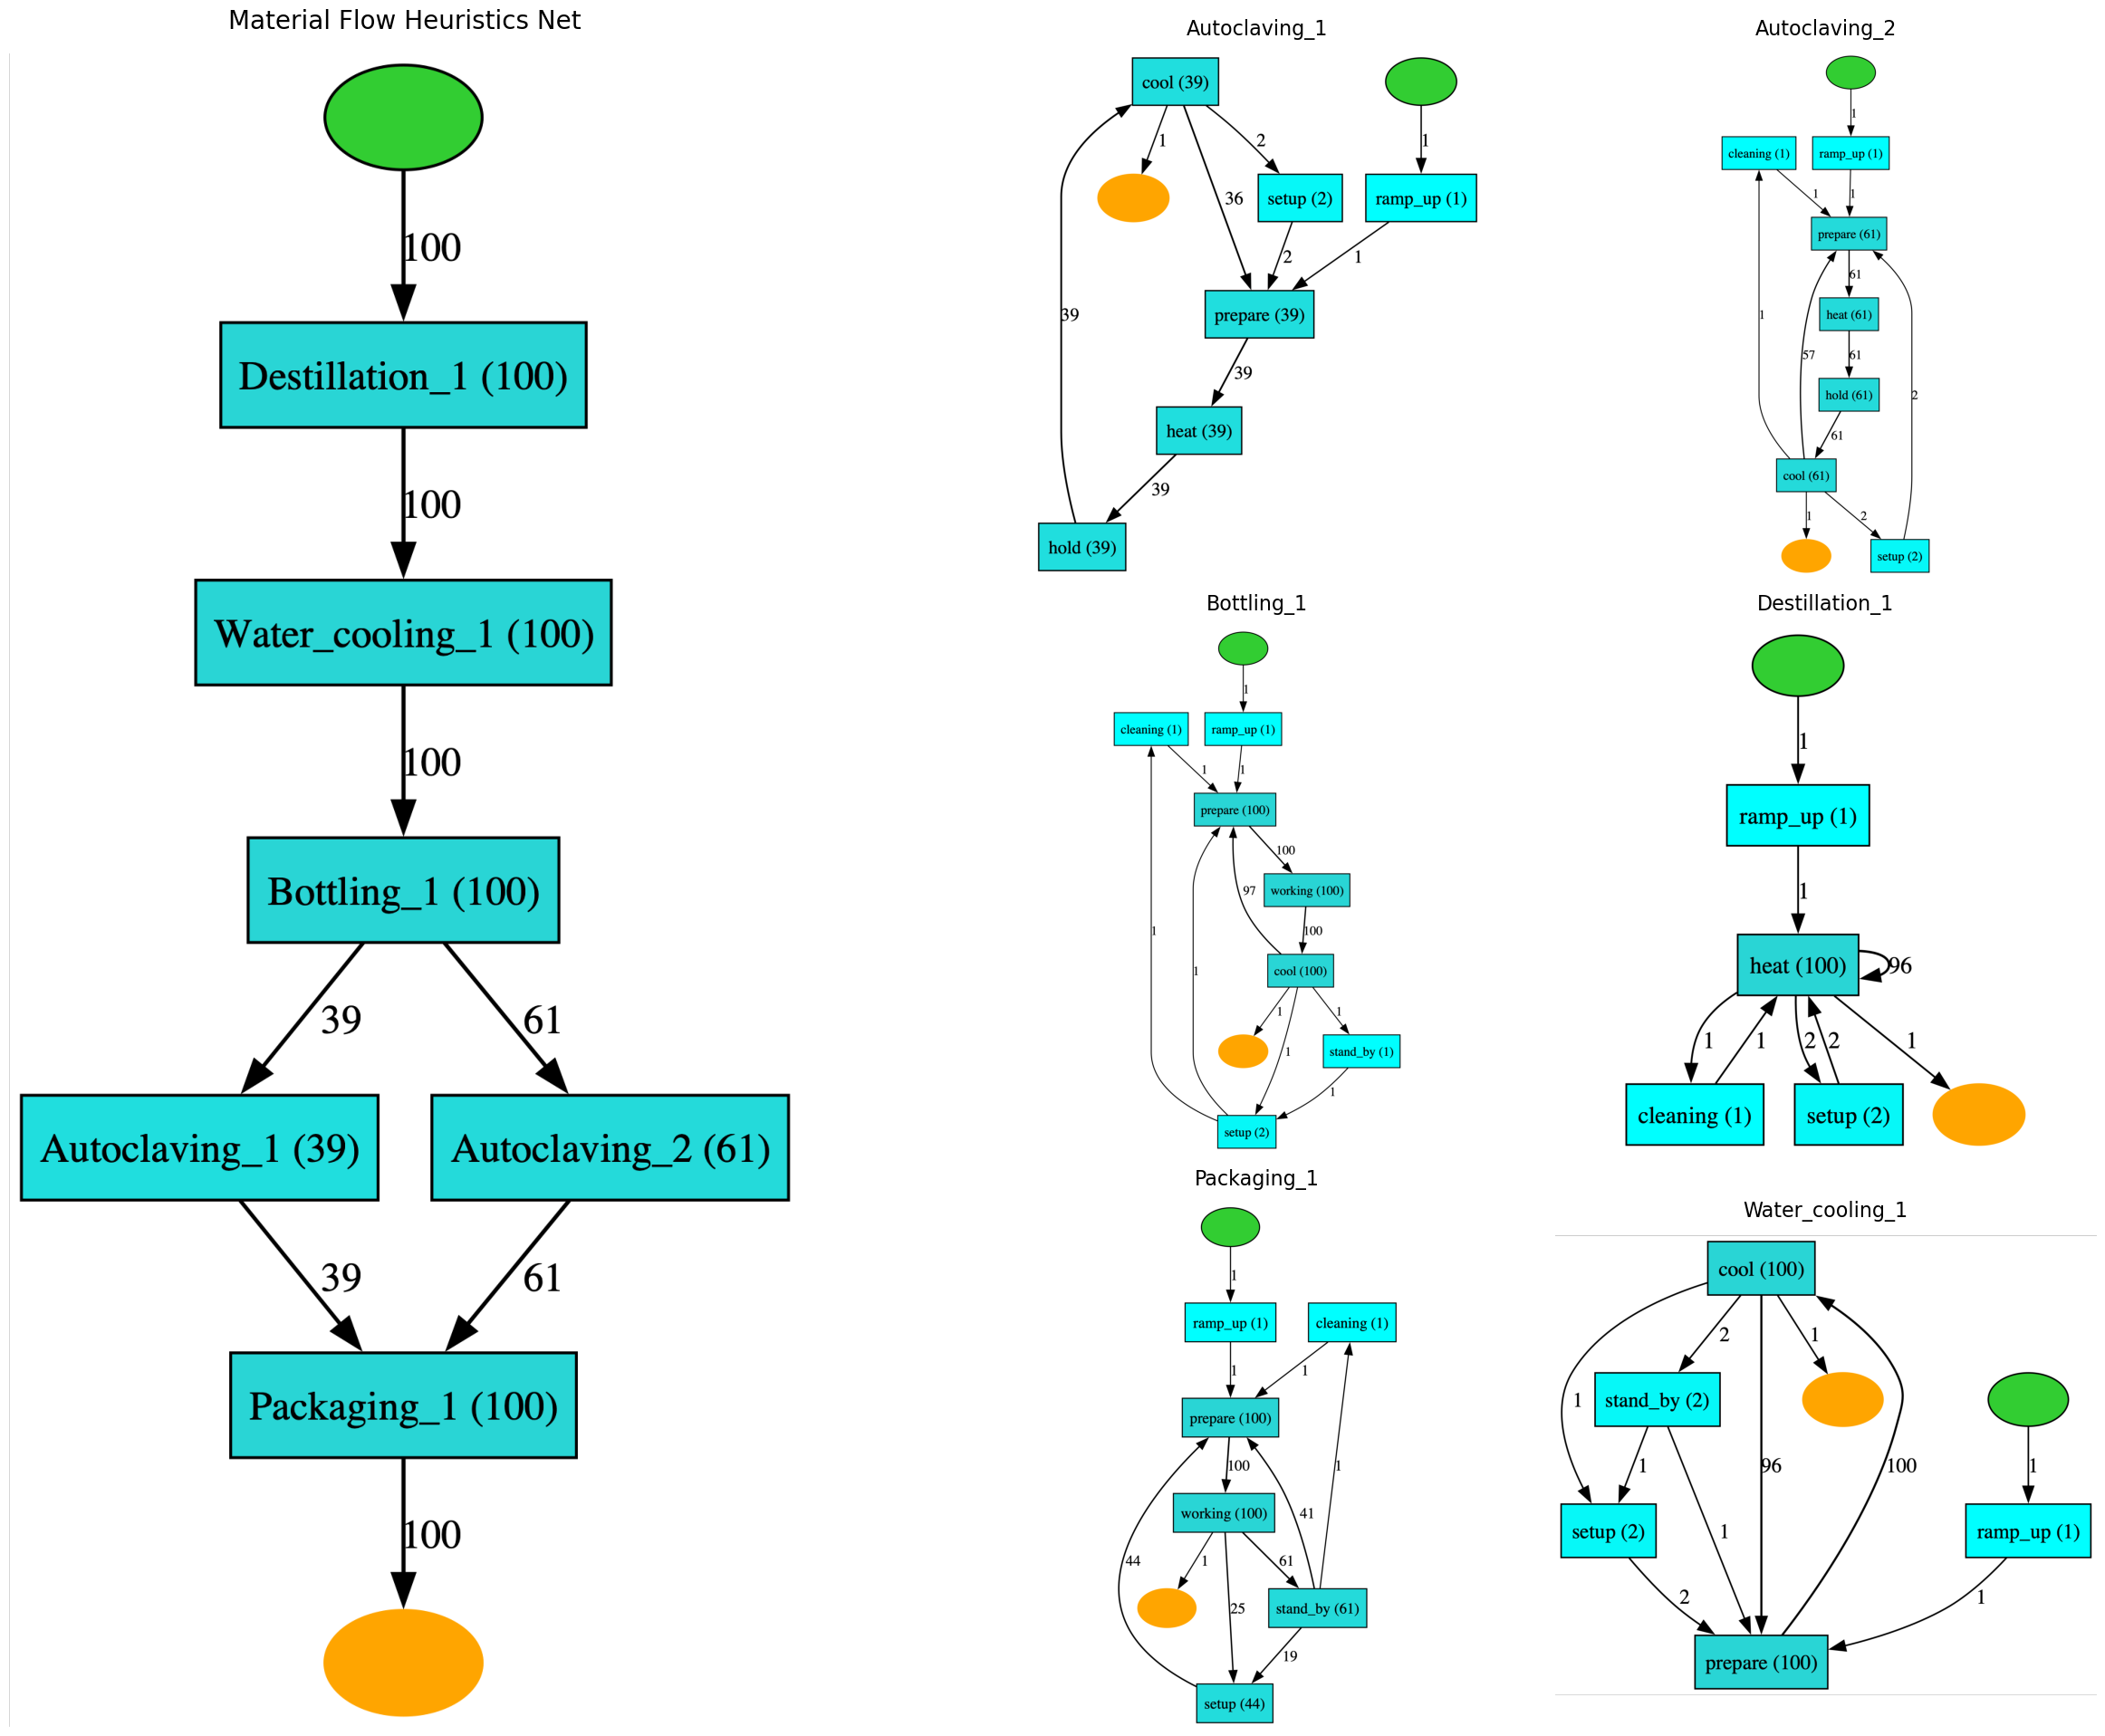

In [103]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from PIL import Image
import os

# Get unique machine IDs
df_machine = machine_df.copy()
unique_machines = df_machine['machine_id'].unique()

print(f"Found {len(unique_machines)} unique machines")

# Create output directory if it doesn't exist
output_dir = 'visuals/'
os.makedirs(output_dir, exist_ok=True)

# Create material flow event log (LEFT SIDE)
df_material = material_df.copy()
event_log_material = pm4py.format_dataframe(
    df_material, 
    case_id='case_id', 
    activity_key='resource', 
    timestamp_key='timestamp_start'
)
net_material = pm4py.discover_heuristics_net(event_log_material)

# Generate material flow visualization as SVG (vector format for quality)
gviz_material_svg = pm4py.visualization.heuristics_net.visualizer.apply(
    net_material, 
    parameters={"format": "svg", "bgcolor": "white"}
)

# Read SVG and convert to display in matplotlib
from cairosvg import svg2png
from io import BytesIO

with open(gviz_material_svg.name, 'rb') as f:
    svg_data = f.read()

png_data = svg2png(bytestring=svg_data, dpi=300)
img_material = Image.open(BytesIO(png_data))

# Create figure with GridSpec (3 rows, 4 columns: 2 for material + 2 for machines)
fig = plt.figure(figsize=(32, 24))
gs = GridSpec(3, 4, figure=fig, wspace=0.05, hspace=0.1)

# Left subplot - Material Flow (spans all 3 rows and 2 columns)
ax_material = fig.add_subplot(gs[:, 0:2])
ax_material.imshow(img_material)
ax_material.set_title('Material Flow Heuristics Net', fontsize=20, pad=20)
ax_material.axis('off')

# Right side - Machine state nets in 3x2 grid
for idx, machine_id in enumerate(unique_machines[:6]):  # Only 6 machines for 3x2 grid
    row = idx // 2  # Changed from // 3
    col = (idx % 2) + 2  # Changed from % 3
    
    # Filter data for this specific machine
    df_single_machine = df_machine[df_machine['machine_id'] == machine_id].copy()
    
    # Create event log for this machine
    event_log_machine = pm4py.format_dataframe(
        df_single_machine, 
        case_id='machine_id', 
        activity_key='machine_state', 
        timestamp_key='timestamp_start'
    )
    
    # Discover the heuristics net
    net_machine = pm4py.discover_heuristics_net(event_log_machine)
    
    # Generate visualization as SVG (vector format)
    gviz_machine_svg = pm4py.visualization.heuristics_net.visualizer.apply(
        net_machine, 
        parameters={"format": "svg", "bgcolor": "white"}
    )
    
    # Convert SVG to high-res PNG for matplotlib
    with open(gviz_machine_svg.name, 'rb') as f:
        svg_machine_data = f.read()
    
    png_machine_data = svg2png(bytestring=svg_machine_data, dpi=300)
    img_machine = Image.open(BytesIO(png_machine_data))
    
    # Add subplot for this machine
    ax_machine = fig.add_subplot(gs[row, col])
    ax_machine.imshow(img_machine)
    ax_machine.set_title(f'{machine_id}', fontsize=16, pad=15)
    ax_machine.axis('off')
    
    print(f"Added machine: {machine_id} at position ({row}, {col})")

plt.tight_layout()

# Save combined figure as PDF (vector format - scales without blur)
output_path = os.path.join(output_dir, 'heuristics_nets_combined.pdf')
plt.savefig(output_path, format='pdf', bbox_inches='tight')
print(f"Combined figure saved to: {output_path}")

plt.show()

In [104]:
df_single_machine = df_machine[df_machine['machine_id'] == 'Autoclaving_1'].copy()

# Create event log for this machine
event_log_machine = pm4py.format_dataframe(
    df_single_machine, 
    case_id='machine_id', 
    activity_key='machine_state', 
    timestamp_key='timestamp_start'
)

event_log_machine

,timestamp_start,timestamp_end,process,machine_state,resource,machine_id,linked_case_id,recipe_name,has_product,log_type,date,event_type,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
0,2024-01-01 07:27:07.916355227+00:00,2024-01-01 07:42:05.138723237+00:00,Autoclaving,ramp_up,Autoclaving_1,Autoclaving_1,NaN,None,False,machine_state,2024-01-01 00:00:00+00:00,machine_state,Autoclaving_1,ramp_up,2024-01-01 07:27:07.916355227+00:00,0,0
1,2024-01-01 07:42:05.138723237+00:00,2024-01-01 07:44:06.490044635+00:00,Autoclaving,prepare,Autoclaving_1,Autoclaving_1,1.0,A,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,Autoclaving_1,prepare,2024-01-01 07:42:05.138723237+00:00,1,0
2,2024-01-01 07:44:06.490044635+00:00,2024-01-01 08:02:11.814850738+00:00,Autoclaving,heat,Autoclaving_1,Autoclaving_1,1.0,A,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,Autoclaving_1,heat,2024-01-01 07:44:06.490044635+00:00,2,0
3,2024-01-01 08:02:11.814850738+00:00,2024-01-01 08:15:58.353166125+00:00,Autoclaving,hold,Autoclaving_1,Autoclaving_1,1.0,A,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,Autoclaving_1,hold,2024-01-01 08:02:11.814850738+00:00,3,0
4,2024-01-01 08:15:58.353166125+00:00,2024-01-01 08:44:10.830879965+00:00,Autoclaving,cool,Autoclaving_1,Autoclaving_1,1.0,A,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,Autoclaving_1,cool,2024-01-01 08:15:58.353166125+00:00,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2024-01-02 21:37:14.004031983+00:00,2024-01-02 22:05:07.160382691+00:00,Autoclaving,cool,Autoclaving_1,Autoclaving_1,98.0,C,True,machine_state,2024-01-02 00:00:00+00:00,machine_state,Autoclaving_1,cool,2024-01-02 21:37:14.004031983+00:00,154,0
155,2024-01-02 22:05:07.160382691+00:00,2024-01-02 22:07:07.283721834+00:00,Autoclaving,prepare,Autoclaving_1,Autoclaving_1,100.0,C,True,machine_state,2024-01-02 00:00:00+00:00,machine_state,Autoclaving_1,prepare,2024-01-02 22:05:07.160382691+00:00,155,0
156,2024-01-02 22:07:07.283721834+00:00,2024-01-02 22:24:59.379317198+00:00,Autoclaving,heat,Autoclaving_1,Autoclaving_1,100.0,C,True,machine_state,2024-01-02 00:00:00+00:00,machine_state,Autoclaving_1,heat,2024-01-02 22:07:07.283721834+00:00,156,0
157,2024-01-02 22:24:59.379317198+00:00,2024-01-02 22:39:01.103112903+00:00,Autoclaving,hold,Autoclaving_1,Autoclaving_1,100.0,C,True,machine_state,2024-01-02 00:00:00+00:00,machine_state,Autoclaving_1,hold,2024-01-02 22:24:59.379317198+00:00,157,0


In [ ]:
import pm4py
import pandas as pd

df = df_machine.copy()

df = df[df['machine_id'] == 'Autoclaving_1']


df = df

print(df['linked_case_id'].nunique())

df 

39


,timestamp_start,timestamp_end,process,machine_state,resource,machine_id,linked_case_id,recipe_name,has_product,log_type,date,event_type,case:concept:name,concept:name,time:timestamp
0,2024-01-01 07:27:07.916355227+00:00,2024-01-01 07:42:05.138723237+00:00,Autoclaving,ramp_up,Autoclaving_1,Autoclaving_1,NaN,None,False,machine_state,2024-01-01 00:00:00+00:00,machine_state,Autoclaving_1,ramp_up,2024-01-01 07:27:07.916355227+00:00
1,2024-01-01 07:42:05.138723237+00:00,2024-01-01 07:44:06.490044635+00:00,Autoclaving,prepare,Autoclaving_1,Autoclaving_1,1.0,A,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,Autoclaving_1,prepare,2024-01-01 07:42:05.138723237+00:00
2,2024-01-01 07:44:06.490044635+00:00,2024-01-01 08:02:11.814850738+00:00,Autoclaving,heat,Autoclaving_1,Autoclaving_1,1.0,A,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,Autoclaving_1,heat,2024-01-01 07:44:06.490044635+00:00
3,2024-01-01 08:02:11.814850738+00:00,2024-01-01 08:15:58.353166125+00:00,Autoclaving,hold,Autoclaving_1,Autoclaving_1,1.0,A,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,Autoclaving_1,hold,2024-01-01 08:02:11.814850738+00:00
4,2024-01-01 08:15:58.353166125+00:00,2024-01-01 08:44:10.830879965+00:00,Autoclaving,cool,Autoclaving_1,Autoclaving_1,1.0,A,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,Autoclaving_1,cool,2024-01-01 08:15:58.353166125+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2024-01-02 21:37:14.004031983+00:00,2024-01-02 22:05:07.160382691+00:00,Autoclaving,cool,Autoclaving_1,Autoclaving_1,98.0,C,True,machine_state,2024-01-02 00:00:00+00:00,machine_state,Autoclaving_1,cool,2024-01-02 21:37:14.004031983+00:00
155,2024-01-02 22:05:07.160382691+00:00,2024-01-02 22:07:07.283721834+00:00,Autoclaving,prepare,Autoclaving_1,Autoclaving_1,100.0,C,True,machine_state,2024-01-02 00:00:00+00:00,machine_state,Autoclaving_1,prepare,2024-01-02 22:05:07.160382691+00:00
156,2024-01-02 22:07:07.283721834+00:00,2024-01-02 22:24:59.379317198+00:00,Autoclaving,heat,Autoclaving_1,Autoclaving_1,100.0,C,True,machine_state,2024-01-02 00:00:00+00:00,machine_state,Autoclaving_1,heat,2024-01-02 22:07:07.283721834+00:00
157,2024-01-02 22:24:59.379317198+00:00,2024-01-02 22:39:01.103112903+00:00,Autoclaving,hold,Autoclaving_1,Autoclaving_1,100.0,C,True,machine_state,2024-01-02 00:00:00+00:00,machine_state,Autoclaving_1,hold,2024-01-02 22:24:59.379317198+00:00


In [108]:
df

,timestamp_start,timestamp_end,process,machine_state,resource,machine_id,linked_case_id,recipe_name,has_product,log_type,date,event_type,case:concept:name,concept:name,time:timestamp
0,2024-01-01 07:27:07.916355227+00:00,2024-01-01 07:42:05.138723237+00:00,Autoclaving,ramp_up,Autoclaving_1,0,NaN,None,False,machine_state,2024-01-01 00:00:00+00:00,machine_state,0,ramp_up,2024-01-01 07:27:07.916355227+00:00
1,2024-01-01 07:42:05.138723237+00:00,2024-01-01 07:44:06.490044635+00:00,Autoclaving,prepare,Autoclaving_1,1,1.0,A,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,1,prepare,2024-01-01 07:42:05.138723237+00:00
2,2024-01-01 07:44:06.490044635+00:00,2024-01-01 08:02:11.814850738+00:00,Autoclaving,heat,Autoclaving_1,2,1.0,A,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,2,heat,2024-01-01 07:44:06.490044635+00:00
3,2024-01-01 08:02:11.814850738+00:00,2024-01-01 08:15:58.353166125+00:00,Autoclaving,hold,Autoclaving_1,3,1.0,A,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,3,hold,2024-01-01 08:02:11.814850738+00:00
4,2024-01-01 08:15:58.353166125+00:00,2024-01-01 08:44:10.830879965+00:00,Autoclaving,cool,Autoclaving_1,4,1.0,A,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,4,cool,2024-01-01 08:15:58.353166125+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2024-01-02 21:37:14.004031983+00:00,2024-01-02 22:05:07.160382691+00:00,Autoclaving,cool,Autoclaving_1,154,98.0,C,True,machine_state,2024-01-02 00:00:00+00:00,machine_state,154,cool,2024-01-02 21:37:14.004031983+00:00
155,2024-01-02 22:05:07.160382691+00:00,2024-01-02 22:07:07.283721834+00:00,Autoclaving,prepare,Autoclaving_1,155,100.0,C,True,machine_state,2024-01-02 00:00:00+00:00,machine_state,155,prepare,2024-01-02 22:05:07.160382691+00:00
156,2024-01-02 22:07:07.283721834+00:00,2024-01-02 22:24:59.379317198+00:00,Autoclaving,heat,Autoclaving_1,156,100.0,C,True,machine_state,2024-01-02 00:00:00+00:00,machine_state,156,heat,2024-01-02 22:07:07.283721834+00:00
157,2024-01-02 22:24:59.379317198+00:00,2024-01-02 22:39:01.103112903+00:00,Autoclaving,hold,Autoclaving_1,157,100.0,C,True,machine_state,2024-01-02 00:00:00+00:00,machine_state,157,hold,2024-01-02 22:24:59.379317198+00:00


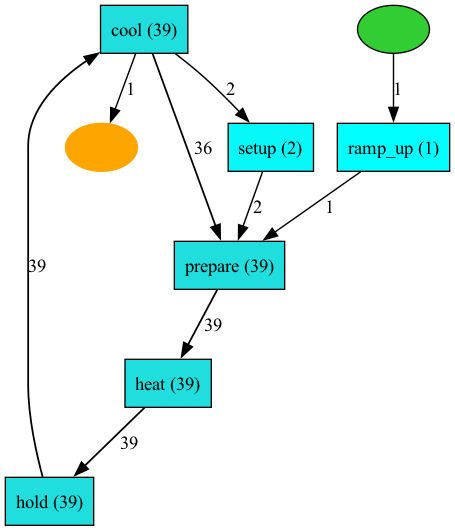

In [118]:
import pm4py
import pandas as pd

df = df_machine.copy()

df = df[df['machine_id'] == 'Autoclaving_1']

df['machine_id'] = 'machine_state' #df['linked_case_id'].fillna(0) #+ 1

df['machine_id'] = 1#df['linked_case_id'].fillna(0) #+ 1

#df['machine_id'] = 1#df.reset_index(drop=False)['index']

event_log = pm4py.format_dataframe(df, case_id='machine_id', activity_key='machine_state', timestamp_key='timestamp_start')

# Discover the Heuristic Net
net = pm4py.discover_heuristics_net(event_log)

# pm4py.save_vis_heuristics_net(net, 'heuristic_net.pdf', bgcolor='white')

# View the Heuristic Net
pm4py.view_heuristics_net(net, bgcolor='white')

In [37]:
df_machine

,timestamp_start,timestamp_end,process,machine_state,resource,machine_id,linked_case_id,recipe_name,has_product,log_type,date,event_type,case:concept:name,concept:name,time:timestamp
0,2024-01-01 07:35:08.634464177+00:00,2024-01-01 07:50:08.352609117+00:00,Autoclaving,ramp_up,Autoclaving_1,Autoclaving_1,NaN,None,False,machine_state,2024-01-01 00:00:00+00:00,machine_state,Autoclaving_1,ramp_up,2024-01-01 07:35:08.634464177+00:00
1,2024-01-01 07:50:08.352609117+00:00,2024-01-01 07:52:08.411871385+00:00,Autoclaving,prepare,Autoclaving_1,Autoclaving_1,1.0,A,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,Autoclaving_1,prepare,2024-01-01 07:50:08.352609117+00:00
2,2024-01-01 07:52:08.411871385+00:00,2024-01-01 08:10:16.110884360+00:00,Autoclaving,heat,Autoclaving_1,Autoclaving_1,1.0,A,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,Autoclaving_1,heat,2024-01-01 07:52:08.411871385+00:00
3,2024-01-01 08:10:16.110884360+00:00,2024-01-01 08:24:11.494166037+00:00,Autoclaving,hold,Autoclaving_1,Autoclaving_1,1.0,A,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,Autoclaving_1,hold,2024-01-01 08:10:16.110884360+00:00
4,2024-01-01 08:24:11.494166037+00:00,2024-01-01 08:52:10.571571920+00:00,Autoclaving,cool,Autoclaving_1,Autoclaving_1,1.0,A,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,Autoclaving_1,cool,2024-01-01 08:24:11.494166037+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,2024-01-01 07:33:57.802256668+00:00,2024-01-01 07:33:58.877423612+00:00,Water_cooling,cool,Water_cooling_1,Water_cooling_1,98.0,C,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,Water_cooling_1,cool,2024-01-01 07:33:57.802256668+00:00
1520,2024-01-01 07:33:58.877423612+00:00,2024-01-01 07:33:58.937231463+00:00,Water_cooling,prepare,Water_cooling_1,Water_cooling_1,99.0,C,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,Water_cooling_1,prepare,2024-01-01 07:33:58.877423612+00:00
1521,2024-01-01 07:33:58.937231463+00:00,2024-01-01 07:34:00.144136680+00:00,Water_cooling,cool,Water_cooling_1,Water_cooling_1,99.0,C,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,Water_cooling_1,cool,2024-01-01 07:33:58.937231463+00:00
1522,2024-01-01 07:34:00.144136680+00:00,2024-01-01 07:34:00.192444408+00:00,Water_cooling,prepare,Water_cooling_1,Water_cooling_1,100.0,C,True,machine_state,2024-01-01 00:00:00+00:00,machine_state,Water_cooling_1,prepare,2024-01-01 07:34:00.144136680+00:00


In [34]:
# import pm4py
# import pandas as pd

# df = material_df.copy()

# event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='resource', timestamp_key='timestamp_start')

# # Discover the BPMN model
# bpmn_model = pm4py.discover_bpmn_inductive(event_log)

# # pm4py.save_vis_bpmn(bpmn_model, 'bpmn_model.png', bgcolor='white')

# # View the BPMN model with top-to-bottom layout
# pm4py.view_bpmn(bpmn_model, bgcolor='white', rankdir='TB')

In [ ]:
aaaaaa

In [ ]:
import pm4py
import pandas as pd

df = event_log.copy()

event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='resource', timestamp_key='timestamp_start')

# Discover the Heuristic Net
net = pm4py.discover_heuristics_net(event_log)

# View the Heuristic Net
pm4py.view_heuristics_net(net, bgcolor='white')

In [ ]:
import pm4py
import pandas as pd

df = event_log.copy()

event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='process', timestamp_key='timestamp_start')

# Discover the Heuristic Net
net = pm4py.discover_heuristics_net(event_log)

# View the Heuristic Net
pm4py.view_heuristics_net(net, bgcolor='white')

In [ ]:
import pm4py
import pandas as pd

df = event_log.copy()

event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='event_type', timestamp_key='timestamp_start')

# Discover the Heuristic Net
net = pm4py.discover_heuristics_net(event_log)

# View the Heuristic Net
pm4py.view_heuristics_net(net, bgcolor='white')

In [ ]:
# import pm4py
# import pandas as pd

# df = event_log.copy()

# event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='resource', timestamp_key='timestamp_start')

# # Discover the Directly-Follow Graph (DFG)
# dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)

# # View the DFG
# pm4py.view_dfg(dfg, start_activities, end_activities)


## Add syntetic energy profiles

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_logistic_curve_between_timestamps(start_timestamp, end_timestamp, y_min, y_max, column_name, num_points_per_second=1, k=0.1, fix=False):
    """
    Generate a logistic curve between two timestamps with specified y-axis bounds or a constant value if 'fix' is True.

    Parameters:
    start_timestamp (str): Start timestamp in the format 'YYYY-MM-DD HH:MM:SS'.
    end_timestamp (str): End timestamp in the format 'YYYY-MM-DD HH:MM:SS'.
    y_min (float): Minimum value of the curve on the y-axis.
    y_max (float): Maximum value of the curve on the y-axis.
    num_points_per_second (int): Number of points to generate per second between the timestamps.
    k (float): The logistic growth rate or steepness of the curve.
    fix (bool): If True, the curve will be a constant value equal to y_max.

    Returns:
    pd.DataFrame: DataFrame containing timestamps, corresponding values, and points per second.
    """
    # Convert timestamps to datetime
    start_time = pd.to_datetime(start_timestamp)
    end_time = pd.to_datetime(end_timestamp)

    # Calculate the total number of seconds between the timestamps
    total_seconds = (end_time - start_time).total_seconds()

    # Calculate the number of points based on the seconds and num_points_per_second
    num_points = int(total_seconds * num_points_per_second)

    # Generate timestamps
    timestamps = pd.date_range(start=start_time, end=end_time, periods=num_points)
    num_timestamps = len(timestamps)

    if fix:
        # Generate constant values if fix is True
        values = np.full(num_timestamps, y_max)
    else:
        # Generate logistic curve values
        x0 = num_timestamps / 4  # Adjust the midpoint to start the curve sooner
        L = y_max - y_min  # Scale the curve to fit within y_min and y_max
        values = y_min + L / (1 + np.exp(-k * (np.arange(num_timestamps) - x0)))

    # Calculate points per second
    time_deltas = (timestamps[1:] - timestamps[:-1]).total_seconds()
    points_per_second = np.append(np.diff(values) / time_deltas, 0)  # Append 0 for the last point

    # Create DataFrame
    df = pd.DataFrame({'timestamp_start': timestamps, column_name: values})

    return df

# Example usage
start_timestamp = '2023-01-01 00:06:00'
end_timestamp = '2023-01-01 00:07:00'
y_min = 10
y_max = 60
fix = False  # Set to True to keep y_max constant
df_curve = generate_logistic_curve_between_timestamps(start_timestamp, end_timestamp, y_min, y_max, 'value', num_points_per_second=1, k=0.3, fix=fix)
display(df_curve)

# Plot the curve
plt.plot(df_curve['timestamp_start'], df_curve['value'], label='Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Logistic Curve' if not fix else 'Constant Value')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
import pandas as pd

# Create a dictionary with the values
data = {
    "recipe": ["A", "A", "A", "B", "B", "B", "C", "C", "C"],
    "activity": [
        "autoclave_1", "autoclave_2", "autoclave_3",
        "autoclave_1", "autoclave_2", "autoclave_3",
        "autoclave_1", "autoclave_2", "autoclave_3"
    ],
    "heating_power": [50, 70, 90, 40, 60, 80, 30, 50, 100]
}

# Convert the dictionary into a DataFrame
df_energy = pd.DataFrame(data)

# Display the DataFrame
df_energy

In [ ]:
event_log

In [ ]:
# Select the relevant columns
df = event_log.copy()

df = df.merge(df_energy, on=['recipe', 'activity'], how='left')

# Filter out rows where heating_power is 0
df = df[df['heating_power'] > 0]

df

In [ ]:
df = event_log.copy()

df = df.merge(df_energy, on=['recipe', 'activity'], how='left')

# df = df[df['activity'].str.contains('autoclave', case=False, na=False)]

df = df[df['heating_power'] > 0]

df = df.sort_values(by=['timestamp_start', 'case_id']).reset_index(drop=True)

df['case_id'].value_counts()

In [ ]:
df

In [ ]:
# Select the relevant columns
df = event_log.copy()

df = df.merge(df_energy, on=['recipe', 'activity'], how='left')

# Filter out rows where heating_power is 0
df = df[df['heating_power'] > 0]

df = df.sort_values(by=['timestamp_start', 'case_id']).reset_index(drop=True)

list_df = []

for case_id in df['case_id'].unique():
    row = df[df['case_id'] == case_id].iloc[0]
    df_curve = generate_logistic_curve_between_timestamps(
        row['timestamp_start'], 
        row['timestamp_end'],
        0, 
        row['heating_power'], 
        'heating_power', 
        num_points_per_second=0.1, 
        k=0.1, 
        fix=False
    )
    df_curve['start_end'] = 'in_between'
    df_curve.loc[0, 'start_end'] = 'start'
    df_curve.loc[df_curve.index[-1], 'start_end'] = 'end'
    df_curve['activity'] = row['activity']
    df_curve['case_id'] = case_id  # ← ADD THIS LINE
    df_curve = df_curve.reset_index()
    df_curve['lenght'] = df_curve['index'].max()
    list_df.append(df_curve)

# Concatenate the list of DataFrames
df = pd.concat(list_df, ignore_index=True).sort_values(by=['timestamp_start']).reset_index(drop=True)

# ← CHANGE THIS: Merge on BOTH timestamp_start AND case_id
df = df.merge(
    event_log, 
    on=['timestamp_start', 'activity', 'case_id'],  # ← Added 'case_id'
    how='left'
)

df_combined = df.ffill().copy()
df_combined = df_combined.sort_values(by=['timestamp_start', 'case_id'])

# df_combined = df_combined[df_combined['case_id'].isin([1])]

display(df_combined)

In [ ]:
import plotly.express as px
import pandas as pd

# Assuming `df_combined` is the DataFrame containing the data
df = df_combined.copy()

df = df[df['activity'].isin(['autoclave_1', 'autoclave_2', 'autoclave_3'])]

# Convert 'timestamp_start' to datetime if not already
df['timestamp_start'] = pd.to_datetime(df['timestamp_start'])

# Filter the DataFrame for the specific day
df = df[df['timestamp_start'].dt.date == pd.to_datetime('2024-01-01').date()]

# Plotting with Plotly
fig = px.line(
    df,
    x='timestamp_start',
    y='heating_power',
    title='Heating Power Over Time (01-01-2024)',
    labels={'timestamp_start': 'Timestamp Start', 'heating_power': 'Heating Power (kW)'},
    line_shape='linear',
    color='activity'
)

# Customize layout
fig.update_layout(
    xaxis_title='Timestamp Start',
    yaxis_title='Heating Power (kW)',
    title_font_size=16,
    xaxis=dict(tickangle=45),  # Rotate x-axis labels
    template='plotly_white'
)

# Show the plot
fig.show()

## Create sim from the event log

In [ ]:
import pm4py
import pandas as pd
from collections import defaultdict

# Assuming event_log is already defined in the notebook
df = event_log.copy()
event_log_pm = pm4py.format_dataframe(df, case_id='case_id', activity_key='activity', timestamp_key='timestamp_start')

print("Directed follow graph")
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log_pm)
pm4py.view_dfg(dfg, start_activities, end_activities)

print("Discovered petri net for the first log")
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(event_log_pm)
pm4py.view_petri_net(net, initial_marking, final_marking)

# NEW: Compute transition probabilities from the DFG
print("\nTransition Probabilities from DFG:")
transition_probabilities = defaultdict(dict)
outgoing_totals = defaultdict(int)

# Step 1: Calculate total outgoing frequencies for each source activity
for (source, target), freq in dfg.items():
    outgoing_totals[source] += freq

# Step 2: Compute probabilities for each transition
for (source, target), freq in dfg.items():
    if outgoing_totals[source] > 0:
        transition_probabilities[source][target] = freq / outgoing_totals[source]
    else:
        transition_probabilities[source][target] = 0.0

# Display the probabilities
for source, targets in transition_probabilities.items():
    print(f"From '{source}':")
    for target, prob in targets.items():
        print(f"  To '{target}': {prob:.3f} (frequency: {dfg.get((source, target), 0)})")
    print()

# Optional: Visualize DFG with frequencies (probabilities can be inferred from labels)
# Note: pm4py's view_dfg shows frequencies by default; probabilities are derived as above
# pm4py.view_dfg(dfg, start_activities, end_activities)  # Re-view with frequencies

# Second Petri Net: Discover, convert, play out, and view
log = event_log_pm
net, im, fm = pm4py.discover_petri_net_inductive(log)
net, im, fm = pm4py.convert_petri_net_type(net, im, fm, type="reset_inhibitor")
new_log = pm4py.play_out(net, im, fm, parameters={"add_only_if_fm_is_reached": True, "noTraces": 6147})

print("#" * 20)
print("New simulated log")
print(len(new_log))
print(pm4py.get_event_attribute_values(new_log, "concept:name"))
print(pm4py.get_end_activities(new_log))
dfg_new, start_activities_new, end_activities_new = pm4py.discover_dfg(new_log)
pm4py.view_dfg(dfg_new, start_activities_new, end_activities_new)
print("#" * 20)

# Transitions graph (DFG) for new log

In [ ]:
import pm4py
import pandas as pd

# Assuming event_log_pm is formatted
df_original = pm4py.convert_to_dataframe(event_log_pm)
df_original['duration'] = (df_original['timestamp_end'] - df_original['timestamp_start']).dt.total_seconds()
avg_durations = df_original.groupby('activity')['duration'].mean().to_dict()

In [ ]:
import pm4py

# Transform avg_durations into the stochastic map format
stochastic_map_dict = {
    activity: {'distribution_type': 'NORMAL', 'distribution_parameters': {'mean': mean, 'std': mean * 0.2}}
    for activity, mean in avg_durations.items()
}

# Simulate with timing using pm4py.play_out
new_log = pm4py.play_out(
    net, 
    im, 
    fm, 
    parameters={
        "stochastic_distribution_map": stochastic_map_dict,
        "num_traces": 6147,
        "return_visited_elements": False
    }
)

In [ ]:
stochastic_map_dict

In [ ]:
import pm4py

# Convert the simulated event log to a pandas DataFrame
df = pm4py.convert_to_dataframe(new_log)

df.columns = ['activity', 'timestamp_start','case_id']

# Sort by case_id and timestamp_start to ensure proper ordering
df = df.sort_values(by=['case_id', 'timestamp_start'])

# Set timestamp_end as the start time of the next activity in the same case_id
# df['timestamp_end'] = df.groupby('case_id')['timestamp_start'].shift(-1)

# Define the base start date (01.01.2024)
base_date = pd.to_datetime('2024-01-01')

# Convert timestamp_start and timestamp_end to datetime based on the seconds
# df['timestamp_start'] = base_date + pd.to_timedelta(df['timestamp_start'], unit='min')
# df['timestamp_end'] = base_date + pd.to_timedelta(df['timestamp_end'], unit='min')

# Display the DataFrame
df_new_log = df.copy()
df_new_log

In [ ]:
import pm4py
import pandas as pd

# Assuming new_log is your simulated event log from pm4py.play_out
df = pm4py.convert_to_dataframe(new_log)
df.columns = ['activity', 'timestamp_start', 'case_id']

# Sort by case_id and timestamp_start to ensure proper ordering
df = df.sort_values(by=['case_id', 'timestamp_start'])

# Set timestamp_end as the start time of the next activity in the same case_id
df['timestamp_end'] = df.groupby('case_id')['timestamp_start'].shift(-1)

# Convert timestamps to datetime if not already (assuming they are in seconds or minutes)
# Adjust the unit based on your simulation (e.g., 's' for seconds, 'min' for minutes)
base_date = pd.to_datetime('2024-01-01')  # Example base date
# df['timestamp_start'] = base_date + pd.to_timedelta(df['timestamp_start'], unit='s')  # Adjust unit as needed
# df['timestamp_end'] = base_date + pd.to_timedelta(df['timestamp_end'], unit='s')  # Adjust unit as needed

# Calculate duration for each event (in seconds)
df['duration'] = (df['timestamp_end'] - df['timestamp_start']).dt.total_seconds()

# # Group by activity and compute mean duration
# activity_durations = df.groupby('activity')['duration'].agg(['mean', 'std', 'count']).reset_index()

df


In [ ]:
import pm4py

# Convert the simulated event log to a pandas DataFrame
df = pm4py.convert_to_dataframe(new_log)

df.columns = ['activity', 'timestamp_start','case_id']

# Sort by case_id and timestamp_start to ensure proper ordering
df = df.sort_values(by=['case_id', 'timestamp_start'])

# Set timestamp_end as the start time of the next activity in the same case_id
df['timestamp_end'] = df.groupby('case_id')['timestamp_start'].shift(-1)

# Define the base start date (01.01.2024)
base_date = pd.to_datetime('2024-01-01')

# Convert timestamp_start and timestamp_end to datetime based on the seconds
# df['timestamp_start'] = base_date + pd.to_timedelta(df['timestamp_start'], unit='min')
# df['timestamp_end'] = base_date + pd.to_timedelta(df['timestamp_end'], unit='min')

# Display the DataFrame
df_new_log = df.copy()
df_new_log

## Using a DES 

In [ ]:
import pandas as pd
import pm4py
from pm4py.algo.discovery.dfg import algorithm as dfg_algo
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils

def extract_sim_config(df_input: pd.DataFrame):

    config = {
        "recipes": {}
    }
    for recipe in df_input['recipe'].unique():

        event_log_df = df_input.copy()

        event_log_df = event_log_df[event_log_df['recipe'] == recipe].copy()
        # Calculate durations
        event_log_df['duration'] = (event_log_df['timestamp_end'] - event_log_df['timestamp_start']).dt.total_seconds()

        # Ensure datetime format
        event_log_df = dataframe_utils.convert_timestamp_columns_in_df(event_log_df)

        # Convert pandas DataFrame to PM4Py EventLog
        log = log_converter.apply(event_log_df, variant=log_converter.Variants.TO_EVENT_LOG, parameters={"case_id_key": "case_id"})

        # 1. Extract DFG
        dfg = dfg_algo.apply(log)

        # Convert DFG to probabilistic process graph
        successors_count = {}
        total_outgoing = {}

        for (src, tgt), freq in dfg.items():
            if src not in successors_count:
                successors_count[src] = {}
            successors_count[src][tgt] = freq
            total_outgoing[src] = total_outgoing.get(src, 0) + freq

        process_graph = {}
        for src, targets in successors_count.items():
            process_graph[src] = {}
            for tgt, freq in targets.items():
                process_graph[src][tgt] = freq / total_outgoing[src]

        # 2. Compute process times
        time_stats = event_log_df.groupby("activity")["duration"].agg(['mean', 'std']).fillna(0)
        process_times = {
            activity: (row["mean"], row["std"])
            for activity, row in time_stats.iterrows()
        }

        # 3. Infer start activity
        start_activities = event_log_df.sort_values("timestamp_start").groupby("case_id").first()["activity"]
        start_activity = start_activities.value_counts().idxmax()

        sim_config = {
            "start": start_activity,
            "process_times": process_times,
            "process_graph": process_graph
        }

        config["recipes"][recipe] = sim_config    

    return config

event_log_pm = pm4py.format_dataframe(event_log, case_id='case_id', activity_key='activity', timestamp_key='timestamp_start')
config_new = extract_sim_config(event_log_pm)
config_new 

In [ ]:
df = run_simulation(df_plan, config_new)

# Define the base start date (01.01.2024)
base_date = pd.to_datetime('2024-01-01')

# Convert timestamp_start and timestamp_end to datetime based on the seconds
df['timestamp_start'] = base_date + pd.to_timedelta(df['timestamp_start'], unit='s')
df['timestamp_end'] = base_date + pd.to_timedelta(df['timestamp_end'], unit='s')

# Show the updated dataframe
new_event_log = df.copy()
new_event_log

In [ ]:
event_log

## Add the ML for the profiles

In [ ]:
df_combined

In [ ]:
df = event_log.copy()

# Get unique case_ids and sort them
unique_case_ids = sorted(df['case_id'].unique())

# Calculate the number of case_ids for training (70%)
num_train = int(0.7 * len(unique_case_ids))

# Split into train and test case_ids
train_case_ids = unique_case_ids[:num_train]
test_case_ids = unique_case_ids[num_train:]

# Filter the DataFrame based on the split case_ids
df_train = df[df['case_id'].isin(train_case_ids)].copy()
df_test = df[df['case_id'].isin(test_case_ids)].copy()

In [ ]:
def create_combined_df(df_input):
    # Select the relevant columns
    df = df_input.copy()
    
    df = df.merge(df_energy, on=['recipe', 'activity'], how='left')
    
    # Filter out rows where heating_power is 0
    df = df[df['heating_power'] > 0]
    
    df = df.sort_values(by=['timestamp_start', 'case_id']).reset_index(drop=True)
    
    list_df = []
    
    for case_id in df['case_id'].unique():
        row = df[df['case_id'] == case_id].iloc[0]
        df_curve = generate_logistic_curve_between_timestamps(
            row['timestamp_start'], 
            row['timestamp_end'],
            0, 
            row['heating_power'], 
            'heating_power', 
            num_points_per_second=0.1, 
            k=0.1, 
            fix=False
        )
        df_curve['start_end'] = 'in_between'
        df_curve.loc[0, 'start_end'] = 'start'
        df_curve.loc[df_curve.index[-1], 'start_end'] = 'end'
        df_curve['activity'] = row['activity']
        df_curve['case_id'] = case_id  # ← ADD THIS LINE
        df_curve = df_curve.reset_index()
        df_curve['lenght'] = df_curve['index'].max()
        list_df.append(df_curve)
    
    # Concatenate the list of DataFrames
    df = pd.concat(list_df, ignore_index=True).sort_values(by=['timestamp_start']).reset_index(drop=True)
    
    # ← CHANGE THIS: Merge on BOTH timestamp_start AND case_id
    df = df.merge(
        event_log, 
        on=['timestamp_start', 'activity', 'case_id'],  # ← Added 'case_id'
        how='left'
    )
    
    df_combined = df.ffill().copy()
    df_combined = df_combined.sort_values(by=['timestamp_start', 'case_id'])
    
    return df_combined

df_train_combined = create_combined_df(df_train)
df_test_combined = create_combined_df(df_test)

display(df_train_combined)
display(df_test_combined)

In [ ]:
df_train

In [ ]:
df_test

In [ ]:
# ============================================================================
# FULL SINGLE-CELL PIPELINE (FIXED LATENT CURVE + INVERSE RESAMPLING)
# One model: y = f(curve_index, activity, recipe)
# Model predicts fixed-size curve → resampled to requested size
# ============================================================================

import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from scipy.signal import medfilt

# ============================================================================
# CONFIGURATION: Abstract column names for flexibility
# ============================================================================

column_config = {
    'value_column': 'heating_power',      # Column containing the values to predict (e.g., heating_power)
    'case_id_column': 'case_id',          # Column for grouping cases (always present)
    'activity_column': 'activity',        # Column for activity (always present)
    'start_end_column': 'start_end',      # Column indicating start/end of curves
    'timestamp_column': 'timestamp_start', # Column for sorting timestamps
    'attribute_columns_categorical': ['recipe'],  # List of additional categorical columns for modeling features (e.g., recipe)
    'attribute_columns_numerical': []     # List of additional numerical columns for modeling features (e.g., temperature)
}

# ============================================================================
# 1. RAW DATA
# ============================================================================

df_raw = df_train.copy()

# Inject extreme outlier for robustness test
df_raw.loc[3, column_config['value_column']] = 10_000_000_000

# ============================================================================
# 2. EXTRACT RAW CURVES
# ============================================================================

def extract_curves(df, config):
    curves = []
    lengths = []

    for case_id, group in df.groupby(config['case_id_column']):
        group = group.sort_values(config['timestamp_column']).reset_index(drop=True)

        start_idxs = group[group[config['start_end_column']] == "start"].index
        end_idxs   = group[group[config['start_end_column']] == "end"].index

        for s in start_idxs:
            ends = end_idxs[end_idxs > s]
            if len(ends) == 0:
                continue

            e = ends[0]
            curve_df = group.iloc[s:e+1]

            if len(curve_df) < 3:
                continue

            values = curve_df[config['value_column']].values.astype(float)

            curve_dict = {
                "case_id": case_id,
                "activity": curve_df.iloc[0][config['activity_column']],
                "values": values
            }
            # Add attribute columns dynamically (both categorical and numerical)
            for col in config['attribute_columns_categorical'] + config['attribute_columns_numerical']:
                curve_dict[col] = curve_df.iloc[0][col]

            curves.append(curve_dict)
            lengths.append(len(values))

    if not curves:
        raise ValueError("No valid curves found")

    # Fixed latent curve length (robust choice)
    return curves, int(np.median(lengths))

curves, TARGET_LENGTH = extract_curves(df_raw, column_config)

print(f"Extracted {len(curves)} curves")
print(f"Latent curve length (model space): {TARGET_LENGTH}")

# ============================================================================
# 3. RESAMPLING FUNCTIONS
# ============================================================================

def resample_curve(values, target_len):
    """Resample any curve to target_len (robustly)"""
    values = np.asarray(values, dtype=float)

    mean, std = values.mean(), values.std()
    values = np.clip(values, mean - 3 * std, mean + 3 * std)
    values = medfilt(values, kernel_size=min(5, len(values)))

    x_old = np.linspace(0, 1, len(values))
    x_new = np.linspace(0, 1, target_len)

    return np.interp(x_new, x_old, values)

def inverse_resample_curve(values, new_len):
    """Resample fixed-length predicted curve to requested output size"""
    x_old = np.linspace(0, 1, len(values))
    x_new = np.linspace(0, 1, new_len)

    return np.interp(x_new, x_old, values)

# ============================================================================
# 4. RESAMPLE ALL CURVES TO LATENT SIZE
# ============================================================================

for c in curves:
    c["values"] = resample_curve(c["values"], TARGET_LENGTH)

# ============================================================================
# 5. CURVES → LONG REGRESSION DATASET (FIXED INDEX)
# ============================================================================

rows = []

for curve_id, c in enumerate(curves):
    for idx, y in enumerate(c["values"], start=1):
        row = {
            "curve_id": curve_id,
            "curve_index": idx,        # ALWAYS 1..TARGET_LENGTH
            "activity": c["activity"],
            "y": float(y)
        }
        # Add attribute columns dynamically (both categorical and numerical)
        for col in column_config['attribute_columns_categorical'] + column_config['attribute_columns_numerical']:
            row[col] = c[col]
        rows.append(row)

df_model = pd.DataFrame(rows)

print(f"Total regression samples: {len(df_model)}")
print(df_model.head())

# ============================================================================
# 6. TRAIN / TEST SPLIT (BY CURVE)
# ============================================================================

curve_ids = df_model["curve_id"].unique()

train_ids, test_ids = train_test_split(
    curve_ids, test_size=0.2, random_state=42
)

train_df = df_model[df_model["curve_id"].isin(train_ids)]
test_df  = df_model[df_model["curve_id"].isin(test_ids)]

X_train = train_df[["curve_index", "activity"] + column_config['attribute_columns_categorical'] + column_config['attribute_columns_numerical']]
y_train = train_df["y"].values

X_test = test_df[["curve_index", "activity"] + column_config['attribute_columns_categorical'] + column_config['attribute_columns_numerical']]
y_test = test_df["y"].values

# ============================================================================
# 7. PREPROCESSING
# ============================================================================

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["activity"] + column_config['attribute_columns_categorical']),
        ("num", "passthrough", ["curve_index"] + column_config['attribute_columns_numerical']),
    ]
)

# ============================================================================
# 8. MODELS
# ============================================================================

models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=300,
        max_depth=20,
        n_jobs=-1,
        random_state=42
    ),
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
}

# ============================================================================
# 9. TRAINING + EVALUATION
# ============================================================================

results = []
trained_models = {}

for name, reg in models.items():
    print(f"\nTraining {name}...")

    pipe = Pipeline([
        ("prep", preprocess),
        ("model", reg)
    ])

    pipe.fit(X_train, y_train)
    trained_models[name] = pipe

    y_pred = pipe.predict(X_test)

    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "RMSE": rmse,
        "R2": r2
    })

    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.4f}")

results_df = pd.DataFrame(results).sort_values("RMSE")
print("\nMODEL RANKING")
print(results_df)

# ============================================================================
# 10. FULL CURVE PREDICTION WITH INVERSE RESAMPLING
# ============================================================================

def predict_curve(model, activity, output_length, **attributes):
    """
    Predict a curve given the activity and additional attributes.
    Attributes should be passed as keyword arguments, e.g., recipe='A', temperature=25.0
    """
    X_latent = pd.DataFrame({
        "curve_index": np.arange(1, TARGET_LENGTH + 1),
        "activity": activity,
        **attributes
    })

    latent_curve = model.predict(X_latent)

    return inverse_resample_curve(latent_curve, output_length)

# ============================================================================
# 11. EXAMPLE USAGE
# ============================================================================

best_model = trained_models[results_df.iloc[0]["Model"]]

predicted_curve_300 = predict_curve(
    model=best_model,
    activity=train_df["activity"].iloc[0],
    output_length=300,
    recipe=train_df["recipe"].iloc[0]
)

print(f"\nPredicted curve length (output space): {len(predicted_curve_300)}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

# Assuming 'curves' is defined as before, with 'resampled_curve' added if needed
# For each curve in curves, add 'resampled_curve' if not present
for curve in curves:
    if 'resampled_curve' not in curve:
        curve['resampled_curve'] = curve['values']  # Or resample if needed

# Get the list of attribute columns from the config (assuming curves have them)
attribute_columns = column_config['attribute_columns_categorical'] + column_config['attribute_columns_numerical']

# Convert the list of dictionaries to a DataFrame
rows = []
for curve in curves:
    case_id = curve['case_id']
    activity = curve['activity']
    values = curve['resampled_curve']  # Use resampled_curve
    row_base = {
        'case_id': case_id,
        'activity': activity,
        'index': None,  # Will set in loop
        'value': None   # Will set in loop
    }
    # Add attribute columns dynamically
    for col in attribute_columns:
        row_base[col] = curve[col]
    
    for idx, value in enumerate(values):
        row = row_base.copy()
        row['index'] = idx
        row['value'] = value
        rows.append(row)

df_curves = pd.DataFrame(rows)

# Group by case_id, activity, and all attribute columns
group_columns = ['case_id', 'activity'] + attribute_columns
grouped = df_curves.groupby(group_columns)

# Get a colormap for different colors per curve
num_curves = len(grouped)
colors = cm.viridis(np.linspace(0, 1, num_curves))

plt.figure(figsize=(10, 6))

# Plot each curve separately with a different color
for i, (group_keys, group) in enumerate(grouped):
    group = group.sort_values('index')  # Ensure sorted by index
    y_values = group['value'].values
    x_values = group['index'].values
    # Create label from group keys
    label_parts = [str(key) for key in group_keys]
    label = '_'.join(label_parts)
    plt.plot(x_values, y_values, linestyle='-', color=colors[i], label=label)

plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Curves per Activity, Attributes, and Case ID")
plt.grid(True)
# plt.legend()  # Uncomment if you want a legend, but with many curves it might be cluttered
plt.show()

In [ ]:
# ============================================================================
# 11. EXAMPLE USAGE
# ============================================================================

best_model = trained_models[results_df.iloc[0]["Model"]]

predicted_curve_300 = predict_curve(
    model=best_model,
    activity=train_df["activity"].iloc[0],
    output_length=300,
    recipe=train_df["recipe"].iloc[0]
)

print(f"\nPredicted curve length (output space): {len(predicted_curve_300)}")


curves = [
    predict_curve(model=best_model, activity='autoclave_1', output_length=120, recipe='A'),  # default length
    predict_curve(model=best_model, activity='autoclave_2', output_length=60, recipe='A'),  # default length
    predict_curve(model=best_model, activity='autoclave_3', output_length=81, recipe='A'),  # custom length
]

# Plot all curves
for i, curve in enumerate(curves):
    x_values = range(len(curve))
    plt.plot(x_values, curve, label=f'Prediction {i+1}')

plt.xlabel('Index')
plt.ylabel('Predicted Value')
plt.title('Predicted Curves')
plt.legend()
plt.show()

## Do predictions for the testset

In [ ]:
# Select the relevant columns
df = df_test.copy()

# No need to merge with df_energy since we're using the trained model

# Filter out rows where heating_power is 0 (if applicable, but since we're predicting, maybe not needed)
# df = df[df['heating_power'] > 0]  # Remove if not present in df_test

df = df[df['activity'].isin(['autoclave_1', 'autoclave_2', 'autoclave_3'])]

df = df.sort_values(by=['timestamp_start', 'case_id']).reset_index(drop=True)

list_df = []

for case_id in df['case_id'].unique():
    row = df[df['case_id'] == case_id].iloc[0]
    
    # Calculate the duration in seconds
    duration_seconds = (row['timestamp_end'] - row['timestamp_start']).total_seconds()
    
    # Calculate output_length based on 0.1 points per second (as in original)
    output_length = int(duration_seconds * 0.1)
    
    # Predict the curve using the trained model
    curve_values = predict_curve(
        model=best_model,
        activity=row['activity'],
        output_length=output_length,
        recipe=row['recipe']
    )
    
    # Generate timestamps
    timestamps = pd.date_range(start=row['timestamp_start'], end=row['timestamp_end'], periods=output_length)
    
    # Create the DataFrame for the curve
    df_curve = pd.DataFrame({
        'timestamp_start': timestamps,
        'heating_power': curve_values
    })
    
    df_curve['start_end'] = 'in_between'
    df_curve.loc[0, 'start_end'] = 'start'
    df_curve.loc[df_curve.index[-1], 'start_end'] = 'end'
    df_curve['activity'] = row['activity']
    df_curve['case_id'] = case_id
    df_curve = df_curve.reset_index()
    df_curve['lenght'] = df_curve['index'].max()
    list_df.append(df_curve)

# Concatenate the list of DataFrames
df = pd.concat(list_df, ignore_index=True).sort_values(by=['timestamp_start']).reset_index(drop=True)

# Merge on BOTH timestamp_start AND case_id
df = df.merge(
    event_log, 
    on=['timestamp_start', 'activity', 'case_id'],  # Assuming event_log has these columns
    how='left'
)

df_test_combined_prediction = df.ffill().copy()
df_test_combined_prediction = df_test_combined_prediction.sort_values(by=['timestamp_start', 'case_id'])

display(df_test_combined_prediction)

In [ ]:
import pandas as pd
import plotly.express as px

# Assuming df_test_combined_prediction and df_test_combined are defined
# Filter and prepare df_test_combined_prediction
df_pred = df_test_combined_prediction.copy()
df_pred = df_pred[df_pred['activity'].isin(['autoclave_1', 'autoclave_2', 'autoclave_3'])]
df_pred['timestamp_start'] = pd.to_datetime(df_pred['timestamp_start'])
df_pred = df_pred[df_pred['timestamp_start'].dt.date == pd.to_datetime('2024-02-04').date()]
df_pred['type'] = 'prediction'
df_pred['activity_type'] = df_pred['activity'] + '_prediction'

# Filter and prepare df_test_combined
df_actual = df_test_combined.copy()
df_actual = df_actual[df_actual['activity'].isin(['autoclave_1', 'autoclave_2', 'autoclave_3'])]
df_actual['timestamp_start'] = pd.to_datetime(df_actual['timestamp_start'])
df_actual = df_actual[df_actual['timestamp_start'].dt.date == pd.to_datetime('2024-02-04').date()]
df_actual['type'] = 'actual'
df_actual['activity_type'] = df_actual['activity'] + '_actual'

# Concatenate the two DataFrames
df_combined_plot = pd.concat([df_pred, df_actual], ignore_index=True)

# Plotting with Plotly
fig = px.line(
    df_combined_plot,
    x='timestamp_start',
    y='heating_power',
    title='Heating Power Over Time: Prediction vs Actual',
    labels={'timestamp_start': 'Timestamp Start', 'heating_power': 'Heating Power (kW)'},
    line_shape='linear',
    color='activity_type'
)

# Customize layout
fig.update_layout(
    xaxis_title='Timestamp Start',
    yaxis_title='Heating Power (kW)',
    title_font_size=16,
    xaxis=dict(tickangle=45),  # Rotate x-axis labels
    template='plotly_white'
)

# Show the plot
fig.show()

In [ ]:
df_test

# Add the energy data

In [ ]:
a

In [ ]:
# Add 273.5 to all columns that contain 'in' or 'out' to convert to Kelvin
# for col in df.columns:
#     if 'in' in col or 'out' in col:
#         df[col] = df[col] + 273.5

# Display the modified DataFrame

recipes = [
    # Recipe A
    {
        "recipe_name": "A",
        "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 61, "Autoclaving_heat_CP": 10,  
        "Autoclaving_hold_in": 119, "Autoclaving_hold_out": 51, "Autoclaving_hold_CP": 10,   
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 46, "Autoclaving_cool_CP": 25,   
        "Destillation_heat_in": 121, "Destillation_heat_out": 52, "Destillation_heat_CP": 10,  
        "Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 22, "Water_cooling_cool_out": 83, "Water_cooling_cool_CP": 35,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 25, "Bottling_cool_CP": 16 
    },
    {
        "recipe_name": "B",
        "Autoclaving_heat_in": 124, "Autoclaving_heat_out": 55, "Autoclaving_heat_CP": 10,  
        "Autoclaving_hold_in": 119, "Autoclaving_hold_out": 51, "Autoclaving_hold_CP": 10,   
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 46, "Autoclaving_cool_CP": 25,   
        "Destillation_heat_in": 121, "Destillation_heat_out": 52, "Destillation_heat_CP": 10,  
        "Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 22, "Water_cooling_cool_out": 83, "Water_cooling_cool_CP": 35,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 25, "Bottling_cool_CP": 16 
    },
        {
        "recipe_name": "C",
        "Autoclaving_heat_in": 130, "Autoclaving_heat_out": 70, "Autoclaving_heat_CP": 10,  
        "Autoclaving_hold_in": 119, "Autoclaving_hold_out": 51, "Autoclaving_hold_CP": 10,   
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 46, "Autoclaving_cool_CP": 25,   
        "Destillation_heat_in": 121, "Destillation_heat_out": 52, "Destillation_heat_CP": 10,  
        "Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 22, "Water_cooling_cool_out": 83, "Water_cooling_cool_CP": 35,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 25, "Bottling_cool_CP": 16 
    },
        {
        "recipe_name": "D",
        "Autoclaving_heat_in": 135, "Autoclaving_heat_out": 55, "Autoclaving_heat_CP": 10,  
        "Autoclaving_hold_in": 119, "Autoclaving_hold_out": 51, "Autoclaving_hold_CP": 10,   
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 46, "Autoclaving_cool_CP": 25,   
        "Destillation_heat_in": 121, "Destillation_heat_out": 52, "Destillation_heat_CP": 10,  
        "Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 22, "Water_cooling_cool_out": 83, "Water_cooling_cool_CP": 35,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 25, "Bottling_cool_CP": 16 
    },

]

recipes = [
    # Recipe A
    {
        "recipe_name": "A",
        "Autoclaving_heat_in": 120, "Autoclaving_heat_out": 61, "Autoclaving_heat_CP": 10,  
        "Autoclaving_hold_in": 120, "Autoclaving_hold_out": 49, "Autoclaving_hold_CP": 10,   
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 55, "Autoclaving_cool_CP": 25,   
        "Destillation_heat_in": 121, "Destillation_heat_out": 52, "Destillation_heat_CP": 10,  
        "Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 22, "Water_cooling_cool_out": 83, "Water_cooling_cool_CP": 35,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 25, "Bottling_cool_CP": 16 
    },
    {
        "recipe_name": "B",
        "Autoclaving_heat_in": 124, "Autoclaving_heat_out": 60, "Autoclaving_heat_CP": 10,  
        "Autoclaving_hold_in": 124, "Autoclaving_hold_out": 65, "Autoclaving_hold_CP": 10,   
        "Autoclaving_cool_in": 38, "Autoclaving_cool_out": 49, "Autoclaving_cool_CP": 25,   
        "Destillation_heat_in": 121, "Destillation_heat_out": 52, "Destillation_heat_CP": 10,  
        "Destillation_cool_in": 47, "Destillation_cool_out": 73, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 25, "Water_cooling_cool_out": 85, "Water_cooling_cool_CP": 35,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 25, "Bottling_cool_CP": 16 
    },
        {
        "recipe_name": "C",
        "Autoclaving_heat_in": 165, "Autoclaving_heat_out": 70, "Autoclaving_heat_CP": 10,  
        "Autoclaving_hold_in": 160, "Autoclaving_hold_out": 75, "Autoclaving_hold_CP": 10,   
        "Autoclaving_cool_in": 38, "Autoclaving_cool_out": 43, "Autoclaving_cool_CP": 25,   
        "Destillation_heat_in": 130, "Destillation_heat_out": 55, "Destillation_heat_CP": 10,  
        "Destillation_cool_in": 47, "Destillation_cool_out": 79, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 26, "Water_cooling_cool_out": 85, "Water_cooling_cool_CP": 35,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 25, "Bottling_cool_CP": 16 
    },
        {
        "recipe_name": "D",
        "Autoclaving_heat_in": 175, "Autoclaving_heat_out": 75, "Autoclaving_heat_CP": 10,  
        "Autoclaving_hold_in": 145, "Autoclaving_hold_out": 80, "Autoclaving_hold_CP": 10,   
        "Autoclaving_cool_in": 30, "Autoclaving_cool_out": 60, "Autoclaving_cool_CP": 25,   
        "Destillation_heat_in": 130, "Destillation_heat_out": 52, "Destillation_heat_CP": 10,  
        "Destillation_cool_in": 46, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 21, "Water_cooling_cool_out": 86, "Water_cooling_cool_CP": 35,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 27, "Bottling_cool_CP": 16 
    },

]

recipes = [
    {
        "recipe_name": "D",
        "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 3500,  
        "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 60, 
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 75, "Autoclaving_cool_CP": 25,   

        "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
        #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 11
    },
    {
        "recipe_name": "A",
        "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 3200,  
        "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 600, 
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 70, "Autoclaving_cool_CP": 25,   

        "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
        #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 11
    },
    {
        "recipe_name": "B",
        "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 3000,  
        "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 60, 
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 55, "Autoclaving_cool_CP": 25,   

        "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
        #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 11
    },
    {
        "recipe_name": "C",
        "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 4000,  
        "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 600, 
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 55, "Autoclaving_cool_CP": 25,   

        "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
        #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 11
    },

]

recipes = [
    {
        "recipe_name": "A",
        "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 3500,  
        "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 600, 
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 75, "Autoclaving_cool_CP": 27,   

        "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
        #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 25
    },
    {
        "recipe_name": "B",
        "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 3200,  
        "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 600, 
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 70, "Autoclaving_cool_CP": 24,   

        "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
        #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 25
    },
    {
        "recipe_name": "C",
        "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 3000,  
        "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 600, 
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 55, "Autoclaving_cool_CP": 23,   

        "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
        #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 25
    },
    {
        "recipe_name": "D",
        "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 3700,  
        "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 650, 
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 55, "Autoclaving_cool_CP": 28,   

        "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
        #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 25
    },

]

recipes = [
    {
        "recipe_name": "A",
        "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 3500,  
        "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 650, 
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 75, "Autoclaving_cool_CP": 29,   

        "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
        #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 25
    },
    {
        "recipe_name": "B",
        "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 3250,  
        "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 580, 
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 75, "Autoclaving_cool_CP": 26,   

        "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
        #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 25
    },
    {
        "recipe_name": "C",
        "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 3600,  
        "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 670, 
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 75, "Autoclaving_cool_CP": 31,   

        "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
        #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 25
    },
    {
        "recipe_name": "D",
        "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 3200,  
        "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 590, 
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 75, "Autoclaving_cool_CP": 26,   

        "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
        #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 25
    },

]

recipes = [
    {
        "recipe_name": "C",
        "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 3500,  
        "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 630, 
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 75, "Autoclaving_cool_CP": 28,   

        "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
        #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 25
    },
    {
        "recipe_name": "A",
        "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 3200,  
        "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 600, 
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 70, "Autoclaving_cool_CP": 26,   

        "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
        #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 25
    },
    {
        "recipe_name": "D",
        "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 3000,  
        "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 590, 
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 55, "Autoclaving_cool_CP": 22,   

        "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
        #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 25
    },
    {
        "recipe_name": "B",
        "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 3700,  
        "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 650, 
        "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 55, "Autoclaving_cool_CP":30,   

        "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
        #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
        "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
        "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 25
    },

]

df = pd.DataFrame(recipes)

# Split the DataFrame into three DataFrames based on the suffix
df_in = df.filter(like='_in')
df_out = df.filter(like='_out')
df_CP = df.filter(like='_CP')

# Add the recipe_name column back to each DataFrame
df_in.insert(0, 'recipe_name', df['recipe_name'])
df_out.insert(0, 'recipe_name', df['recipe_name'])
df_CP.insert(0, 'recipe_name', df['recipe_name'])

# Pivot each DataFrame
df_in_pivoted = df_in.melt(id_vars='recipe_name', var_name='event_type', value_name='temp_in')
df_out_pivoted = df_out.melt(id_vars='recipe_name', var_name='event_type', value_name='temp_out')
df_CP_pivoted = df_CP.melt(id_vars='recipe_name', var_name='event_type', value_name='CP')

# Remove suffixes from the event_type column
df_in_pivoted['event_type'] = df_in_pivoted['event_type'].str.replace('_in', '', regex=False)
df_out_pivoted['event_type'] = df_out_pivoted['event_type'].str.replace('_out', '', regex=False)
df_CP_pivoted['event_type'] = df_CP_pivoted['event_type'].str.replace('_CP', '', regex=False)

# Merge df_in_pivoted and df_out_pivoted
merged_df = pd.merge(df_in_pivoted, df_out_pivoted, on=['recipe_name', 'event_type'], how='outer')

# Merge the result with df_CP_pivoted
final_df = pd.merge(merged_df, df_CP_pivoted, on=['recipe_name', 'event_type'], how='outer')

# Display the final DataFrame
df_energy = final_df .copy()

#df_energy

In [ ]:
# Perform the join on 'recipe_name'
df_combined = pd.merge(store_df, df_energy, on=['recipe_name', 'event_type'], how='left')

df_combined = df_combined.fillna(0)

df_combined['Q'] = (df_combined['CP'] * abs(df_combined['temp_in'] - df_combined['temp_out']))

# Define conditions
conditions = [
    df_combined['event_type'].str.contains('heat', case=False, na=False),  # 'heat' condition
    df_combined['event_type'].str.contains('cool', case=False, na=False),  # 'cool' condition
    df_combined['event_type'].str.contains('hold', case=False, na=False),  # 'hold' condition
    df_combined['event_type'].str.contains('bottling_machine', case=False, na=False)  # 'bottling_machine' condition
]

# Define corresponding values
choices = ['heat', 'cool', 'heat', 'heat']  # All 'hold' and 'bottling_machine' will be labeled as 'heat'

# Create the new column based on the conditions
df_combined['profile_type'] = np.select(conditions, choices, default='None')

# for value in df_combined['event_type'].unique():
#     print(value)
#df_combined['event_type']#.unique()

print(df_combined['Q'].mean())

In [ ]:
# Scenario 2

store_df_2 = store_df.copy()

#store_df_2.loc[store_df_2['case_id'] > 13500, 'recipe_name'] = store_df_2.loc[store_df_2['case_id'] > 13500, 'recipe_name'].replace({'C': 'A', 'D': 'B'})

# Count the occurrences of each recipe
recipe_counts = store_df_2['recipe_name'].value_counts()

# Calculate the number of replacements needed
num_replace_C = recipe_counts['C'] // 2
num_replace_D = recipe_counts['D'] // 2

# Replace 'C' with 'A' and 'D' with 'B' accordingly
store_df_2.loc[store_df_2['recipe_name'] == 'C', 'recipe_name'] = 'A'
store_df_2.loc[store_df_2['recipe_name'] == 'D', 'recipe_name'] = 'B'

# Ensure the replacements are done only for the calculated number
store_df_2.loc[store_df_2['recipe_name'] == 'A', 'recipe_name'] = store_df_2.loc[store_df_2['recipe_name'] == 'A', 'recipe_name'].replace({'A': 'C'}, limit=num_replace_C)
store_df_2.loc[store_df_2['recipe_name'] == 'B', 'recipe_name'] = store_df_2.loc[store_df_2['recipe_name'] == 'B', 'recipe_name'].replace({'B': 'D'}, limit=num_replace_D)

df_combined_2 = pd.merge(store_df_2, df_energy, on=['recipe_name', 'event_type'], how='left')

df_combined_2 = df_combined_2.fillna(0)

df_combined_2['Q'] = abs(df_combined_2['CP'] * (df_combined_2['temp_in'] - df_combined_2['temp_out']))

# Define conditions
conditions = [
    df_combined_2['event_type'].str.contains('heat', case=False, na=False),  # 'heat' condition
    df_combined_2['event_type'].str.contains('cool', case=False, na=False),  # 'cool' condition
    df_combined_2['event_type'].str.contains('hold', case=False, na=False),  # 'hold' condition
    df_combined_2['event_type'].str.contains('bottling_machine', case=False, na=False)  # 'bottling_machine' condition
]

# Define corresponding values
choices = ['heat', 'cool', 'heat', 'heat']  # All 'hold' and 'bottling_machine' will be labeled as 'heat'

# Create the new column based on the conditions
df_combined_2['profile_type'] = np.select(conditions, choices, default='None')

# for value in df_combined_2['event_type'].unique():
#     print(value)
print(df_combined_2['Q'].mean())

# Visualize

In [ ]:
store = False
if store:
    # Store in a csv file
    # Define the file path
    file_path = "../../data/bronze/company_x_dataset/events.csv"

    # Check if the file exists
    if os.path.exists(file_path):
        # If the file exists, delete it
        os.remove(file_path)
        print(f"Deleted existing file: {file_path}")

    # Save the DataFrame to a CSV file
    df_combined.to_csv(file_path, index=False)
    print(f"DataFrame saved to {file_path}")

In [ ]:
df_combined

In [ ]:
# # Checkt the process demands

# # Copy and filter the dataframe
# df = df_combined.copy().sample(5000)
# df = df[df['profile_type'].isin(['heat', 'cool'])]
# df = df[df['Q'] > 0]

# # Set the color palette based on 'profile_type' (red for heat, blue for cool)
# palette = {'cool': 'red', 'heat': 'blue'}

# # Get the unique values in the 'resource' column
# resources = df['resource'].unique()

# # Create a figure and subplots (3 columns, 5 rows), with smaller individual visuals
# fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20))  # Adjusted size for smaller visuals
# axes = axes.flatten()  # Flatten the axes array for easier indexing

# # Loop through each unique resource and plot
# for i, resource in enumerate(resources[:15]):  # Limiting to 15 visuals for 3x5 layout
#     # Filter the dataframe for the current resource
#     df_resource = df[df['resource'] == resource]
    
#     # Plot using seaborn on the respective subplot with index as x-axis
#     sns.lineplot(
#         data=df_resource, 
#         x=df_resource.index,  # Use the index of the DataFrame
#         y='Q',  # Plot the original 'Q' values
#         hue='profile_type', 
#         palette=palette,  # Use red and blue colors for 'heat' and 'cool'
#         markers=True,  # Enable markers
#         marker='o',  # Small circle as the marker
#         ax=axes[i],  # Select the correct subplot
#         legend=False  # Disable the legend
#     )
    
#     # Set background color for each subplot
#     axes[i].set_facecolor('#f0f0f0')  # You can change this color as needed (light gray here)
    
#     # Set plot labels and title for each subplot
#     axes[i].set_title(f'{resource}')
#     axes[i].set_xlabel('Event')  # Label as 'Index' instead of 'Timestamp End'
#     axes[i].set_ylabel(f'kW')
#     axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# # Adjust layout to prevent overlapping
# plt.tight_layout()
# plt.show()


In [ ]:
# import pandas as pd
# import plotly.express as px


# # Filter the dataframe for a single month
# single_month = '2024-01'
# df = df_combined[df_combined['timestamp_start'].dt.to_period('M') == pd.to_datetime(single_month).to_period('M')]

# #df = df_combined

# # Group by day and resource to count the number of activations
# df['day'] = df['timestamp_start'].dt.date
# df_grouped = df.groupby(['day', 'resource']).size().reset_index(name='activations')

# # Create a bar chart using Plotly
# fig = px.bar(df_grouped, x='day', y='activations', color='resource', title='Resource Activations per Day in January 2023')

# # Show the plot
# fig.show()

In [ ]:
import pandas as pd
import plotly.express as px

# Copy and fill NaN with 0
df = df_combined.copy().fillna(0)

# Filter date range
day_start = '2024-01-01'
day_end = '2024-01-03'
df = df[(df['timestamp_start'].dt.date >= pd.to_datetime(day_start).date()) & 
        (df['timestamp_end'].dt.date <= pd.to_datetime(day_end).date())]

# Filter specific machines
df = df[df['machine'].isin(['Autoclaving_2'])]

# Prepare start and end dataframes
df_start = df[['timestamp_start', 'Q', 'profile_type', 'resource', 'machine']].rename(columns={'timestamp_start': 'datetime'}).reset_index()
df_start['type'] = 'start'

df_end = df[['timestamp_end', 'Q', 'profile_type', 'resource', 'machine']].rename(columns={'timestamp_end': 'datetime'}).reset_index()
df_end['type'] = 'end'

df_end_2 = df[['timestamp_end', 'Q', 'profile_type', 'resource', 'machine']].rename(columns={'timestamp_end': 'datetime'}).reset_index()
df_end_2['type'] = 'end_2'
df_end_2['Q'] = 0

# Merge both dataframes
df = pd.concat([df_start, df_end, df_end_2])
df = df.sort_values(by=['datetime', 'index', 'type'])

# Copy for plotting
df_new = df.copy()
color_palette = {'heat': 'red', 'cool': 'blue', 'hold': 'red'}

# Loop through each unique machine and resource to plot in Plotly
for machine in df_new['machine'].unique():
    df_machine = df_new[df_new['machine'] == machine]
    
    for resource in df_machine['resource'].unique():

        print(resource)
        df_resource = df_machine.copy()
        df_resource.loc[df_resource['resource'] != resource, 'Q'] = 0  # Set Q=0 for other resources

        # Determine color based on resource name
        color = 'red' if 'heat' in resource.lower() or 'hold' in resource.lower() else 'blue'

        # Create interactive Plotly figure
        fig = px.line(
            df_resource,
            x="datetime",
            y="Q",
            title=f"",
            line_shape="linear",
            hover_name="resource",
            color_discrete_sequence=[color]
        )

        # Customize layout
        fig.update_layout(
            xaxis_title="Datetime",
            yaxis_title="kW",
            hovermode="x unified",
            width=800,  # Adjust width for less wide figure
            height=400  # Adjust height as needed
        )

        fig.update_layout(margin=dict(l=0, r=2, t=0, b=0))
        # Show interactive plot
        fig.show()


        fig.write_image(f"/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/profle_autoclave_{resource}.png", format="png", scale=3)

In [ ]:
import pandas as pd
import plotly.express as px

# Copy and fill NaN with 0
df = df_combined.copy().fillna(0)

# Filter date range
day_start = '2024-01-01'
day_end = '2024-01-03'
df = df[(df['timestamp_start'].dt.date >= pd.to_datetime(day_start).date()) & 
        (df['timestamp_end'].dt.date <= pd.to_datetime(day_end).date())]

# Filter specific machines
df = df[df['machine'].isin(['Destillation_1'])]

# Prepare start and end dataframes
df_start = df[['timestamp_start', 'Q', 'profile_type', 'resource', 'machine', 'recipe_name']].rename(columns={'timestamp_start': 'datetime'}).reset_index()
df_start['type'] = 'start'

df_end = df[['timestamp_end', 'Q', 'profile_type', 'resource', 'machine', 'recipe_name']].rename(columns={'timestamp_end': 'datetime'}).reset_index()
df_end['type'] = 'end'

# df_end_2 = df[['timestamp_end', 'Q', 'profile_type', 'resource', 'machine', 'recipe_name']].rename(columns={'timestamp_end': 'datetime'}).reset_index()
# df_end_2['type'] = 'end_2'
# df_end_2['Q'] = 0

# Merge both dataframes
df = pd.concat([df_start, df_end])#, df_end_2])
df = df.sort_values(by=['datetime', 'index', 'type'])

# Copy for plotting
df_new = df.copy()
color_palette = {'heat': 'red', 'cool': 'blue', 'hold': 'red'}

# Loop through each unique machine and resource to plot in Plotly
for machine in df_new['machine'].unique():
    df_machine = df_new[df_new['machine'] == machine]
    
    for resource in df_machine['resource'].unique():
        df_resource = df_machine.copy()
        df_resource.loc[df_resource['resource'] != resource, 'Q'] = 0  # Set Q=0 for other resources

        # Determine color based on resource name
        color = 'red' if 'heat' in resource.lower() or 'hold' in resource.lower() else 'blue'

        # Create interactive Plotly figure
        fig = px.line(
            df_resource,
            x="datetime",
            y="Q",
            title=f"",
            line_shape="linear",
            hover_name="recipe_name",
            color_discrete_sequence=[color]
        )

        # Customize layout
        fig.update_layout(
            xaxis_title="Datetime",
            yaxis_title="kW",
            hovermode="x unified",
            width=800,  # Adjust width for less wide figure
            height=400  # Adjust height as needed
        )

        fig.update_layout(margin=dict(l=0, r=2, t=0, b=0))
        # Show interactive plot
        fig.show()

        

        fig.write_image(f"/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/profle_des_{resource}.png", format="png", scale=3)

In [ ]:
df_resource

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Unique resources in the dataset
iteration = 'resource'
resources = df_new[iteration].unique()

# Create subplots (one row per resource)
fig = make_subplots(rows=len(resources), cols=1, shared_xaxes=True, 
                    subplot_titles=[f"{res}" for res in resources])

# Loop through each unique resource
for i, resource in enumerate(resources, start=1):
    df_resource = df_new.copy()
    df_resource.loc[df_resource['resource'] != resource, 'Q'] = 0  # Set other resources' Q to 0

    # Add trace for the current resource
    fig.add_trace(
        go.Scatter(
            x=df_resource['datetime'], 
            y=df_resource['Q'], 
            mode='lines+markers',
            name=f"{resource}",
            marker=dict(size=4),  # Adjust marker size
            line=dict(width=2)  # Line thickness
        ),
        row=i, col=1
    )

# Update layout
fig.update_layout(
    height=300 * len(resources),  # Adjust height based on number of subplots
    title_text=f"Resource-wise Q Over Time",
    showlegend=True,
    xaxis_title="Datetime",
    yaxis_title="kW"
)

# Show interactive plot
fig.show()

In [ ]:
df_new['resource'].unique()

In [ ]:
df = df_combined.copy()
df = df[df['profile_type'].isin(['heat', 'cool'])]
df = df[df['Q'] > 0]

# Filter the dataframe for a single day
day_start = '2024-01-1'
day_end = '2024-01-3'
df = df[(df['timestamp_start'].dt.date >= pd.to_datetime(day_start).date()) & 
                 (df['timestamp_end'].dt.date <= pd.to_datetime(day_end).date())]

df = df[df.machine.isin(['Autoclaving_2', 'Destillation_1'])]

# Create a new dataframe with 'datetime' and 'Q'
df_start = df[['timestamp_start', 'Q', 'profile_type', 'resource']].rename(columns={'timestamp_start': 'datetime'})
df_end = df[['timestamp_end', 'Q', 'profile_type', 'resource']].rename(columns={'timestamp_end': 'datetime'})
df_new = pd.concat([df_start, df_end])

# Set the color palette based on 'profile_type' (red for heat, blue for cool)
palette = {'cool': 'blue', 'heat': 'red'}

# Get the unique values in the 'resource' column
resources = df_new['resource'].unique()

# Create a figure and subplots (3 columns, 5 rows), with smaller individual visuals
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20))  # Adjusted size for smaller visuals
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each unique resource and plot
for i, resource in enumerate(resources[:15]):  # Limiting to 15 visuals for 3x5 layout
    # Filter the dataframe for the current resource
    df_resource = df_new[df_new['resource'] == resource]
    
    # Plot using seaborn on the respective subplot with datetime as x-axis
    sns.lineplot(
        data=df_resource, 
        x='datetime',  # Use the datetime of the DataFrame
        y='Q',  # Plot the original 'Q' values
        hue='profile_type', 
        palette=palette,  # Use red and blue colors for 'heat' and 'cool'
        markers=True,  # Enable markers
        marker='o',  # Small circle as the marker
        ax=axes[i],  # Select the correct subplot
        legend=False  # Disable the legend
    )
    
    # Set background color for each subplot
    axes[i].set_facecolor('#f0f0f0')  # You can change this color as needed (light gray here)
    
    # Set plot labels and title for each subplot
    axes[i].set_title(f'{resource}')
    axes[i].set_xlabel('Datetime')  # Label as 'Datetime'
    axes[i].set_ylabel('kW')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

# Process Mining

In [ ]:
import pm4py
import pandas as pd

df = store_df.copy()

# Filter the DataFrame to include only the specified processes
df = df[df['process'].isin(['Water_supply', 'Reverse_Osmosis', 'Destillation', 'Water_cooling',
       'Preparation'])]

df.machine = df.machine.str.replace('_1', '')

df.sort_values(by=['timestamp_start'], inplace=True)

# Keep only the first row by timestamp_start for every unique combination of process and order_id
df = df.drop_duplicates(subset=['machine', 'order_id'], keep='first')

#df = df[df.recipe_name.isin(['A', 'B', 'C', 'D'])]
df_list_orders = df['order_id'][df.recipe_name == 'downtime']

df

In [ ]:
df_list_orders

In [ ]:
import pm4py
import pandas as pd

df = store_df.copy()

# Filter the DataFrame to include only the specified processes
df = df[df['process'].isin(['Water_supply', 'Reverse_Osmosis', 'Destillation', 'Water_cooling',
       'Preparation'])]

df.machine = df.machine.str.replace('_1', '')

df.sort_values(by=['timestamp_start'], inplace=True)

# Keep only the first row by timestamp_start for every unique combination of process and order_id
df = df.drop_duplicates(subset=['machine', 'order_id'], keep='first')

# Identify the order IDs that have downtime
list_orders = df['order_id'][df['recipe_name'] == 'downtime'].tolist()
df = df[~df['order_id'].isin(list_orders)]

# Format the dataframe for PM4Py
event_log = pm4py.format_dataframe(df, case_id='order_id', activity_key='machine', timestamp_key='timestamp_start')

# Discover the Directly-Follow Graph (DFG)
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)

# View the DFG
pm4py.view_dfg(dfg, start_activities, end_activities)

# map = pm4py.discover_heuristics_net(event_log)

# pm4py.view_heuristics_net(map, bgcolor='white')

# display(df)

output_path = '/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/demo_dfg_contiual.png'
pm4py.save_vis_dfg(dfg, start_activities, end_activities, output_path)

In [ ]:
store_df

In [ ]:
import pm4py
import pandas as pd

df = store_df.copy()

df.sort_values(by=['timestamp_start'], inplace=True)

# Keep only the first row by timestamp_start for every unique combination of process and order_id
df = df.drop_duplicates(subset=['machine', 'status', 'order_id'], keep='first')

df = df[df.machine.isin(['Destillation_1'])]

# Keep only the first row of consecutive duplicates in the 'stats' column
process_df = df[df['status'] != df['status'].shift()]

# Identify the order IDs that have downtime
# list_orders = df['order_id'][df['recipe_name'] == 'downtime'].tolist()
# df = df[~df['order_id'].isin(list_orders)]

#process_df['order_id'] = 1

# Format the dataframe for PM4Py
event_log = pm4py.format_dataframe(process_df, case_id='order_id', activity_key='status', timestamp_key='timestamp_start')

# Discover the Directly-Follow Graph (DFG)
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)

# View the DFG
pm4py.view_dfg(dfg, start_activities, end_activities)

# map = pm4py.discover_heuristics_net(event_log)

# pm4py.view_heuristics_net(map, bgcolor='white')

output_path = '/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/demo_dfg_state_des.png'
pm4py.save_vis_dfg(dfg, start_activities, end_activities, output_path)

In [ ]:
import pm4py
import pandas as pd

#### for process in store_df['process_name'].unique():
#### Filter the dataframe for the current process
df = df_pallet.copy()#[store_df['process_name'] == process]

#process_df = process_df[process_df.recipe_name.isin(['A', 'B', 'C', 'D'])]

# Identify the order IDs that have downtime
list_orders = df['case_id'][df['recipe_name'] == 'downtime'].tolist()
df = df[~df['case_id'].isin(list_orders)]

# Format the dataframe for PM4Py
event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='machine', timestamp_key='timestamp_start')

# Discover the Directly-Follow Graph (DFG)
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)

# View the DFG
pm4py.view_dfg(dfg, start_activities, end_activities)

# map = pm4py.discover_heuristics_net(event_log)

# pm4py.view_heuristics_net(map, bgcolor='white')

# display(df)

output_path = '/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/demo_dfg_batch.png'
pm4py.save_vis_dfg(dfg, start_activities, end_activities, output_path)

In [ ]:
import pm4py
import pandas as pd
pd.options.mode.chained_assignment = None # default='warn'
from pm4py.visualization.dfg import visualizer as dfg_visualizer

# Example store_df setup (Replace this with your actual data)
# store_df = pd.read_csv("your_data.csv")  # Load your dataframe here

# Copy and filter the dataframe for a specific process and machine
df = store_df.copy()  # Replace with the real DataFrame
df = df[df['machine'].isin(['Autoclaving_2'])]

# Keep only the first row of consecutive duplicates in the 'status' column
df = df[df['status'] != df['status'].shift()]

# Assign a single case ID (since this appears to be a single-case process)
#df['case_id'] = 1

# Format the dataframe for PM4Py
event_log = pm4py.format_dataframe(
    df, case_id='case_id', activity_key='status', timestamp_key='timestamp_start'
)

# Discover a Directly-Follow Graph (DFG) to confirm the process flow
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)

# Visualize the DFG
pm4py.view_dfg(dfg, start_activities, end_activities)

output_path = '/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/demo_dfg_stauts_autoclav.png'
pm4py.save_vis_dfg(dfg, start_activities, end_activities, output_path)


display(df)

In [ ]:
# bpmn_model = pm4py.discovery.discover_bpmn_inductive(event_log)
# pm4py.view_bpmn(bpmn_model)

In [ ]:
# map = pm4py.discover_heuristics_net(event_log)

# pm4py.view_heuristics_net(map, bgcolor='white')


In [ ]:
import pm4py
import pandas as pd
import graphviz

import pm4py
import pandas as pd

#### for process in store_df['process_name'].unique():
#### Filter the dataframe for the current process
df = store_df.copy()#[store_df['process_name'] == process]

#process_df = process_df[process_df.recipe_name.isin(['A', 'B', 'C', 'D'])]

# Identify the order IDs that have downtime
list_orders = df['case_id'][df['recipe_name'] == 'downtime'].tolist()
df = df[~df['case_id'].isin(list_orders)]

# Format the dataframe for PM4Py
event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='machine', timestamp_key='timestamp_start')

# Discover the Directly-Follow Graph (DFG)
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)

# View the DFG
#pm4py.view_dfg(dfg, start_activities, end_activities)

# Create a Graphviz object to manually plot the DFG without numbers
dot = graphviz.Digraph()

# Set the shape of the activities to 'box' (square-like shape)
dot.attr('node', shape='box')

# Add start activities to the graph
for start in start_activities:
    dot.edge('START', start)

# Add end activities to the graph
for end in end_activities:
    dot.edge(end, 'END')

# Add DFG edges without numbers
for (source, target), count in dfg.items():
    dot.edge(source, target)

# Render the DFG without numbers and with square-shaped activities
dot.render('dfg_no_numbers_square', format='png', view=True)


In [ ]:
store_df

In [ ]:
df.machine.unique()

In [ ]:
#### for process in store_df['process_name'].unique():
#### Filter the dataframe for the current process
df = store_df.copy()#[store_df['process_name'] == process]

df['machine'] = df['machine'].replace({
        'Water_supply_1': 'Water_supply',
        'Reverse_Osmosis_1': 'Reverse_Osmosis',
        'Destillation_1': 'Destillation',
        'Water_cooling_1': 'Water_cooling',
        'Preparation_1': 'Preparation',
        'Bottling_1': 'Bottling'
    })

#df = df[df.recipe_name.isin(['A', 'B', 'C', 'D'])]

#df = df[df['case_id'].isin([1, 2, 3, 4, 5, 6])]

# Identify the order IDs that have downtime
# list_orders = df['case_id'][df['recipe_name'] == 'downtime'].tolist()
# df = df[~df['case_id'].isin(list_orders)]

df = df.drop_duplicates(subset=['machine', 'case_id'], keep='first')

# Format the dataframe for PM4Py
event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='machine', timestamp_key='timestamp_start')

bpmn_1 = pm4py.discover_bpmn_inductive(event_log, noise_threshold=0.1)
pm4py.view_bpmn(bpmn_1)

# Save the BPMN model visualization to a file
output_path = '/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/bpm_process_model.png'
pm4py.save_vis_bpmn(bpmn_1, output_path, format="png", width=2000, height=2000)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Copy and filter the dataframe
df = df_combined.copy().sample(10000)
df = df[df['profile_type'].isin(['heat', 'cool'])]
df = df[df['Q'] > 0]

# Set the color palette based on 'profile_type' (red for heat, blue for cool)
palette = {'cool': 'red', 'heat': 'blue'}

# Get the unique values in the 'resource' column
resources = df['resource'].unique()

# Create a figure and subplots (3 columns, 5 rows), with smaller individual visuals
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20))  # Adjusted size for smaller visuals
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each unique resource and plot
for i, resource in enumerate(resources[:15]):  # Limiting to 15 visuals for 3x5 layout
    # Filter the dataframe for the current resource
    df_resource = df[df['resource'] == resource]
    
    # Plot using seaborn on the respective subplot with index as x-axis
    sns.lineplot(
        data=df_resource, 
        x=df_resource.index,  # Use the index of the DataFrame
        y='Q',  # Plot the original 'Q' values
        hue='profile_type', 
        palette=palette,  # Use red and blue colors for 'heat' and 'cool'
        markers=True,  # Enable markers
        marker='o',  # Small circle as the marker
        ax=axes[i],  # Select the correct subplot
        legend=False  # Disable the legend
    )
    
    # Set background color for each subplot
    axes[i].set_facecolor('#f0f0f0')  # You can change this color as needed (light gray here)
    
    # Set plot labels and title for each subplot
    axes[i].set_title(f'{resource}')
    axes[i].set_xlabel('Event')  # Label as 'Index' instead of 'Timestamp End'
    axes[i].set_ylabel(f'kW')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


# Calculate 

In [ ]:
import numpy as np

# Constants
quality_grade = 0.55  # Example efficiency factor
delta_T_min = 5  # Minimum temperature difference (°C)

# Functions for system calculation
def calc_condensation_temp(target_temp_sink, delta_T_min):
    """Calculate the condensation temperature for the heat pump."""
    return target_temp_sink + (5 / 4) * delta_T_min

def calc_evaporation_temp(target_temp_source, delta_T_min):
    """Calculate the evaporation temperature for the heat pump."""
    return target_temp_source - (5 / 4) * delta_T_min

def calc_COP_real(T_cond, T_evap):
    """Calculate the real Coefficient of Performance."""
    return quality_grade * (T_cond / (T_cond - T_evap))

def calc_heat_pump_capacity(Q_source, COP_real):
    """Calculate heat pump production capacity."""
    return Q_source * (1 - 1 / COP_real)

def calc_storage_volume(Q_max, delta_T, storage_efficiency=1.16):
    """Calculate the volume of the thermal energy storage."""
    return Q_max / (storage_efficiency * delta_T)

# Example inputs from Pinch Analysis
kelvin_conversion = 273.15  # Conversion factor from Celsius to Kelvin
target_temp_sink = 60  + kelvin_conversion  # K # °C + 273.15  # K
target_temp_source = 23 + kelvin_conversion  # K# °C
Q_source = 60  # kW

# Calculations
T_cond = calc_condensation_temp(target_temp_sink, delta_T_min)
T_evap = calc_evaporation_temp(target_temp_source, delta_T_min)
COP = calc_COP_real(T_cond, T_evap)
Q_cond = calc_heat_pump_capacity(Q_source, COP)

# Output
print(f"Condensation Temperature: {T_cond - kelvin_conversion} °C")
print(f"Evaporation Temperature: {T_evap - kelvin_conversion} °C")
print(f"Coefficient of Performance: {COP}")
print(f"Heat Pump Capacity: {Q_cond} kW")

In [ ]:
import numpy as np

# Example inputs for the "No Standby" scenario
Q_cond = 58  # Heat pump output (kW)
Q_sink = [41]  # Heat demand (kW)
time_steps = len(Q_sink)

# Algorithm for TES sizing (same as before)
def calc_tes_capacity(Q_cond, Q_sink, time_steps):
    Q_TES = 0  # Initial TES state
    Q_TES_max = 0  # Maximum TES capacity needed
    
    for t in range(time_steps):
        # Calculate mismatch
        delta_Q = Q_cond - Q_sink[t]
        
        # Update TES state
        if Q_TES + delta_Q < 0:
            Q_TES = 0  # Storage cannot go negative
        else:
            Q_TES += delta_Q
        
        # Track maximum storage volume
        Q_TES_max = max(Q_TES_max, Q_TES)
    
    return Q_TES_max

# Inputs for TES calculation
density_water = 1000  # kg/m³ (for water)
specific_heat_water = 4.18 / 3600  # kWh/kg·°C (converted from kJ to kWh)
#delta_T = 10  # °C (temperature difference for stratified tank)

# Stratified Tank volume calculation (based on max thermal mismatch)
def calc_stratified_tank_volume(Q_TES_max_kWh, rho, c_p, delta_T):
    return Q_TES_max_kWh / (rho * c_p * delta_T)

# Example usage
Q_TES_max_kWh = calc_tes_capacity(Q_cond, Q_sink, time_steps)  # From the previous algorithm
Q_TES_max_kWh = 1.7/2

# Calculate Stratified Tank Volume
ST_volume_1 = calc_stratified_tank_volume(7, density_water, specific_heat_water, 10)

# Calculate FTVM Tank Volume (can be adjusted for actual FTVM-specific behavior)
ST_volume_2 = calc_stratified_tank_volume(1, density_water, specific_heat_water, 7)

# Output the TES volumes 
print(f"Maximum TES Capacity: {Q_TES_max_kWh:.2f} kWh")
print(f"Required Stratified Tank Volume (STsi): {ST_volume_1:.2f} m³")
print(f"Required Stratified Tank Volume (STso): {ST_volume_2:.2f} m³")

# Pinch Analysis

## tools

In [ ]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'utils')))
from pypinch_adapted import PyPinch

import pandas as pd

from matplotlib import pyplot as plt

from pina import PinchAnalyzer, make_stream
import pandas as pd


import sys
import os
import pandas as pd

In [ ]:
def pinch_analysis(df_input, tmin_value = 5, show_results =  True):
    
    df = df_input[['CP', 'temp_out', 'temp_in']]
    df.columns = ['CP', 'TSUPPLY', 'TTARGET']

    results = {
        "heating_demand": [],
        "cooling_demand": [],
        "hot_utility_target": [],
        "cold_utility_target": [],
        "heat_recovery_target": [],
        "pinch_temps": []
    }

    streams = []
    # Loop through each row and calculate the heat flow
    for index, row in df.iterrows():
        heat_flow = row['CP'] * (row['TSUPPLY'] - row['TTARGET'])
        stream = make_stream(heat_flow, row['TSUPPLY'], row['TTARGET'])
        streams.append(stream)

    temp_shift = int(tmin_value) / 2

    analyzer = PinchAnalyzer(temp_shift)
    analyzer.add_streams(*streams)
    results["heating_demand"].append(analyzer.heating_demand)
    results["cooling_demand"].append(analyzer.cooling_demand)
    results["hot_utility_target"].append(analyzer.hot_utility_target)
    results["cold_utility_target"].append(analyzer.cold_utility_target)
    results["heat_recovery_target"].append(analyzer.heat_recovery_target)
    results["pinch_temps"].append(analyzer.pinch_temps)

    df_results = pd.DataFrame(results)

    return df_results, analyzer
    


def plot_composite_curves(analyzer, fig, ax):



    # Plot Hot Composite Curve
    hcc_x, hcc_y = analyzer.hot_composite_curve
    ax[0].plot(hcc_x, hcc_y, color="tab:red", linestyle="-", label="Hot Composite Curve")

    # Plot Cold Composite Curve
    ccc_x, ccc_y = analyzer.cold_composite_curve
    ax[0].plot(ccc_x, ccc_y, color="tab:blue", linestyle="-", label="Cold Composite Curve")

    # Plot join points for Hot Composite Curve
    ax[0].scatter(hcc_x, hcc_y, color='tab:red', marker='o', s=50)  # Points on Hot Composite Curve

    # Plot join points for Cold Composite Curve
    ax[0].scatter(ccc_x, ccc_y, color='tab:blue', marker='o', s=50)  # Points on Cold Composite Curve

    # Configure Hot and Cold Composite Curve plot
    ax[0].legend()
    ax[0].set_title("Hot and cold composite curves")
    ax[0].set_xlabel("Heat flow [kW]")
    ax[0].set_ylabel("Actual temperature [\u2103]")

    # Plot Grand Composite Curve
    gcc_x, gcc_y = analyzer.grand_composite_curve
    ax[1].plot(gcc_x, gcc_y, color="k", linestyle="-", label="Grand Composite Curve")

    # Plot join points for Grand Composite Curve
    ax[1].scatter(gcc_x, gcc_y, color='k', marker='o', s=0)  # Points on Grand Composite Curve

    # Configure Grand Composite Curve plot
    ax[1].legend()
    ax[1].set_title("Grand composite curve")
    ax[1].set_xlabel("Net heat flow [kW]")
    ax[1].set_ylabel("Shifted temperature [\u2103]")

    # Make the y-axis equal in both plots
    ylims = (*ax[0].get_ylim(), *ax[1].get_ylim())
    minmax_ylims = (min(ylims), max(ylims))
    ax[0].set_ylim(minmax_ylims)
    ax[1].set_ylim(minmax_ylims)

    return fig, ax



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def pinch_analysis(df_input, tmin_value=5, show_results=True):
    df = df_input[['CP', 'temp_out', 'temp_in']]
    df.columns = ['CP', 'TSUPPLY', 'TTARGET']

    results = {
        "heating_demand": [],
        "cooling_demand": [],
        "hot_utility_target": [],
        "cold_utility_target": [],
        "heat_recovery_target": [],
        "pinch_temps": []
    }

    streams = []
    # Loop through each row and calculate the heat flow
    for index, row in df.iterrows():
        heat_flow = row['CP'] * (row['TSUPPLY'] - row['TTARGET'])
        stream = make_stream(heat_flow, row['TSUPPLY'], row['TTARGET'])
        streams.append(stream)

    temp_shift = int(tmin_value) / 2

    analyzer = PinchAnalyzer(temp_shift)
    analyzer.add_streams(*streams)
    results["heating_demand"].append(analyzer.heating_demand)
    results["cooling_demand"].append(analyzer.cooling_demand)
    results["hot_utility_target"].append(analyzer.hot_utility_target)
    results["cold_utility_target"].append(analyzer.cold_utility_target)
    results["heat_recovery_target"].append(analyzer.heat_recovery_target)
    results["pinch_temps"].append(analyzer.pinch_temps)

    df_results = pd.DataFrame(results)

    return df_results, analyzer

def plot_composite_curves(analyzer, ax, color_map_hot, color_map_cold, color_map_grand, idx):
    # Plot Hot Composite Curve
    hcc_x, hcc_y = analyzer.hot_composite_curve
    ax[0].plot(hcc_x, hcc_y, color=color_map_hot(idx), linestyle="-")

    # Plot Cold Composite Curve
    ccc_x, ccc_y = analyzer.cold_composite_curve
    ax[0].plot(ccc_x, ccc_y, color=color_map_cold(idx), linestyle="-")

    # Plot Grand Composite Curve
    gcc_x, gcc_y = analyzer.grand_composite_curve
    ax[1].plot(gcc_x, gcc_y, color=color_map_grand(idx), linestyle="-")

    # Configure Hot and Cold Composite Curve plot
    ax[0].set_title("Hot and cold composite curves", fontsize=20)
    ax[0].set_xlabel("Heat flow [kW]", fontsize=16)
    ax[0].set_ylabel("Actual temperature [\u2103]", fontsize=16)
    ax[0].tick_params(axis='both', which='major', labelsize=14)

    # Configure Grand Composite Curve plot
    ax[1].set_title("Grand composite curve", fontsize=20)
    ax[1].set_xlabel("Net heat flow [kW]", fontsize=16)
    ax[1].set_ylabel("Shifted temperature [\u2103]", fontsize=16)
    ax[1].tick_params(axis='both', which='major', labelsize=14)

    return ax

def plot_composite_curves_plotly(analyzer, idx):
    # Extract data for Hot Composite Curve
    hcc_x, hcc_y = analyzer.hot_composite_curve
    
    # Extract data for Cold Composite Curve
    ccc_x, ccc_y = analyzer.cold_composite_curve
    
    # Extract data for Grand Composite Curve
    gcc_x, gcc_y = analyzer.grand_composite_curve
    
    # Create subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Hot and Cold Composite Curves", "Grand Composite Curve"))
    
    # Plot Hot Composite Curve
    fig.add_trace(go.Scatter(x=hcc_x, y=hcc_y, mode='lines', line=dict(color='red'), name='Hot Composite Curve'), row=1, col=1)
    
    # Plot Cold Composite Curve
    fig.add_trace(go.Scatter(x=ccc_x, y=ccc_y, mode='lines', line=dict(color='blue'), name='Cold Composite Curve'), row=1, col=1)
    
    # Plot Grand Composite Curve
    fig.add_trace(go.Scatter(x=gcc_x, y=gcc_y, mode='lines', line=dict(color='black'), name='Grand Composite Curve'), row=1, col=2)
    
    # Update layout for the first subplot
    fig.update_xaxes(title_text="Heat flow [kW]", row=1, col=1)
    fig.update_yaxes(title_text="Actual temperature [\u2103]", row=1, col=1)
    
    # Update layout for the second subplot
    fig.update_xaxes(title_text="Net heat flow [kW]", row=2, col=1)
    fig.update_yaxes(title_text="Shifted temperature [\u2103]", row=2, col=1)
    
    # Update overall layout
    fig.update_layout(title_text="Composite Curves", height=800, showlegend=False)
    
    # Show the plot
    fig.show()

## Scenario 0

In [ ]:
# recipes = [
#     {
#         "recipe_name": "D",
#         "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 3500,  
#         "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 60, 
#         "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 75, "Autoclaving_cool_CP": 25,   

#         "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
#         #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
#         "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
#         "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 11
#     },
#     {
#         "recipe_name": "A",
#         "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 3200,  
#         "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 600, 
#         "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 70, "Autoclaving_cool_CP": 25,   

#         "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
#         #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
#         "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
#         "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 11
#     },
#     {
#         "recipe_name": "B",
#         "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 3000,  
#         "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 60, 
#         "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 55, "Autoclaving_cool_CP": 25,   

#         "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
#         #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
#         "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
#         "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 11
#     },
#     {
#         "recipe_name": "C",
#         "Autoclaving_heat_in": 122, "Autoclaving_heat_out": 121.9, "Autoclaving_heat_CP": 4000,  
#         "Autoclaving_hold_in": 122, "Autoclaving_hold_out": 121.9, "Autoclaving_hold_CP": 600, 
#         "Autoclaving_cool_in": 36, "Autoclaving_cool_out": 55, "Autoclaving_cool_CP": 25,   

#         "Destillation_heat_in": 121, "Destillation_heat_out": 120.9, "Destillation_heat_CP": 2000,  
#         #"Destillation_cool_in": 42, "Destillation_cool_out": 70, "Destillation_cool_CP": 25,  
#         "Water_cooling_cool_in": 20, "Water_cooling_cool_out": 94, "Water_cooling_cool_CP": 10,  
#         "Bottling_cool_in": 90, "Bottling_cool_out": 20, "Bottling_cool_CP": 11
#     },

# ]

In [ ]:
# # Only input energy, old analysis

# df = pd.DataFrame(recipes)


# # Split the DataFrame into three DataFrames based on the suffix
# df_in = df.filter(like='_in')
# df_out = df.filter(like='_out')
# df_CP = df.filter(like='_CP')

# # Add the recipe_name column back to each DataFrame
# df_in.insert(0, 'recipe_name', df['recipe_name'])
# df_out.insert(0, 'recipe_name', df['recipe_name'])
# df_CP.insert(0, 'recipe_name', df['recipe_name'])

# # Pivot each DataFrame
# df_in_pivoted = df_in.melt(id_vars='recipe_name', var_name='event_type', value_name='temp_in')
# df_out_pivoted = df_out.melt(id_vars='recipe_name', var_name='event_type', value_name='temp_out')
# df_CP_pivoted = df_CP.melt(id_vars='recipe_name', var_name='event_type', value_name='CP')

# # Remove suffixes from the event_type column
# df_in_pivoted['event_type'] = df_in_pivoted['event_type'].str.replace('_in', '', regex=False)
# df_out_pivoted['event_type'] = df_out_pivoted['event_type'].str.replace('_out', '', regex=False)
# df_CP_pivoted['event_type'] = df_CP_pivoted['event_type'].str.replace('_CP', '', regex=False)

# # Merge df_in_pivoted and df_out_pivoted
# merged_df = pd.merge(df_in_pivoted, df_out_pivoted, on=['recipe_name', 'event_type'], how='outer')

# # Merge the result with df_CP_pivoted
# final_df = pd.merge(merged_df, df_CP_pivoted, on=['recipe_name', 'event_type'], how='outer')

# # Display the final DataFrame
# df_energy = final_df .copy()

# df_energy

# #######

# df = df_energy.copy()#.loc[0:100]

# df = df[['event_type', 'temp_in', 'temp_out', 'CP']]

# #df = df[~df['resource'].inis(['Destillation_cool_1'])]

# df = df.groupby('event_type').mean().reset_index()


# df_combinations = df_combined.copy()
# df_combinations = df_combinations[df_combinations['CP']>0]

# unique_combinations = df_combinations[['resource', 'event_type']].drop_duplicates().reset_index(drop=True)

# # Merge unique_combinations with df on 'event_type'
# result = unique_combinations.merge(df, on='event_type', how='left')

# df  = result.copy()##.dropna(subset=['CP']).reset_index(drop=True)

# df = df[['resource', 'temp_in', 'temp_out', 'CP']]

# # Initialize the plot
# fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# list_resuts_pinch_analysis = []

# df['year'] = 1
# df_input = df.copy()

# id_to_iterate = 'year'

# num_curves = len(df_input[id_to_iterate].unique())
# color_map_hot = plt.cm.Reds(np.linspace(1, 0, num_curves))
# color_map_cold = plt.cm.Blues(np.linspace(1, 0, num_curves))
# color_map_grand = plt.cm.Oranges(np.linspace(1, 0, num_curves))

# # Loop through each unique 'date_hour' value and collect plot data
# for idx, value in enumerate(df_input[id_to_iterate].unique()):
#     df = df_input[df_input[id_to_iterate] == value][['resource', 'temp_in', 'temp_out', 'CP']]
#     df = df.groupby('resource').mean().reset_index()

#     df_results, analyzer = pinch_analysis(df, tmin_value=5, show_results=False)
#     list_resuts_pinch_analysis.append(df_results)

#     #fig, ax = plt.subplots(1, 2, figsize=(12, 6))
#     ax = plot_composite_curves(analyzer, ax, mcolors.ListedColormap(color_map_hot), mcolors.ListedColormap(color_map_cold), mcolors.ListedColormap(color_map_grand), idx)
#     plt.tight_layout()
#     plt.savefig('/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/composite_curves_only_energy.png')
#     plt.show()

# print("Analysis with only input energy data")
# df_final_results = pd.concat(list_resuts_pinch_analysis)
# display(df_final_results.describe()[['heating_demand', 'cooling_demand', 'heat_recovery_target']])

# # Show the plot
# plt.show()

# # Define the headers
# headers = ["", "heating demand", "cooling demand", "heat recovery target"]

# # Create the LaTeX table
# latex_table = tabulate(df_final_results.describe()[['heating_demand', 'cooling_demand', 'heat_recovery_target']], headers, tablefmt="latex")

# # Print the LaTeX table
# print(latex_table)

In [ ]:
# # Only input energy

# df = pd.DataFrame(recipes)


# # Split the DataFrame into three DataFrames based on the suffix
# df_in = df.filter(like='_in')
# df_out = df.filter(like='_out')
# df_CP = df.filter(like='_CP')

# # Add the recipe_name column back to each DataFrame
# df_in.insert(0, 'recipe_name', df['recipe_name'])
# df_out.insert(0, 'recipe_name', df['recipe_name'])
# df_CP.insert(0, 'recipe_name', df['recipe_name'])

# # Pivot each DataFrame
# df_in_pivoted = df_in.melt(id_vars='recipe_name', var_name='event_type', value_name='temp_in')
# df_out_pivoted = df_out.melt(id_vars='recipe_name', var_name='event_type', value_name='temp_out')
# df_CP_pivoted = df_CP.melt(id_vars='recipe_name', var_name='event_type', value_name='CP')

# # Remove suffixes from the event_type column
# df_in_pivoted['event_type'] = df_in_pivoted['event_type'].str.replace('_in', '', regex=False)
# df_out_pivoted['event_type'] = df_out_pivoted['event_type'].str.replace('_out', '', regex=False)
# df_CP_pivoted['event_type'] = df_CP_pivoted['event_type'].str.replace('_CP', '', regex=False)

# # Merge df_in_pivoted and df_out_pivoted
# merged_df = pd.merge(df_in_pivoted, df_out_pivoted, on=['recipe_name', 'event_type'], how='outer')

# # Merge the result with df_CP_pivoted
# final_df = pd.merge(merged_df, df_CP_pivoted, on=['recipe_name', 'event_type'], how='outer')

# # Display the final DataFrame
# df_energy = final_df .copy()

# df_energy

#######

df = df_energy.copy()#.loc[0:100]

df = df[['event_type', 'temp_in', 'temp_out', 'CP']]

#df = df[~df['resource'].inis(['Destillation_cool_1'])]

df = df.groupby('event_type').mean().reset_index()


df_combinations = df_combined.copy()
df_combinations = df_combinations[df_combinations['CP']>0]

unique_combinations = df_combinations[['resource', 'event_type']].drop_duplicates().reset_index(drop=True)

# Merge unique_combinations with df on 'event_type'
result = unique_combinations.merge(df, on='event_type', how='left')

df  = result.copy()##.dropna(subset=['CP']).reset_index(drop=True)

df = df[['resource', 'temp_in', 'temp_out', 'CP']]

# Initialize the plot
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

list_resuts_pinch_analysis = []

df['year'] = 1
df_input = df.copy()

id_to_iterate = 'year'

num_curves = len(df_input[id_to_iterate].unique())
color_map_hot = plt.cm.Reds(np.linspace(1, 0, num_curves))
color_map_cold = plt.cm.Blues(np.linspace(1, 0, num_curves))
color_map_grand = plt.cm.Oranges(np.linspace(1, 0, num_curves))

# Loop through each unique 'date_hour' value and collect plot data
for idx, value in enumerate(df_input[id_to_iterate].unique()):
    df = df_input[df_input[id_to_iterate] == value][['resource', 'temp_in', 'temp_out', 'CP']]
    df = df.groupby('resource').mean().reset_index()

    df_results, analyzer = pinch_analysis(df, tmin_value=5, show_results=False)
    list_resuts_pinch_analysis.append(df_results)

    #fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax = plot_composite_curves(analyzer, ax, mcolors.ListedColormap(color_map_hot), mcolors.ListedColormap(color_map_cold), mcolors.ListedColormap(color_map_grand), idx)
    plt.tight_layout()
    plt.savefig('/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/composite_curves_only_energy.png')
    plt.show()

print("Analysis with only input energy data")
df_final_results = pd.concat(list_resuts_pinch_analysis)
#display(df_final_results.describe()[['heating_demand', 'cooling_demand', 'hot_utility_target', 'cold_utility_target', 'heat_recovery_target']])
df_display = df_final_results.describe().loc[['mean'], ['heating_demand', 'cooling_demand', 'hot_utility_target', 'cold_utility_target', 'heat_recovery_target']].round(1).reset_index(drop=True)
display(df_display)

print(df_display)

# Show the plot
plt.show()

# Define the headers
headers = ["", 'heating_demand', 'cooling_demand', 'hot_utility_target', 'cold_utility_target', 'heat_recovery_target']

# Create the LaTeX table
latex_table = tabulate(df_final_results.describe()[['heating_demand', 'cooling_demand', 'hot_utility_target', 'cold_utility_target', 'heat_recovery_target']], headers, tablefmt="latex")

# Print the LaTeX table
print(latex_table)

In [ ]:
# Only input energy

df = df_energy.copy()#.loc[0:100]

df = df[['recipe_name', 'event_type', 'temp_in', 'temp_out', 'CP']]

#df = df.groupby('event_type').mean().reset_index()

df_combinations = df_combined.copy()
df_combinations = df_combinations[df_combinations['CP']>0]

unique_combinations = df_combinations[['recipe_name', 'resource', 'event_type']]#.drop_duplicates().reset_index(drop=True)

# Merge unique_combinations with df on 'event_type'
result = unique_combinations.merge(df, on=['recipe_name', 'event_type'], how='left')

df  = result.copy()##.dropna(subset=['CP']).reset_index(drop=True)

df = df[['resource', 'temp_in', 'temp_out', 'CP']]

# Initialize the plot
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

list_resuts_pinch_analysis = []

# df['year'] = 1
# df_input = df.copy()

# id_to_iterate = 'year'

# num_curves = len(df_input[id_to_iterate].unique())
# color_map_hot = plt.cm.Reds(np.linspace(1, 0, num_curves))
# color_map_cold = plt.cm.Blues(np.linspace(1, 0, num_curves))
# color_map_grand = plt.cm.Oranges(np.linspace(1, 0, num_curves))

# # Loop through each unique 'date_hour' value and collect plot data
# for idx, value in enumerate(df_input[id_to_iterate].unique()):
df = df_input[df_input[id_to_iterate] == value][['resource', 'temp_in', 'temp_out', 'CP']]
df = df.groupby('resource').median().reset_index()

df_results, analyzer = pinch_analysis(df, tmin_value=5, show_results=False)
list_resuts_pinch_analysis.append(df_results)

plot_composite_curves(analyzer, ax, mcolors.ListedColormap(color_map_hot), mcolors.ListedColormap(color_map_cold), mcolors.ListedColormap(color_map_grand), idx)

print("Analysis with only input energy data")
df_final_results = pd.concat(list_resuts_pinch_analysis)
display(df_final_results.describe())

# Show the plot
plt.show()



In [ ]:
# TAM 
# Assuming df_combined is already defined
df = df_combined.copy()#.loc[0:100]

# Extract both the date and hour from the 'timestamp_end' column
df['date'] = pd.to_datetime(df['timestamp_end']).dt.date
df['hour'] = pd.to_datetime(df['timestamp_end']).dt.hour
df['date_hour'] = df['date'].astype(str) + '_' + df['hour'].astype(str)
df_input = df.copy()

# Initialize the plot
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

list_resuts_pinch_analysis = []

df['year'] = 1
df_input = df.copy()

id_to_iterate = 'year'

num_curves = len(df_input[id_to_iterate].unique())
color_map_hot = plt.cm.Reds(np.linspace(1, 0, num_curves))
color_map_cold = plt.cm.Blues(np.linspace(1, 0, num_curves))
color_map_grand = plt.cm.Oranges(np.linspace(1, 0, num_curves))

# Loop through each unique 'date_hour' value and collect plot data
for idx, value in enumerate(df_input[id_to_iterate ].unique()):
    df = df_input[df_input[id_to_iterate] == value][['resource', 'temp_in', 'temp_out', 'CP']]
    df = df.groupby('resource').mean().reset_index()

    df_results, analyzer = pinch_analysis(df, tmin_value=5, show_results=False)
    list_resuts_pinch_analysis.append(df_results)

    plot_composite_curves(analyzer, ax, mcolors.ListedColormap(color_map_hot), mcolors.ListedColormap(color_map_cold), mcolors.ListedColormap(color_map_grand), idx)

print("Analysis TAM")
df_final_results = pd.concat(list_resuts_pinch_analysis)
display(df_final_results.describe())

# Show the plot
plt.show()

# Scenario 1

In [ ]:

# df = pd.DataFrame(recipes)

# # Split the DataFrame into three DataFrames based on the suffix
# df_in = df.filter(like='_in')
# df_out = df.filter(like='_out')
# df_CP = df.filter(like='_CP')

# # Add the recipe_name column back to each DataFrame
# df_in.insert(0, 'recipe_name', df['recipe_name'])
# df_out.insert(0, 'recipe_name', df['recipe_name'])
# df_CP.insert(0, 'recipe_name', df['recipe_name'])

# # Pivot each DataFrame
# df_in_pivoted = df_in.melt(id_vars='recipe_name', var_name='event_type', value_name='temp_in')
# df_out_pivoted = df_out.melt(id_vars='recipe_name', var_name='event_type', value_name='temp_out')
# df_CP_pivoted = df_CP.melt(id_vars='recipe_name', var_name='event_type', value_name='CP')

# # Remove suffixes from the event_type column
# df_in_pivoted['event_type'] = df_in_pivoted['event_type'].str.replace('_in', '', regex=False)
# df_out_pivoted['event_type'] = df_out_pivoted['event_type'].str.replace('_out', '', regex=False)
# df_CP_pivoted['event_type'] = df_CP_pivoted['event_type'].str.replace('_CP', '', regex=False)

# # Merge df_in_pivoted and df_out_pivoted
# merged_df = pd.merge(df_in_pivoted, df_out_pivoted, on=['recipe_name', 'event_type'], how='outer')

# # Merge the result with df_CP_pivoted
# final_df = pd.merge(merged_df, df_CP_pivoted, on=['recipe_name', 'event_type'], how='outer')

# # Display the final DataFrame
# df_energy = final_df .copy()

# df_energy

# # Perform the join on 'recipe_name'
# df_combined = pd.merge(store_df, df_energy, on=['recipe_name', 'event_type'], how='left')

# df_combined = df_combined.fillna(0)

# df_combined['Q'] = (df_combined['CP'] * abs(df_combined['temp_in'] - df_combined['temp_out']))

# # Define conditions
# conditions = [
#     df_combined['event_type'].str.contains('heat', case=False, na=False),  # 'heat' condition
#     df_combined['event_type'].str.contains('cool', case=False, na=False),  # 'cool' condition
#     df_combined['event_type'].str.contains('hold', case=False, na=False),  # 'hold' condition
#     df_combined['event_type'].str.contains('bottling_machine', case=False, na=False)  # 'bottling_machine' condition
# ]

# # Define corresponding values
# choices = ['heat', 'cool', 'heat', 'heat']  # All 'hold' and 'bottling_machine' will be labeled as 'heat'

# # Create the new column based on the conditions
# df_combined['profile_type'] = np.select(conditions, choices, default='None')

# df = df_energy.copy()#.loc[0:100]

# df = df[['recipe_name', 'event_type', 'temp_in', 'temp_out', 'CP']]

# #df = df.groupby('event_type').mean().reset_index()

# df_combinations = df_combined.copy()
# df_combinations = df_combinations[df_combinations['CP']>0]

# unique_combinations = df_combinations[['recipe_name', 'resource', 'event_type']]#.drop_duplicates().reset_index(drop=True)

# # Merge unique_combinations with df on 'event_type'
# result = unique_combinations.merge(df, on=['recipe_name', 'event_type'], how='left')

# df  = result.copy()##.dropna(subset=['CP']).reset_index(drop=True)

# df = df[['resource', 'temp_in', 'temp_out', 'CP']]

# # Initialize the plot
# fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# list_resuts_pinch_analysis = []
# df = df_input[df_input[id_to_iterate] == value][['resource', 'temp_in', 'temp_out', 'CP']]
# df = df.groupby('resource').mean().reset_index()

# df_results, analyzer = pinch_analysis(df, tmin_value=5, show_results=False)
# list_resuts_pinch_analysis.append(df_results)

# plot_composite_curves(analyzer, ax, mcolors.ListedColormap(color_map_hot), mcolors.ListedColormap(color_map_cold), mcolors.ListedColormap(color_map_grand), idx)

# print("Analysis with only input energy data")
# df_final_results = pd.concat(list_resuts_pinch_analysis)
# display(df_final_results.describe())

# # Show the plot
# plt.show()


# # Assuming df_combined is already defined
# df = df_combined.copy()#.loc[0:100]

# df = df[df['CP']>0]

# # Extract both the date and hour from the 'timestamp_end' column
# df['date'] = pd.to_datetime(df['timestamp_end']).dt.date
# df['hour'] = pd.to_datetime(df['timestamp_end']).dt.hour
# df['date_hour'] = df['date'].astype(str) + '_' + df['hour'].astype(str)

# #### dynamical

# # Initialize the plot
# fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# list_resuts_pinch_analysis = []

# df_input = df.copy()

# id_to_iterate = 'date'

# num_curves = len(df_input[id_to_iterate].unique())
# color_map_hot = plt.cm.Reds(np.linspace(0.1, 0.8, num_curves))
# color_map_cold = plt.cm.Blues(np.linspace(0.1, 0.8, num_curves))
# color_map_grand = plt.cm.Oranges(np.linspace(0.1, 0.8, num_curves))

# # Loop through each unique 'date_hour' value and collect plot data
# for idx, value in enumerate(df_input[id_to_iterate].unique()):
#     df = df_input[df_input[id_to_iterate] == value][['resource', 'temp_in', 'temp_out', 'CP']]
#     df = df.groupby('resource').mean().reset_index()

#     df_results, analyzer = pinch_analysis(df, tmin_value=5, show_results=False)
#     list_resuts_pinch_analysis.append(df_results)

#     plot_composite_curves(analyzer, ax, mcolors.ListedColormap(color_map_hot), mcolors.ListedColormap(color_map_cold), mcolors.ListedColormap(color_map_grand), idx)

# print("Analysis TSM")
# df_final_results_1 = pd.concat(list_resuts_pinch_analysis)
# display(df_final_results_1.describe())

# # Show the plot
# plt.show()

# plt.figure(figsize=(8, 4))
# sns.histplot(df_final_results_1['heat_recovery_target'], kde=True, bins=100)
# plt.title('Distribution of Heat Recovery Target')
# plt.xlabel('Heat Recovery Target')
# plt.ylabel('Frequency')
# plt.show()

# plt.tight_layout()
# plt.savefig('/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/composite_curves_tsm.png')
# plt.show()


# # Assuming df_final_results is already defined and contains the required columns


# plt.show()


In [ ]:
# df = df_energy.copy()#.loc[0:100]

# df = df[['recipe_name', 'event_type', 'temp_in', 'temp_out', 'CP']]

# #df = df.groupby('event_type').mean().reset_index()

# df_combinations = df_combined.copy()
# df_combinations = df_combinations[df_combinations['CP']>0]

# unique_combinations = df_combinations[['recipe_name', 'resource', 'event_type']]#.drop_duplicates().reset_index(drop=True)

# # Merge unique_combinations with df on 'event_type'
# result = unique_combinations.merge(df, on=['recipe_name', 'event_type'], how='left')

# df  = result.copy()##.dropna(subset=['CP']).reset_index(drop=True)

# df = df[['resource', 'temp_in', 'temp_out', 'CP']]

# # Initialize the plot
# fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# list_resuts_pinch_analysis = []
# df = df_input[df_input[id_to_iterate] == value][['resource', 'temp_in', 'temp_out', 'CP']]
# df = df.groupby('resource').mean().reset_index()

# df_results, analyzer = pinch_analysis(df, tmin_value=5, show_results=False)
# list_resuts_pinch_analysis.append(df_results)

# plot_composite_curves(analyzer, ax, mcolors.ListedColormap(color_map_hot), mcolors.ListedColormap(color_map_cold), mcolors.ListedColormap(color_map_grand), idx)

# print("Analysis with only input energy data")
# df_final_results = pd.concat(list_resuts_pinch_analysis)
# display(df_final_results.describe())

# # Show the plot
# plt.show()


# Assuming df_combined is already defined
df = df_combined.copy()#.loc[0:100]

df = df[df['CP']>0]

# Extract both the date and hour from the 'timestamp_end' column
df['date'] = pd.to_datetime(df['timestamp_end']).dt.date
df['hour'] = pd.to_datetime(df['timestamp_end']).dt.hour
df['date_hour'] = df['date'].astype(str) + '_' + df['hour'].astype(str)

#### dynamical

# Initialize the plot
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

list_resuts_pinch_analysis = []

df_input = df.copy()

id_to_iterate = 'date'

num_curves = len(df_input[id_to_iterate].unique())
color_map_hot = plt.cm.Reds(np.linspace(0.1, 0.8, num_curves))
color_map_cold = plt.cm.Blues(np.linspace(0.1, 0.8, num_curves))
color_map_grand = plt.cm.Oranges(np.linspace(0.1, 0.8, num_curves))

# Loop through each unique 'date_hour' value and collect plot data
for idx, value in enumerate(df_input[id_to_iterate].unique()):
    df = df_input[df_input[id_to_iterate] == value][['resource', 'temp_in', 'temp_out', 'CP']]
    df = df.groupby('resource').mean().reset_index()

    df_results, analyzer = pinch_analysis(df, tmin_value=5, show_results=False)
    list_resuts_pinch_analysis.append(df_results)

    plot_composite_curves(analyzer, ax, mcolors.ListedColormap(color_map_hot), mcolors.ListedColormap(color_map_cold), mcolors.ListedColormap(color_map_grand), idx)

print("Analysis per day")
df_final_results_1 = pd.concat(list_resuts_pinch_analysis)
display(df_final_results_1.describe().loc[['mean', 'std', 'min', 'max'], ['heating_demand', 'cooling_demand', 'hot_utility_target', 'cold_utility_target', 'heat_recovery_target']].round(1))

# Show the plot
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_final_results_1['heat_recovery_target'], kde=True, bins=100)
plt.title('Distribution of Heat Recovery Target')
plt.xlabel('Heat Recovery Target')
plt.ylabel('Frequency')
plt.show()

plt.tight_layout()
plt.savefig('/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/composite_curves_tsm.png')
plt.show()


# Assuming df_final_results is already defined and contains the required columns


plt.show()

In [ ]:
# Initialize the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the distribution of Heating Demand
sns.histplot(df_final_results_1['hot_utility_target'], kde=True, bins=100, color='lightcoral', ax=axes[0])
axes[0].set_title('Distribution of Minimun Heating Demand', fontsize=16)
axes[0].set_xlabel('Minimum Heating Demand', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)

# Plot the distribution of Cooling Demand
sns.histplot(df_final_results_1['cold_utility_target'], kde=True, bins=100, color='lightblue', ax=axes[1])
axes[1].set_title('Distribution of Minimun Cooling Demand', fontsize=16)
axes[1].set_xlabel('Minimum Cooling Demand', fontsize=14)
axes[1].set_ylabel('Minumum Frequency', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)

# Plot the distribution of Heat Recovery Target
sns.histplot(df_final_results_1['heat_recovery_target'], kde=True, bins=100, color='lightgreen', ax=axes[2])
axes[2].set_title('Distribution of Heat Recovery Potential', fontsize=16)
axes[2].set_xlabel('Heat Recovery Potential', fontsize=14)
axes[2].set_ylabel('Frequency', fontsize=14)
axes[2].tick_params(axis='both', which='major', labelsize=12)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plot without white margins
plt.savefig('/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/distributions.png', bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# # Initialize the figure and subplots
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# # Plot the distribution of Heating Demand
# sns.histplot(df_final_results_1['hot_utility_target'], kde=True, bins=100, color='lightcoral', ax=axes[0])
# axes[0].set_title('Distribution of Heating Demand', fontsize=16)
# axes[0].set_xlabel('Heating Demand', fontsize=14)
# axes[0].set_ylabel('Frequency', fontsize=14)
# axes[0].tick_params(axis='both', which='major', labelsize=12)

# # Plot the distribution of Cooling Demand
# sns.histplot(df_final_results_1['cooling_demand'], kde=True, bins=100, color='lightblue', ax=axes[1])
# axes[1].set_title('Distribution of Cooling Demand', fontsize=16)
# axes[1].set_xlabel('Cooling Demand', fontsize=14)
# axes[1].set_ylabel('Frequency', fontsize=14)
# axes[1].tick_params(axis='both', which='major', labelsize=12)

# # Plot the distribution of Heat Recovery Target
# sns.histplot(df_final_results_1['heat_recovery_target'], kde=True, bins=100, color='lightgreen', ax=axes[2])
# axes[2].set_title('Distribution of Heat Recovery Potential', fontsize=16)
# axes[2].set_xlabel('Heat Recovery Target', fontsize=14)
# axes[2].set_ylabel('Frequency', fontsize=14)
# axes[2].tick_params(axis='both', which='major', labelsize=12)

# # Adjust layout to prevent overlapping
# plt.tight_layout()

# # Save the plot without white margins
# plt.savefig('/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/distributions.png', bbox_inches='tight')

# # Show the plot
# plt.show()

In [ ]:
# Define the headers
headers = ["", "heating demand", "cooling demand", "heat recovery target"]

# Create the LaTeX table
latex_table = tabulate(df_final_results_1.describe()[['heating_demand', 'cooling_demand', 'heat_recovery_target']], headers, tablefmt="latex")

# Print the LaTeX table
print(latex_table)

# Scenario 2

In [ ]:
# Assuming df_combined is already defined
df = df_combined_2.copy()#.loc[0:100]

df = df[df['CP']>0]

# Extract both the date and hour from the 'timestamp_end' column
df['date'] = pd.to_datetime(df['timestamp_end']).dt.date
df['hour'] = pd.to_datetime(df['timestamp_end']).dt.hour
df['date_hour'] = df['date'].astype(str) + '_' + df['hour'].astype(str)

#### dynamical

# Initialize the plot
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

list_resuts_pinch_analysis = []

df_input = df.copy()

id_to_iterate = 'date'

num_curves = len(df_input[id_to_iterate].unique())
color_map_hot = plt.cm.Reds(np.linspace(0.1, 0.8, num_curves))
color_map_cold = plt.cm.Blues(np.linspace(0.1, 0.8, num_curves))
color_map_grand = plt.cm.Oranges(np.linspace(0.1, 0.8, num_curves))

# Loop through each unique 'date_hour' value and collect plot data
for idx, value in enumerate(df_input[id_to_iterate].unique()):
    df = df_input[df_input[id_to_iterate] == value][['resource', 'temp_in', 'temp_out', 'CP']]
    df = df.groupby('resource').mean().reset_index()

    df_results, analyzer = pinch_analysis(df, tmin_value=5, show_results=False)
    list_resuts_pinch_analysis.append(df_results)

    plot_composite_curves(analyzer, ax, mcolors.ListedColormap(color_map_hot), mcolors.ListedColormap(color_map_cold), mcolors.ListedColormap(color_map_grand), idx)

#print("Analysis TSM")
df_final_results_2 = pd.concat(list_resuts_pinch_analysis)
display(df_final_results_2.describe())

# Show the plot
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_final_results_2['heat_recovery_target'], kde=True, bins=100)
plt.title('Distribution of Heat Recovery Target')
plt.xlabel('Heat Recovery Target')
plt.ylabel('Frequency')
plt.show()

plt.tight_layout()
#plt.savefig('/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/composite_curves_tsm.png')
plt.show()


# Combined

In [ ]:
# Initialize the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the distribution of Heating Demand
sns.histplot(df_final_results_1['hot_utility_target'], kde=True, bins=100, color='lightcoral', ax=axes[0])
axes[0].set_title('Distribution of Minimun Heating Demand', fontsize=16)
axes[0].set_xlabel('Minimum Heating Demand', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)

# Plot the distribution of Cooling Demand
sns.histplot(df_final_results_1['cold_utility_target'], kde=True, bins=100, color='lightblue', ax=axes[1])
axes[1].set_title('Distribution of Minimun Cooling Demand', fontsize=16)
axes[1].set_xlabel('Minimum Cooling Demand', fontsize=14)
axes[1].set_ylabel('Minumum Frequency', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)

# Plot the distribution of Heat Recovery Target
sns.histplot(df_final_results_1['heat_recovery_target'], kde=True, bins=100, color='lightgreen', ax=axes[2])
axes[2].set_title('Distribution of Heat Recovery Potential', fontsize=16)
axes[2].set_xlabel('Heat Recovery Potential', fontsize=14)
axes[2].set_ylabel('Frequency', fontsize=14)
axes[2].tick_params(axis='both', which='major', labelsize=12)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plot without white margins
plt.savefig('/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/distributions.png', bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Assuming df_final_results is already defined and contains the required columns

# Initialize the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the distribution of Heating Demand
sns.histplot(df_final_results_2['hot_utility_target'], kde=True, bins=100, color='darkred', ax=axes[0], label='Scenario 2')
sns.histplot(df_final_results_1['hot_utility_target'], kde=True, bins=100, color='lightcoral', ax=axes[0], label='Scenario 1')
axes[0].set_title('Distribution of Minimum Heating Demand', fontsize=16)
axes[0].set_xlabel('Minimum Heating Demand', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].legend(fontsize=12)

# Plot the distribution of Cooling Demand
sns.histplot(df_final_results_2['cold_utility_target'], kde=True, bins=100, color='darkblue', ax=axes[1], label='Scenario 2')
sns.histplot(df_final_results_1['cold_utility_target'], kde=True, bins=100, color='lightblue', ax=axes[1], label='Scenario 1')
axes[1].set_title('Distribution of Minimum Cooling Demand', fontsize=16)
axes[1].set_xlabel('Minimum Cooling Demand', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].legend(fontsize=12)

# Plot the distribution of Heat Recovery Target
sns.histplot(df_final_results_2['heat_recovery_target'], kde=True, bins=100, color='darkgreen', ax=axes[2], label='Scenario 2')
sns.histplot(df_final_results_1['heat_recovery_target'], kde=True, bins=100, color='lightgreen', ax=axes[2], label='Scenario 1')
axes[2].set_title('Distribution of Heat Recovery Potential', fontsize=16)
axes[2].set_xlabel('Heat Recovery Potential', fontsize=14)
axes[2].set_ylabel('Frequency', fontsize=14)
axes[2].tick_params(axis='both', which='major', labelsize=12)
axes[2].legend(fontsize=12)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plot without white margins
plt.savefig('/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/distributions_2_scenarios.png', bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Define the headers
headers = ["", "heating demand", "cooling demand", "heat recovery target"]

# Create the LaTeX table
latex_table = tabulate(df_final_results_2.describe()[['heating_demand', 'cooling_demand', 'heat_recovery_target']], headers, tablefmt="latex")

# Print the LaTeX table
print(latex_table)

In [ ]:
import pandas as pd
from tabulate import tabulate


# Assuming df_final_results is already defined and contains the required columns

# Calculate descriptive statistics for both dataframes
desc1= df_final_results_1.describe()[['heating_demand', 'cooling_demand', 'heat_recovery_target']]
desc2 = df_final_results_2.describe()[['heating_demand', 'cooling_demand', 'heat_recovery_target']]

# Concatenate the descriptive statistics side by side
desc_combined = pd.concat([desc1, desc2], axis=1, keys=['Scenario 1', 'Scenario 2'])

#df_final_results_1 = pd.concat(list_resuts_pinch_analysis)
display(desc_combined.loc[['mean', 'std', 'min', 'max']].round(1))

# Flatten the MultiIndex columns
desc_combined.columns = ['_'.join(col).strip() for col in desc_combined.columns.values]

# Define the headers
headers = ["", "", "", "", "", "", ""]

# Create the LaTeX table
latex_table = tabulate(desc_combined, headers, tablefmt="latex")

# Print the LaTeX table
print(latex_table)

In [ ]:
aa

In [ ]:
# Assuming df_final_results is already defined
df = df_final_results.copy()

# Calculate the average of the values in the 'pinch_temps' column and insert it back as an integer
df['pinch_temps'] = df['pinch_temps'].apply(lambda x: int(sum(x) / len(x)) if isinstance(x, list) and len(x) > 0 else None)

# Drop rows where 'pinch_temps' column has NaN values
df = df.dropna(subset=['pinch_temps'])

print(df['heat_recovery_target'].sum())

df

In [ ]:
# import pandas as pd
# import plotly.graph_objects as go

# # Assuming df_final_results is already defined
# df = df_final_results.copy()
# df = df.reset_index(drop=True)

# # Calculate the average of the values in the 'pinch_temps' column and insert it back as an integer
# df['pinch_temps'] = df['pinch_temps'].apply(lambda x: int(sum(x) / len(x)) if isinstance(x, list) and len(x) > 0 else None)

# # Drop rows where 'pinch_temps' column has NaN values
# df = df.dropna(subset=['pinch_temps'])

# # Create a new column 'hour' with the values of the index
# df['hour'] = df.index

# # Create a 3D scatter plot
# fig = go.Figure(data=[go.Scatter3d(
#     x=df['hour'],
#     y=df['pinch_temps'],
#     z=df['heat_recovery_target'],
#     mode='markers',
#     marker=dict(
#         size=5,
#         color=df['heat_recovery_target'],  # Set color to heat_recovery_target
#         colorscale='Viridis',  # Choose a colorscale
#         opacity=0.8
#     )
# )])

# fig.update_layout(title='3D Scatter Plot of Hour, Pinch Temps, and Heat Recovery Target',
#                   scene=dict(xaxis_title='Hour',
#                              yaxis_title='Pinch Temps',
#                              zaxis_title='Heat Recovery Target'))

# fig.show()

In [ ]:
# Per hour of the day
# Assuming df_combined is already defined
df = df_combined.copy()#.loc[0:100]

# Extract both the date and hour from the 'timestamp_end' column
df['date'] = pd.to_datetime(df['timestamp_end']).dt.date
df['hour'] = pd.to_datetime(df['timestamp_end']).dt.hour
df['date_hour'] = df['date'].astype(str) + '_' + df['hour'].astype(str)
df_input = df.copy()

# Initialize the plot
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

list_resuts_pinch_analysis = []

df = df_input.copy()

id_to_iterate = 'hour'

num_curves = len(df_input[id_to_iterate].unique())
color_map_hot = plt.cm.Reds(np.linspace(1, 0, num_curves))
color_map_cold = plt.cm.Blues(np.linspace(1, 0, num_curves))
color_map_grand = plt.cm.Oranges(np.linspace(1, 0, num_curves))

# Loop through each unique 'date_hour' value and collect plot data
for idx, value in enumerate(df_input[id_to_iterate].unique()):
    df = df_input[df_input[id_to_iterate] == value][['resource', 'temp_in', 'temp_out', 'CP']]
    df = df.groupby('resource').mean().reset_index()

    df_results, analyzer = pinch_analysis(df, tmin_value=5, show_results=False)
    list_resuts_pinch_analysis.append(df_results)

    plot_composite_curves(analyzer, ax, mcolors.ListedColormap(color_map_hot), mcolors.ListedColormap(color_map_cold), mcolors.ListedColormap(color_map_grand), idx)

print("Analysis TSM")
df_final_results = pd.concat(list_resuts_pinch_analysis)
display(df_final_results.describe())

# Show the plot
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_final_results['heat_recovery_target'], kde=True, bins=100)
plt.title('Distribution of Heat Recovery Target')
plt.xlabel('Heat Recovery Target')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Assuming df_combined is already defined
df = df_combined.copy()#.loc[0:100]

# Extract both the date and hour from the 'timestamp_end' column
df['date'] = pd.to_datetime(df['timestamp_end']).dt.date
df['hour'] = pd.to_datetime(df['timestamp_end']).dt.hour
df['date_hour'] = df['date'].astype(str) + '_' + df['hour'].astype(str)
df_input = df.copy()

# Initialize the plot
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

list_resuts_pinch_analysis = []

df['year'] = 1
df_input = df.copy()

id_to_iterate = 'year'

num_curves = len(df_input[id_to_iterate].unique())
color_map_hot = plt.cm.Reds(np.linspace(1, 0, num_curves))
color_map_cold = plt.cm.Blues(np.linspace(1, 0, num_curves))
color_map_grand = plt.cm.Oranges(np.linspace(1, 0, num_curves))

# Loop through each unique 'date_hour' value and collect plot data
for idx, value in enumerate(df_input[id_to_iterate ].unique()):
    df = df_input[df_input[id_to_iterate] == value][['resource', 'temp_in', 'temp_out', 'CP']]
    df = df.groupby('resource').mean().reset_index()

    df_results, analyzer = pinch_analysis(df, tmin_value=5, show_results=False)
    list_resuts_pinch_analysis.append(df_results)

    plot_composite_curves(analyzer, ax, mcolors.ListedColormap(color_map_hot), mcolors.ListedColormap(color_map_cold), mcolors.ListedColormap(color_map_grand), idx)

print("Analysis TSM")
df_final_results = pd.concat(list_resuts_pinch_analysis)
display(df_final_results.describe())

# Show the plot
plt.show()



In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final_results['heat_recovery_target'], kde=True, bins=100)
plt.title('Distribution of Heat Recovery Target')
plt.xlabel('Heat Recovery Target')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df = df_combined[['resource', 'temp_in', 'temp_out', 'CP']]
df = df[df['CP']>0]
df_streams = df.groupby(by=['resource']).mean().reset_index()
df_streams

df = df_streams
df = df[['CP', 'temp_out', 'temp_in']]
df.columns = ['CP', 'TSUPPLY', 'TTARGET']

In [ ]:
df = df_combined.copy().loc[0:100]

# Extract both the date and hour from the 'timestamp_end' column
df['date'] = pd.to_datetime(df['timestamp_end']).dt.date
df['hour'] = pd.to_datetime(df['timestamp_end']).dt.hour
df['date_hour'] = df['date'].astype(str) + '_' + df['hour'].astype(str)
df_input = df.copy()

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
for value in df_input['date_hour'].unique():
    df = df_input[['event_type', 'temp_in', 'temp_out', 'CP']]
    df = df.groupby('event_type').mean().reset_index()

    df_results, analyzer = pinch_analysis(df, tmin_value = 5, show_results =  True)
    fig, ax = plot_composite_curves(analyzer, fig, ax)

display(df)
display(df_results.describe())
plt.show()

In [ ]:
df = df_energy[['event_type', 'temp_in', 'temp_out', 'CP']]
df = df.groupby('event_type').mean().reset_index()

def pinch_analysis(df_input, tmin_value = 5, show_results =  True):
    
    df = df_input[['CP', 'temp_out', 'temp_in']]
    df.columns = ['CP', 'TSUPPLY', 'TTARGET']

    results = {
        "heating_demand": [],
        "cooling_demand": [],
        "hot_utility_target": [],
        "cold_utility_target": [],
        "heat_recovery_target": [],
        "pinch_temps": []
    }

    streams = []
    # Loop through each row and calculate the heat flow
    for index, row in df.iterrows():
        heat_flow = row['CP'] * (row['TSUPPLY'] - row['TTARGET'])
        stream = make_stream(heat_flow, row['TSUPPLY'], row['TTARGET'])
        streams.append(stream)

    temp_shift = int(tmin_value) / 2

    analyzer = PinchAnalyzer(temp_shift)
    analyzer.add_streams(*streams)
    results["heating_demand"].append(analyzer.heating_demand)
    results["cooling_demand"].append(analyzer.cooling_demand)
    results["hot_utility_target"].append(analyzer.hot_utility_target)
    results["cold_utility_target"].append(analyzer.cold_utility_target)
    results["heat_recovery_target"].append(analyzer.heat_recovery_target)
    results["pinch_temps"].append(analyzer.pinch_temps)

    df_results = pd.DataFrame(results)
    

    if show_results:
        display(df_input)
        display(df_results.describe())

        fig, ax = plt.subplots(1, 2, figsize=(16, 7))

        # Plot Hot Composite Curve
        hcc_x, hcc_y = analyzer.hot_composite_curve
        ax[0].plot(hcc_x, hcc_y, color="tab:red", linestyle="-", label="Hot Composite Curve")

        # Plot Cold Composite Curve
        ccc_x, ccc_y = analyzer.cold_composite_curve
        ax[0].plot(ccc_x, ccc_y, color="tab:blue", linestyle="-", label="Cold Composite Curve")

        # Plot join points for Hot Composite Curve
        ax[0].scatter(hcc_x, hcc_y, color='tab:red', marker='o', s=50)  # Points on Hot Composite Curve

        # Plot join points for Cold Composite Curve
        ax[0].scatter(ccc_x, ccc_y, color='tab:blue', marker='o', s=50)  # Points on Cold Composite Curve

        # Configure Hot and Cold Composite Curve plot
        ax[0].legend()
        ax[0].set_title("Hot and cold composite curves")
        ax[0].set_xlabel("Heat flow [kW]")
        ax[0].set_ylabel("Actual temperature [\u2103]")

        # Plot Grand Composite Curve
        gcc_x, gcc_y = analyzer.grand_composite_curve
        ax[1].plot(gcc_x, gcc_y, color="k", linestyle="-", label="Grand Composite Curve")

        # Plot join points for Grand Composite Curve
        ax[1].scatter(gcc_x, gcc_y, color='k', marker='o', s=0)  # Points on Grand Composite Curve

        # Configure Grand Composite Curve plot
        ax[1].legend()
        ax[1].set_title("Grand composite curve")
        ax[1].set_xlabel("Net heat flow [kW]")
        ax[1].set_ylabel("Shifted temperature [\u2103]")

        # Make the y-axis equal in both plots
        ylims = (*ax[0].get_ylim(), *ax[1].get_ylim())
        minmax_ylims = (min(ylims), max(ylims))
        ax[0].set_ylim(minmax_ylims)
        ax[1].set_ylim(minmax_ylims)

    return df_results, analyzer, plt


df_results, analyzer, plt = pinch_analysis(df)

plt.show()

In [ ]:
df = df_energy[['event_type', 'temp_in', 'temp_out', 'CP']]


df = df.groupby('event_type').mean().reset_index()

df = df[['CP', 'temp_out', 'temp_in']]
df.columns = ['CP', 'TSUPPLY', 'TTARGET']

results_static = {
    "heating_demand": [],
    "cooling_demand": [],
    "hot_utility_target": [],
    "cold_utility_target": [],
    "heat_recovery_target": [],
    "pinch_temps": []
}

directory = '../../data/silver/company_x/'

# Create a first line DataFrame
first_line = pd.DataFrame([['Tmin', 5, '']], columns=['CP', 'TSUPPLY', 'TTARGET'])

# Save the first line to a CSV file
first_line.to_csv(directory + 'streams4.csv', index=False, header=False)

# Append the DataFrame with headers to the same CSV file
df.to_csv(directory + 'streams4.csv', mode='a', index=False, header=True)

# Read the Tmin value
with open(directory + 'streams4.csv', 'r') as file:
    tmin_line = file.readline()
    tmin_value = tmin_line.split(',')[1].strip()

# Read the remaining lines into a DataFrame
df = pd.read_csv(directory + 'streams4.csv', skiprows=1, header=0)
df.columns = ['CP', 'TSUPPLY', 'TTARGET']
print(f"Tmin: {tmin_value}")
display(df)

# Create a list of streams
streams = []

# Loop through each row and calculate the heat flow
for index, row in df.iterrows():
    heat_flow = row['CP'] * (row['TSUPPLY'] - row['TTARGET'])
    stream = make_stream(heat_flow, row['TSUPPLY'], row['TTARGET'])
    streams.append(stream)

temp_shift = int(tmin_value) / 2

analyzer = PinchAnalyzer(temp_shift)
analyzer.add_streams(*streams)

print(
    "Heating demand:       {}\n"
    "Cooling demand:       {}\n"
    "Hot utility target:   {}\n"
    "Cold utility target:  {}\n"
    "Heat recovery target: {}\n"
    "Pinch temperature(s): {}".format(
        analyzer.heating_demand,
        analyzer.cooling_demand,
        analyzer.hot_utility_target,
        analyzer.cold_utility_target,
        analyzer.heat_recovery_target,
        analyzer.pinch_temps,
    )
)

results_static["heating_demand"].append(analyzer.heating_demand)
results_static["cooling_demand"].append(analyzer.cooling_demand)
results_static["hot_utility_target"].append(analyzer.hot_utility_target)
results_static["cold_utility_target"].append(analyzer.cold_utility_target)
results_static["heat_recovery_target"].append(analyzer.heat_recovery_target)
results_static["pinch_temps"].append(analyzer.pinch_temps)


# Add the 'utils' directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'utils')))

directory = '../../data/silver/company_x/'

pinch = PyPinch(directory + 'streams3.csv', output_dir = directory + "pinch_analysis")
options = {'csv'}
pinch.solve(options)

dataframes = {}

for filename in os.listdir(directory + "pinch_analysis"):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory + "pinch_analysis", filename)
        df = pd.read_csv(filepath)
        key = os.path.splitext(filename)[0]
        dataframes[key] = df

print(list(dataframes.keys()))


options = {'draw'}
pinch = PyPinch(directory + 'streams3.csv', options)
#

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Plot Hot Composite Curve
hcc_x, hcc_y = analyzer.hot_composite_curve
ax[0].plot(hcc_x, hcc_y, color="tab:red", linestyle="-", label="Hot Composite Curve")

# Plot Cold Composite Curve
ccc_x, ccc_y = analyzer.cold_composite_curve
ax[0].plot(ccc_x, ccc_y, color="tab:blue", linestyle="-", label="Cold Composite Curve")

# Plot join points for Hot Composite Curve
ax[0].scatter(hcc_x, hcc_y, color='tab:red', marker='o', s=50)  # Points on Hot Composite Curve

# Plot join points for Cold Composite Curve
ax[0].scatter(ccc_x, ccc_y, color='tab:blue', marker='o', s=50)  # Points on Cold Composite Curve

# Configure Hot and Cold Composite Curve plot
ax[0].legend()
ax[0].set_title("Hot and cold composite curves")
ax[0].set_xlabel("Heat flow [kW]")
ax[0].set_ylabel("Actual temperature [\u2103]")

# Plot Grand Composite Curve
gcc_x, gcc_y = analyzer.grand_composite_curve
ax[1].plot(gcc_x, gcc_y, color="k", linestyle="-", label="Grand Composite Curve")

# Plot join points for Grand Composite Curve
ax[1].scatter(gcc_x, gcc_y, color='k', marker='o', s=0)  # Points on Grand Composite Curve

# Configure Grand Composite Curve plot
ax[1].legend()
ax[1].set_title("Grand composite curve")
ax[1].set_xlabel("Net heat flow [kW]")
ax[1].set_ylabel("Shifted temperature [\u2103]")

# Make the y-axis equal in both plots
ylims = (*ax[0].get_ylim(), *ax[1].get_ylim())
minmax_ylims = (min(ylims), max(ylims))
ax[0].set_ylim(minmax_ylims)
ax[1].set_ylim(minmax_ylims)

plt.show()

In [ ]:
df = df_energy[['event_type', 'temp_in', 'temp_out', 'CP']]


df = df.groupby('event_type').mean().reset_index()

df = df[['CP', 'temp_out', 'temp_in']]
df.columns = ['CP', 'TSUPPLY', 'TTARGET']

results_static = {
    "heating_demand": [],
    "cooling_demand": [],
    "hot_utility_target": [],
    "cold_utility_target": [],
    "heat_recovery_target": [],
    "pinch_temps": []
}

directory = '../../data/silver/company_x/'

# Create a first line DataFrame
first_line = pd.DataFrame([['Tmin', 5, '']], columns=['CP', 'TSUPPLY', 'TTARGET'])

# Save the first line to a CSV file
first_line.to_csv(directory + 'streams4.csv', index=False, header=False)

# Append the DataFrame with headers to the same CSV file
df.to_csv(directory + 'streams4.csv', mode='a', index=False, header=True)

# Read the Tmin value
with open(directory + 'streams4.csv', 'r') as file:
    tmin_line = file.readline()
    tmin_value = tmin_line.split(',')[1].strip()

# Read the remaining lines into a DataFrame
df = pd.read_csv(directory + 'streams4.csv', skiprows=1, header=0)
df.columns = ['CP', 'TSUPPLY', 'TTARGET']
print(f"Tmin: {tmin_value}")
display(df)

# Create a list of streams
streams = []

# Loop through each row and calculate the heat flow
for index, row in df.iterrows():
    heat_flow = row['CP'] * (row['TSUPPLY'] - row['TTARGET'])
    stream = make_stream(heat_flow, row['TSUPPLY'], row['TTARGET'])
    streams.append(stream)

temp_shift = int(tmin_value) / 2

analyzer = PinchAnalyzer(temp_shift)
analyzer.add_streams(*streams)

print(
    "Heating demand:       {}\n"
    "Cooling demand:       {}\n"
    "Hot utility target:   {}\n"
    "Cold utility target:  {}\n"
    "Heat recovery target: {}\n"
    "Pinch temperature(s): {}".format(
        analyzer.heating_demand,
        analyzer.cooling_demand,
        analyzer.hot_utility_target,
        analyzer.cold_utility_target,
        analyzer.heat_recovery_target,
        analyzer.pinch_temps,
    )
)

results_static["heating_demand"].append(analyzer.heating_demand)
results_static["cooling_demand"].append(analyzer.cooling_demand)
results_static["hot_utility_target"].append(analyzer.hot_utility_target)
results_static["cold_utility_target"].append(analyzer.cold_utility_target)
results_static["heat_recovery_target"].append(analyzer.heat_recovery_target)
results_static["pinch_temps"].append(analyzer.pinch_temps)


# Add the 'utils' directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'utils')))

directory = '../../data/silver/company_x/'

pinch = PyPinch(directory + 'streams3.csv', output_dir = directory + "pinch_analysis")
options = {'csv'}
pinch.solve(options)

dataframes = {}

for filename in os.listdir(directory + "pinch_analysis"):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory + "pinch_analysis", filename)
        df = pd.read_csv(filepath)
        key = os.path.splitext(filename)[0]
        dataframes[key] = df

print(list(dataframes.keys()))


options = {'draw'}
pinch = PyPinch(directory + 'streams3.csv', options)
#

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Plot Hot Composite Curve
hcc_x, hcc_y = analyzer.hot_composite_curve
ax[0].plot(hcc_x, hcc_y, color="tab:red", linestyle="-", label="Hot Composite Curve")

# Plot Cold Composite Curve
ccc_x, ccc_y = analyzer.cold_composite_curve
ax[0].plot(ccc_x, ccc_y, color="tab:blue", linestyle="-", label="Cold Composite Curve")

# Plot join points for Hot Composite Curve
ax[0].scatter(hcc_x, hcc_y, color='tab:red', marker='o', s=50)  # Points on Hot Composite Curve

# Plot join points for Cold Composite Curve
ax[0].scatter(ccc_x, ccc_y, color='tab:blue', marker='o', s=50)  # Points on Cold Composite Curve

# Configure Hot and Cold Composite Curve plot
ax[0].legend()
ax[0].set_title("Hot and cold composite curves")
ax[0].set_xlabel("Heat flow [kW]")
ax[0].set_ylabel("Actual temperature [\u2103]")

# Plot Grand Composite Curve
gcc_x, gcc_y = analyzer.grand_composite_curve
ax[1].plot(gcc_x, gcc_y, color="k", linestyle="-", label="Grand Composite Curve")

# Plot join points for Grand Composite Curve
ax[1].scatter(gcc_x, gcc_y, color='k', marker='o', s=0)  # Points on Grand Composite Curve

# Configure Grand Composite Curve plot
ax[1].legend()
ax[1].set_title("Grand composite curve")
ax[1].set_xlabel("Net heat flow [kW]")
ax[1].set_ylabel("Shifted temperature [\u2103]")

# Make the y-axis equal in both plots
ylims = (*ax[0].get_ylim(), *ax[1].get_ylim())
minmax_ylims = (min(ylims), max(ylims))
ax[0].set_ylim(minmax_ylims)
ax[1].set_ylim(minmax_ylims)

plt.show()

In [ ]:
df_energy.columns

In [ ]:
df_energy

In [ ]:
df = df_energy[['event_type', 'temp_in', 'temp_out', 'CP']]


df_energy_grouped = df.groupby('event_type').mean().reset_index()


df_energy_grouped 

In [ ]:
import numpy as np
from scipy.optimize import linprog

# Define the characteristics of the streams
streams = {
    'hot': [
        {'id': 1, 'supply_temp': 200, 'target_temp': 100, 'heat_load': 500},
        {'id': 2, 'supply_temp': 180, 'target_temp': 80, 'heat_load': 400}
    ],
    'cold': [
        {'id': 1, 'supply_temp': 50, 'target_temp': 150, 'heat_load': 300},
        {'id': 2, 'supply_temp': 60, 'target_temp': 140, 'heat_load': 350}
    ]
}

# Define the cost coefficients for the objective function
cost_coefficients = [1, 1, 1, 1]  # Example coefficients for heat exchangers

# Define the constraints
A_eq = [
    [1, 0, 1, 0],  # Heat balance for hot stream 1
    [0, 1, 0, 1],  # Heat balance for hot stream 2
    [1, 1, 0, 0],  # Heat balance for cold stream 1
    [0, 0, 1, 1]   # Heat balance for cold stream 2
]

b_eq = [
    streams['hot'][0]['heat_load'],
    streams['hot'][1]['heat_load'],
    streams['cold'][0]['heat_load'],
    streams['cold'][1]['heat_load']
]

# Define bounds for the variables (0 <= x <= 1 for binary variables)
bounds = [(0, 1) for _ in range(len(cost_coefficients))]

# Solve the MILP problem using scipy.optimize.linprog
result = linprog(c=cost_coefficients, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

# Print the results
if result.success:
    print("Optimal solution found:")
    print("Heat exchanger assignments:", result.x)
    print("Total cost:", result.fun)
else:
    print("No optimal solution found.")


In [ ]:
df = df_energy[['event_type', 'temp_in', 'temp_out', 'CP']]


df = df.groupby('event_type').mean().reset_index()

df = df[['CP', 'temp_out', 'temp_in']]
df.columns = ['CP', 'TSUPPLY', 'TTARGET']

results_static = {
    "heating_demand": [],
    "cooling_demand": [],
    "hot_utility_target": [],
    "cold_utility_target": [],
    "heat_recovery_target": [],
    "pinch_temps": []
}

directory = '../../data/silver/company_x/'

# Create a first line DataFrame
first_line = pd.DataFrame([['Tmin', 5, '']], columns=['CP', 'TSUPPLY', 'TTARGET'])

# Save the first line to a CSV file
first_line.to_csv(directory + 'streams4.csv', index=False, header=False)

# Append the DataFrame with headers to the same CSV file
df.to_csv(directory + 'streams4.csv', mode='a', index=False, header=True)

from pina import PinchAnalyzer, make_stream
import pandas as pd

# Read the Tmin value
with open(directory + 'streams4.csv', 'r') as file:
    tmin_line = file.readline()
    tmin_value = tmin_line.split(',')[1].strip()

# Read the remaining lines into a DataFrame
df = pd.read_csv(directory + 'streams4.csv', skiprows=1, header=0)
df.columns = ['CP', 'TSUPPLY', 'TTARGET']
print(f"Tmin: {tmin_value}")
display(df)

# Create a list of streams
streams = []

# Loop through each row and calculate the heat flow
for index, row in df.iterrows():
    heat_flow = row['CP'] * (row['TSUPPLY'] - row['TTARGET'])
    stream = make_stream(heat_flow, row['TSUPPLY'], row['TTARGET'])
    streams.append(stream)

temp_shift = int(tmin_value) / 2

analyzer = PinchAnalyzer(temp_shift)
analyzer.add_streams(*streams)

print(
    "Heating demand:       {}\n"
    "Cooling demand:       {}\n"
    "Hot utility target:   {}\n"
    "Cold utility target:  {}\n"
    "Heat recovery target: {}\n"
    "Pinch temperature(s): {}".format(
        analyzer.heating_demand,
        analyzer.cooling_demand,
        analyzer.hot_utility_target,
        analyzer.cold_utility_target,
        analyzer.heat_recovery_target,
        analyzer.pinch_temps,
    )
)

results_static["heating_demand"].append(analyzer.heating_demand)
results_static["cooling_demand"].append(analyzer.cooling_demand)
results_static["hot_utility_target"].append(analyzer.hot_utility_target)
results_static["cold_utility_target"].append(analyzer.cold_utility_target)
results_static["heat_recovery_target"].append(analyzer.heat_recovery_target)
results_static["pinch_temps"].append(analyzer.pinch_temps)

import sys
import os
import pandas as pd

# Add the 'utils' directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'utils')))

# Now you can import the pypinch_adapted module
from pypinch_adapted import PyPinch

directory = '../../data/silver/company_x/'

pinch = PyPinch(directory + 'streams3.csv', output_dir = directory + "pinch_analysis")
options = {'csv'}
pinch.solve(options)

dataframes = {}

for filename in os.listdir(directory + "pinch_analysis"):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory + "pinch_analysis", filename)
        df = pd.read_csv(filepath)
        key = os.path.splitext(filename)[0]
        dataframes[key] = df

print(list(dataframes.keys()))
options = {'draw'}
pinch = PyPinch(directory + 'streams3.csv', options)
pinch.solve()

from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Plot Hot Composite Curve
hcc_x, hcc_y = analyzer.hot_composite_curve
ax[0].plot(hcc_x, hcc_y, color="tab:red", linestyle="-", label="Hot Composite Curve")

# Plot Cold Composite Curve
ccc_x, ccc_y = analyzer.cold_composite_curve
ax[0].plot(ccc_x, ccc_y, color="tab:blue", linestyle="-", label="Cold Composite Curve")

# Plot join points for Hot Composite Curve
ax[0].scatter(hcc_x, hcc_y, color='tab:red', marker='o', s=50)  # Points on Hot Composite Curve

# Plot join points for Cold Composite Curve
ax[0].scatter(ccc_x, ccc_y, color='tab:blue', marker='o', s=50)  # Points on Cold Composite Curve

# Configure Hot and Cold Composite Curve plot
ax[0].legend()
ax[0].set_title("Hot and cold composite curves")
ax[0].set_xlabel("Heat flow [kW]")
ax[0].set_ylabel("Actual temperature [\u2103]")

# Plot Grand Composite Curve
gcc_x, gcc_y = analyzer.grand_composite_curve
ax[1].plot(gcc_x, gcc_y, color="k", linestyle="-", label="Grand Composite Curve")

# Plot join points for Grand Composite Curve
ax[1].scatter(gcc_x, gcc_y, color='k', marker='o', s=0)  # Points on Grand Composite Curve

# Configure Grand Composite Curve plot
ax[1].legend()
ax[1].set_title("Grand composite curve")
ax[1].set_xlabel("Net heat flow [kW]")
ax[1].set_ylabel("Shifted temperature [\u2103]")

# Make the y-axis equal in both plots
ylims = (*ax[0].get_ylim(), *ax[1].get_ylim())
minmax_ylims = (min(ylims), max(ylims))
ax[0].set_ylim(minmax_ylims)
ax[1].set_ylim(minmax_ylims)

plt.show()

In [ ]:
df = df_combined[['resource', 'temp_in', 'temp_out', 'CP']]
df = df[df['CP']>0]
df_streams = df.groupby(by=['resource']).mean().reset_index()
df_streams

df = df_streams
df = df[['CP', 'temp_out', 'temp_in']]
df.columns = ['CP', 'TSUPPLY', 'TTARGET']

results_static = {
    "heating_demand": [],
    "cooling_demand": [],
    "hot_utility_target": [],
    "cold_utility_target": [],
    "heat_recovery_target": [],
    "pinch_temps": []
}

directory = '../../data/silver/company_x/'

# Create a first line DataFrame
first_line = pd.DataFrame([['Tmin', 5, '']], columns=['CP', 'TSUPPLY', 'TTARGET'])

# Save the first line to a CSV file
first_line.to_csv(directory + 'streams4.csv', index=False, header=False)

# Append the DataFrame with headers to the same CSV file
df.to_csv(directory + 'streams4.csv', mode='a', index=False, header=True)

from pina import PinchAnalyzer, make_stream
import pandas as pd

# Read the Tmin value
with open(directory + 'streams4.csv', 'r') as file:
    tmin_line = file.readline()
    tmin_value = tmin_line.split(',')[1].strip()

# Read the remaining lines into a DataFrame
df = pd.read_csv(directory + 'streams4.csv', skiprows=1, header=0)
df.columns = ['CP', 'TSUPPLY', 'TTARGET']
print(f"Tmin: {tmin_value}")
display(df)

# Create a list of streams
streams = []

# Loop through each row and calculate the heat flow
for index, row in df.iterrows():
    heat_flow = row['CP'] * (row['TSUPPLY'] - row['TTARGET'])
    stream = make_stream(heat_flow, row['TSUPPLY'], row['TTARGET'])
    streams.append(stream)

temp_shift = int(tmin_value) / 2

analyzer = PinchAnalyzer(temp_shift)
analyzer.add_streams(*streams)

print(
    "Heating demand:       {}\n"
    "Cooling demand:       {}\n"
    "Hot utility target:   {}\n"
    "Cold utility target:  {}\n"
    "Heat recovery target: {}\n"
    "Pinch temperature(s): {}".format(
        analyzer.heating_demand,
        analyzer.cooling_demand,
        analyzer.hot_utility_target,
        analyzer.cold_utility_target,
        analyzer.heat_recovery_target,
        analyzer.pinch_temps,
    )
)

results_static["heating_demand"].append(analyzer.heating_demand)
results_static["cooling_demand"].append(analyzer.cooling_demand)
results_static["hot_utility_target"].append(analyzer.hot_utility_target)
results_static["cold_utility_target"].append(analyzer.cold_utility_target)
results_static["heat_recovery_target"].append(analyzer.heat_recovery_target)
results_static["pinch_temps"].append(analyzer.pinch_temps)

import sys
import os
import pandas as pd

# Add the 'utils' directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'utils')))

# Now you can import the pypinch_adapted module
from pypinch_adapted import PyPinch

directory = '../../data/silver/company_x/'

pinch = PyPinch(directory + 'streams3.csv', output_dir = directory + "pinch_analysis")
options = {'csv'}
pinch.solve(options)

dataframes = {}

for filename in os.listdir(directory + "pinch_analysis"):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory + "pinch_analysis", filename)
        df = pd.read_csv(filepath)
        key = os.path.splitext(filename)[0]
        dataframes[key] = df

print(list(dataframes.keys()))
options = {'draw'}
pinch = PyPinch(directory + 'streams3.csv', options)
pinch.solve()

from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Plot Hot Composite Curve
hcc_x, hcc_y = analyzer.hot_composite_curve
ax[0].plot(hcc_x, hcc_y, color="tab:red", linestyle="-", label="Hot Composite Curve")

# Plot Cold Composite Curve
ccc_x, ccc_y = analyzer.cold_composite_curve
ax[0].plot(ccc_x, ccc_y, color="tab:blue", linestyle="-", label="Cold Composite Curve")

# Plot join points for Hot Composite Curve
ax[0].scatter(hcc_x, hcc_y, color='tab:red', marker='o', s=50)  # Points on Hot Composite Curve

# Plot join points for Cold Composite Curve
ax[0].scatter(ccc_x, ccc_y, color='tab:blue', marker='o', s=50)  # Points on Cold Composite Curve

# Configure Hot and Cold Composite Curve plot
ax[0].legend()
ax[0].set_title("Hot and cold composite curves")
ax[0].set_xlabel("Heat flow [kW]")
ax[0].set_ylabel("Actual temperature [\u2103]")

# Plot Grand Composite Curve
gcc_x, gcc_y = analyzer.grand_composite_curve
ax[1].plot(gcc_x, gcc_y, color="k", linestyle="-", label="Grand Composite Curve")

# Plot join points for Grand Composite Curve
ax[1].scatter(gcc_x, gcc_y, color='k', marker='o', s=0)  # Points on Grand Composite Curve

# Configure Grand Composite Curve plot
ax[1].legend()
ax[1].set_title("Grand composite curve")
ax[1].set_xlabel("Net heat flow [kW]")
ax[1].set_ylabel("Shifted temperature [\u2103]")

# Make the y-axis equal in both plots
ylims = (*ax[0].get_ylim(), *ax[1].get_ylim())
minmax_ylims = (min(ylims), max(ylims))
ax[0].set_ylim(minmax_ylims)
ax[1].set_ylim(minmax_ylims)

plt.show()

In [ ]:
import numpy as np

mean_values = {}
for key, values in results_static.items():
    if key == "pinch_temps":
        mean_values[key] = np.mean([np.mean(temp) for temp in values])
    else:
        mean_values[key] = np.mean(values)

# Print the mean values
print("Mean values:")
for key, value in mean_values.items():
    print(f"{key}: {value}")

In [ ]:
# Assuming df_combined is the original DataFrame
df = df_combined.copy()

# Set up a loop over each hour
df['hour'] = pd.to_datetime(df['timestamp_end']).dt.hour  # Assuming 'resource' contains timestamps

df_in = df.copy()

# Initialize the dictionary to store lists of values
results = {
    "heating_demand": [],
    "cooling_demand": [],
    "hot_utility_target": [],
    "cold_utility_target": [],
    "heat_recovery_target": [],
    "pinch_temps": []
}

for hour in df_in['hour'].unique():

    df = df_in.copy()
    # Assuming df_combined is the original DataFrame
    df = df[df['hour'] == hour]

    df = df[['resource', 'temp_in', 'temp_out', 'CP']]
    df = df[df['CP'] > 0]

    

    df = df.groupby(by=['resource']).mean().reset_index()

    df = df[['CP', 'temp_out', 'temp_in']]
    df.columns = ['CP', 'TSUPPLY', 'TTARGET']


    directory = '../../data/silver/company_x/'

    # Create a first line DataFrame
    first_line = pd.DataFrame([['Tmin', 5, '']], columns=['CP', 'TSUPPLY', 'TTARGET'])

    # Save the first line to a CSV file
    first_line.to_csv(directory + 'streams4.csv', index=False, header=False)

    # Append the DataFrame with headers to the same CSV file
    df.to_csv(directory + 'streams4.csv', mode='a', index=False, header=True)

    from pina import PinchAnalyzer, make_stream
    import pandas as pd

    # Read the Tmin value
    with open(directory + 'streams4.csv', 'r') as file:
        tmin_line = file.readline()
        tmin_value = tmin_line.split(',')[1].strip()

    # Read the remaining lines into a DataFrame
    df = pd.read_csv(directory + 'streams4.csv', skiprows=1, header=0)
    df.columns = ['CP', 'TSUPPLY', 'TTARGET']
    print(f"Tmin: {tmin_value}")
    display(df)

    # Create a list of streams
    streams = []

    # Loop through each row and calculate the heat flow
    for index, row in df.iterrows():
        heat_flow = row['CP'] * (row['TSUPPLY'] - row['TTARGET'])
        stream = make_stream(heat_flow, row['TSUPPLY'], row['TTARGET'])
        streams.append(stream)

    temp_shift = int(tmin_value) / 2

    analyzer = PinchAnalyzer(temp_shift)
    analyzer.add_streams(*streams)

    print(
        "Heating demand:       {}\n"
        "Cooling demand:       {}\n"
        "Hot utility target:   {}\n"
        "Cold utility target:  {}\n"
        "Heat recovery target: {}\n"
        "Pinch temperature(s): {}".format(
            analyzer.heating_demand,
            analyzer.cooling_demand,
            analyzer.hot_utility_target,
            analyzer.cold_utility_target,
            analyzer.heat_recovery_target,
            analyzer.pinch_temps,
        )
    )
    
    results["heating_demand"].append(analyzer.heating_demand)
    results["cooling_demand"].append(analyzer.cooling_demand)
    results["hot_utility_target"].append(analyzer.hot_utility_target)
    results["cold_utility_target"].append(analyzer.cold_utility_target)
    results["heat_recovery_target"].append(analyzer.heat_recovery_target)
    results["pinch_temps"].append(analyzer.pinch_temps)

    from matplotlib import pyplot as plt

    fig, ax = plt.subplots(1, 2, figsize=(16, 7))

    # Plot Hot Composite Curve
    hcc_x, hcc_y = analyzer.hot_composite_curve
    ax[0].plot(hcc_x, hcc_y, color="tab:red", linestyle="-", label="Hot Composite Curve")

    # Plot Cold Composite Curve
    ccc_x, ccc_y = analyzer.cold_composite_curve
    ax[0].plot(ccc_x, ccc_y, color="tab:blue", linestyle="-", label="Cold Composite Curve")

    # Plot join points for Hot Composite Curve
    ax[0].scatter(hcc_x, hcc_y, color='tab:red', marker='o', s=50)  # Points on Hot Composite Curve

    # Plot join points for Cold Composite Curve
    ax[0].scatter(ccc_x, ccc_y, color='tab:blue', marker='o', s=50)  # Points on Cold Composite Curve

    # Configure Hot and Cold Composite Curve plot
    ax[0].legend()
    ax[0].set_title("Hot and cold composite curves")
    ax[0].set_xlabel("Heat flow [kW]")
    ax[0].set_ylabel("Actual temperature [\u2103]")

    # Plot Grand Composite Curve
    gcc_x, gcc_y = analyzer.grand_composite_curve
    ax[1].plot(gcc_x, gcc_y, color="k", linestyle="-", label="Grand Composite Curve")

    # Plot join points for Grand Composite Curve
    ax[1].scatter(gcc_x, gcc_y, color='k', marker='o', s=0)  # Points on Grand Composite Curve

    # Configure Grand Composite Curve plot
    ax[1].legend()
    ax[1].set_title("Grand composite curve")
    ax[1].set_xlabel("Net heat flow [kW]")
    ax[1].set_ylabel("Shifted temperature [\u2103]")

    # Make the y-axis equal in both plots
    ylims = (*ax[0].get_ylim(), *ax[1].get_ylim())
    minmax_ylims = (min(ylims), max(ylims))
    ax[0].set_ylim(minmax_ylims)
    ax[1].set_ylim(minmax_ylims)

    plt.show()

In [ ]:
import numpy as np

mean_values = {}
for key, values in results.items():
    if key == "pinch_temps":
        mean_values[key] = np.mean([np.mean(temp) for temp in values])
    else:
        mean_values[key] = np.mean(values)

# Print the mean values
print("Mean values:")
for key, value in mean_values.items():
    print(f"{key}: {value}")

In [ ]:
import pandas as pd
from pina import PinchAnalyzer, make_stream
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

# Assuming df_combined is the original DataFrame
df = df_combined.copy()

# Extract only the hour from the 'timestamp_end' column
df['hour'] = pd.to_datetime(df['timestamp_end']).dt.hour

df_in = df.copy()

# Set up a list of distinct colors for each hour (one color per hour)
hour_colors = [
    "#FF0000", "#FF7F00", "#FFFF00", "#00FF00", "#0000FF", "#4B0082", "#8B00FF",  # 0 to 6
    "#FF1493", "#FF69B4", "#DC143C", "#B22222", "#FF6347", "#D2691E", "#CD5C5C",  # 7 to 13
    "#FF4500", "#2E8B57", "#5F9EA0", "#A52A2A", "#7FFF00", "#D3D3D3", "#F4A300",  # 14 to 20
    "#8B4513", "#3CB371", "#F08080", "#4682B4", "#E0FFFF", "#20B2AA", "#FF8C00"   # 21 to 23
]

# Plotting setup
fig, ax = plt.subplots(figsize=(8, 6))

# Iterate over each hour and plot with a specific color
for idx, hour in enumerate(df_in['hour'].unique()):
    df = df_in.copy()
    df = df[df['hour'] == hour]

    # Filter the DataFrame and group by 'resource'
    df = df[['resource', 'temp_in', 'temp_out', 'CP']]
    df = df[df['CP'] > 0]

    df = df.groupby(by=['resource']).mean().reset_index()

    df = df[['CP', 'temp_out', 'temp_in']]
    df.columns = ['CP', 'TSUPPLY', 'TTARGET']

    directory = '../../data/silver/company_x/'

    # Create a first line DataFrame
    first_line = pd.DataFrame([['Tmin', 5, '']], columns=['CP', 'TSUPPLY', 'TTARGET'])

    # Save the first line to a CSV file
    first_line.to_csv(directory + 'streams4.csv', index=False, header=False)

    # Append the DataFrame with headers to the same CSV file
    df.to_csv(directory + 'streams4.csv', mode='a', index=False, header=True)

    # Read the Tmin value
    with open(directory + 'streams4.csv', 'r') as file:
        tmin_line = file.readline()
        tmin_value = tmin_line.split(',')[1].strip()

    # Read the remaining lines into a DataFrame
    df = pd.read_csv(directory + 'streams4.csv', skiprows=1, header=0)
    df.columns = ['CP', 'TSUPPLY', 'TTARGET']

    # Create a list of streams
    streams = []

    # Loop through each row and calculate the heat flow
    for index, row in df.iterrows():
        heat_flow = row['CP'] * (row['TSUPPLY'] - row['TTARGET'])
        stream = make_stream(heat_flow, row['TSUPPLY'], row['TTARGET'])
        streams.append(stream)

    temp_shift = int(tmin_value) / 2

    analyzer = PinchAnalyzer(temp_shift)
    analyzer.add_streams(*streams)

    # Get Grand Composite Curve data for this hour
    gcc_x, gcc_y = analyzer.grand_composite_curve

    # Plot this hour's Grand Composite Curve with a specific color
    ax.plot(gcc_x, gcc_y, color=hour_colors[idx])

# Final plot setup
ax.set_title("Grand Composite Curves for Each Hour")
ax.set_xlabel("Net heat flow [kW]")
ax.set_ylabel("Shifted temperature [\u2103]")

plt.show()


In [ ]:
# with all days

import pandas as pd
from pina import PinchAnalyzer, make_stream
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Assuming df_combined is the original DataFrame
df = df_combined.copy()

# Extract both the date and hour from the 'timestamp_end' column
df['date'] = pd.to_datetime(df['timestamp_end']).dt.date
df['hour'] = pd.to_datetime(df['timestamp_end']).dt.hour

df_in = df.copy()

# Plotting setup
fig, ax = plt.subplots(figsize=(8, 6))

# Get a gradient of colors (orange)
cmap = mcolors.LinearSegmentedColormap.from_list("orange_gradient", ["#FFA07A", "#FF4500"], N=len(df_in['hour'].unique()))

# Normalize the date-hour combination for color mapping
unique_combinations = df_in[['date', 'hour']].drop_duplicates()
norm = mcolors.Normalize(vmin=0, vmax=len(unique_combinations)-1)

results = {
    "heating_demand": [],
    "cooling_demand": [],
    "hot_utility_target": [],
    "cold_utility_target": [],
    "heat_recovery_target": [],
    "pinch_temps": []
}

# Iterate over each combination of date and hour with the color gradient
for idx, (date, hour) in enumerate(unique_combinations.values):
    df = df_in.copy()
    df = df[(df['date'] == date) & (df['hour'] == hour)]

    # Filter the DataFrame and group by 'resource'
    df = df[['resource', 'temp_in', 'temp_out', 'CP']]
    df = df[df['CP'] > 0]

    df = df.groupby(by=['resource']).mean().reset_index()

    df = df[['CP', 'temp_out', 'temp_in']]
    df.columns = ['CP', 'TSUPPLY', 'TTARGET']

    directory = '../../data/silver/company_x/'

    # Create a first line DataFrame
    first_line = pd.DataFrame([['Tmin', 5, '']], columns=['CP', 'TSUPPLY', 'TTARGET'])

    # Save the first line to a CSV file
    first_line.to_csv(directory + 'streams4.csv', index=False, header=False)

    # Append the DataFrame with headers to the same CSV file
    df.to_csv(directory + 'streams4.csv', mode='a', index=False, header=True)

    # Read the Tmin value
    with open(directory + 'streams4.csv', 'r') as file:
        tmin_line = file.readline()
        tmin_value = tmin_line.split(',')[1].strip()

    # Read the remaining lines into a DataFrame
    df = pd.read_csv(directory + 'streams4.csv', skiprows=1, header=0)
    df.columns = ['CP', 'TSUPPLY', 'TTARGET']

    # Create a list of streams
    streams = []

    # Loop through each row and calculate the heat flow
    for index, row in df.iterrows():
        heat_flow = row['CP'] * (row['TSUPPLY'] - row['TTARGET'])
        stream = make_stream(heat_flow, row['TSUPPLY'], row['TTARGET'])
        streams.append(stream)

    temp_shift = int(tmin_value) / 2

    analyzer = PinchAnalyzer(temp_shift)
    analyzer.add_streams(*streams)
    
    results["heating_demand"].append(analyzer.heating_demand)
    results["cooling_demand"].append(analyzer.cooling_demand)
    results["hot_utility_target"].append(analyzer.hot_utility_target)
    results["cold_utility_target"].append(analyzer.cold_utility_target)
    results["heat_recovery_target"].append(analyzer.heat_recovery_target)
    results["pinch_temps"].append(analyzer.pinch_temps)

    # Get Grand Composite Curve data for this hour and date combination
    gcc_x, gcc_y = analyzer.grand_composite_curve

    # Plot this hour and date's Grand Composite Curve with a gradient color
    ax.plot(gcc_x, gcc_y, color=cmap(norm(idx)))

# Final plot setup
ax.set_title("Grand Composite Curves for Each Date and Hour")
ax.set_xlabel("Net heat flow [kW]")
ax.set_ylabel("Shifted temperature [\u2103]")

plt.show()


In [ ]:
results_df = pd.DataFrame(results)
results_df

In [ ]:
results_df.describe()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(results_df['heat_recovery_target'], kde=True, bins=100)
plt.title('Distribution of Heat Recovery Target')
plt.xlabel('Heat Recovery Target')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df = df_combined[['resource', 'temp_in', 'temp_out', 'CP']]
df = df[df['CP']>0]
df_streams = df.groupby(by=['resource']).mean().reset_index()
df_streams

df = df_streams
df = df[['CP', 'temp_out', 'temp_in']]
df.columns = ['CP', 'TSUPPLY', 'TTARGET']


directory = '../../data/silver/company_x/'

# Create a first line DataFrame
first_line = pd.DataFrame([['Tmin', 5, '']], columns=['CP', 'TSUPPLY', 'TTARGET'])

# Save the first line to a CSV file
first_line.to_csv(directory + 'streams4.csv', index=False, header=False)

# Append the DataFrame with headers to the same CSV file
df.to_csv(directory + 'streams4.csv', mode='a', index=False, header=True)

from pina import PinchAnalyzer, make_stream
import pandas as pd

# Read the Tmin value
with open(directory + 'streams4.csv', 'r') as file:
    tmin_line = file.readline()
    tmin_value = tmin_line.split(',')[1].strip()

# Read the remaining lines into a DataFrame
df = pd.read_csv(directory + 'streams4.csv', skiprows=1, header=0)
df.columns = ['CP', 'TSUPPLY', 'TTARGET']
print(f"Tmin: {tmin_value}")
display(df)

# Create a list of streams
streams = []

# Loop through each row and calculate the heat flow
for index, row in df.iterrows():
    heat_flow = row['CP'] * (row['TSUPPLY'] - row['TTARGET'])
    stream = make_stream(heat_flow, row['TSUPPLY'], row['TTARGET'])
    streams.append(stream)

temp_shift = int(tmin_value) / 2

analyzer = PinchAnalyzer(temp_shift)
analyzer.add_streams(*streams)

print(
    "Heating demand:       {}\n"
    "Cooling demand:       {}\n"
    "Hot utility target:   {}\n"
    "Cold utility target:  {}\n"
    "Heat recovery target: {}\n"
    "Pinch temperature(s): {}".format(
        analyzer.heating_demand,
        analyzer.cooling_demand,
        analyzer.hot_utility_target,
        analyzer.cold_utility_target,
        analyzer.heat_recovery_target,
        analyzer.pinch_temps,
    )
)

from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Plot Hot Composite Curve
hcc_x, hcc_y = analyzer.hot_composite_curve
ax[0].plot(hcc_x, hcc_y, color="tab:red", linestyle="-", label="Hot Composite Curve")

# Plot Cold Composite Curve
ccc_x, ccc_y = analyzer.cold_composite_curve
ax[0].plot(ccc_x, ccc_y, color="tab:blue", linestyle="-", label="Cold Composite Curve")

# Plot join points for Hot Composite Curve
ax[0].scatter(hcc_x, hcc_y, color='tab:red', marker='o', s=50)  # Points on Hot Composite Curve

# Plot join points for Cold Composite Curve
ax[0].scatter(ccc_x, ccc_y, color='tab:blue', marker='o', s=50)  # Points on Cold Composite Curve

# Configure Hot and Cold Composite Curve plot
ax[0].legend()
ax[0].set_title("Hot and cold composite curves")
ax[0].set_xlabel("Heat flow [kW]")
ax[0].set_ylabel("Actual temperature [\u2103]")

# Plot Grand Composite Curve
gcc_x, gcc_y = analyzer.grand_composite_curve
ax[1].plot(gcc_x, gcc_y, color="k", linestyle="-", label="Grand Composite Curve")

# Plot join points for Grand Composite Curve
ax[1].scatter(gcc_x, gcc_y, color='k', marker='o', s=0)  # Points on Grand Composite Curve

# Configure Grand Composite Curve plot
ax[1].legend()
ax[1].set_title("Grand composite curve")
ax[1].set_xlabel("Net heat flow [kW]")
ax[1].set_ylabel("Shifted temperature [\u2103]")

# Make the y-axis equal in both plots
ylims = (*ax[0].get_ylim(), *ax[1].get_ylim())
minmax_ylims = (min(ylims), max(ylims))
ax[0].set_ylim(minmax_ylims)
ax[1].set_ylim(minmax_ylims)

plt.show()


In [ ]:
# TAM

df = df_combined[['resource', 'temp_in', 'temp_out', 'CP']]
df = df[df['CP']>0]
df_streams = df.groupby(by=['resource']).mean().reset_index()
df_streams

In [ ]:
df = df_streams
df = df_combined[['CP', 'temp_in', 'temp_out']]
df.columns = ['CP', 'TSUPPLY', 'TTARGET']
df

In [ ]:
df = df_streams
df = df[['CP', 'temp_out', 'temp_in']]
df.columns = ['CP', 'TSUPPLY', 'TTARGET']


directory = '../../data/silver/company_x/'

# Create a first line DataFrame
first_line = pd.DataFrame([['Tmin', 5, '']], columns=['CP', 'TSUPPLY', 'TTARGET'])

# Save the first line to a CSV file
first_line.to_csv(directory + 'streams3.csv', index=False, header=False)

# Append the DataFrame with headers to the same CSV file
df.to_csv(directory + 'streams3.csv', mode='a', index=False, header=True)

In [ ]:
# Tmin, 20, 
# CP, TSUPPLY, TTARGET
# 1, 350, 120
# 3, 260, 150
# 2, 65, 310
# 0.5, 100, 170

In [ ]:
from pina import PinchAnalyzer, make_stream
import pandas as pd

# Read the Tmin value
with open(directory + 'streams3.csv', 'r') as file:
    tmin_line = file.readline()
    tmin_value = tmin_line.split(',')[1].strip()

# Read the remaining lines into a DataFrame
df = pd.read_csv(directory + 'streams3.csv', skiprows=1, header=0)
df.columns = ['CP', 'TSUPPLY', 'TTARGET']
print(f"Tmin: {tmin_value}")
display(df)

# Create a list of streams
streams = []

# Loop through each row and calculate the heat flow
for index, row in df.iterrows():
    heat_flow = row['CP'] * (row['TSUPPLY'] - row['TTARGET'])
    stream = make_stream(heat_flow, row['TSUPPLY'], row['TTARGET'])
    streams.append(stream)

temp_shift = int(tmin_value) / 2

analyzer = PinchAnalyzer(temp_shift)
analyzer.add_streams(*streams)

print(
    "Heating demand:       {}\n"
    "Cooling demand:       {}\n"
    "Hot utility target:   {}\n"
    "Cold utility target:  {}\n"
    "Heat recovery target: {}\n"
    "Pinch temperature(s): {}".format(
        analyzer.heating_demand,
        analyzer.cooling_demand,
        analyzer.hot_utility_target,
        analyzer.cold_utility_target,
        analyzer.heat_recovery_target,
        analyzer.pinch_temps,
    )
)

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Plot Hot Composite Curve
hcc_x, hcc_y = analyzer.hot_composite_curve
ax[0].plot(hcc_x, hcc_y, color="tab:red", linestyle="-", label="Hot Composite Curve")

# Plot Cold Composite Curve
ccc_x, ccc_y = analyzer.cold_composite_curve
ax[0].plot(ccc_x, ccc_y, color="tab:blue", linestyle="-", label="Cold Composite Curve")

# Plot join points for Hot Composite Curve
ax[0].scatter(hcc_x, hcc_y, color='tab:red', marker='o', s=50)  # Points on Hot Composite Curve

# Plot join points for Cold Composite Curve
ax[0].scatter(ccc_x, ccc_y, color='tab:blue', marker='o', s=50)  # Points on Cold Composite Curve

# Configure Hot and Cold Composite Curve plot
ax[0].legend()
ax[0].set_title("Hot and cold composite curves")
ax[0].set_xlabel("Heat flow [kW]")
ax[0].set_ylabel("Actual temperature [\u2103]")

# Plot Grand Composite Curve
gcc_x, gcc_y = analyzer.grand_composite_curve
ax[1].plot(gcc_x, gcc_y, color="k", linestyle="-", label="Grand Composite Curve")

# Plot join points for Grand Composite Curve
ax[1].scatter(gcc_x, gcc_y, color='k', marker='o', s=0)  # Points on Grand Composite Curve

# Configure Grand Composite Curve plot
ax[1].legend()
ax[1].set_title("Grand composite curve")
ax[1].set_xlabel("Net heat flow [kW]")
ax[1].set_ylabel("Shifted temperature [\u2103]")

# Make the y-axis equal in both plots
ylims = (*ax[0].get_ylim(), *ax[1].get_ylim())
minmax_ylims = (min(ylims), max(ylims))
ax[0].set_ylim(minmax_ylims)
ax[1].set_ylim(minmax_ylims)

plt.show()


In [ ]:
import plotly.graph_objects as go

# Create the first figure for Hot and Cold Composite Curves
fig1 = go.Figure()

# Plot Hot Composite Curve
hcc_x, hcc_y = analyzer.hot_composite_curve
fig1.add_trace(go.Scatter(x=hcc_x, y=hcc_y, mode='lines', name='HCC', line=dict(color='red', dash='solid')))

# Plot Cold Composite Curve
ccc_x, ccc_y = analyzer.cold_composite_curve
fig1.add_trace(go.Scatter(x=ccc_x, y=ccc_y, mode='lines', name='CCC', line=dict(color='blue', dash='solid')))

# Plot join points for Hot Composite Curve
fig1.add_trace(go.Scatter(x=hcc_x, y=hcc_y, mode='markers', name='HCC Points', marker=dict(color='red', size=10)))

# Plot join points for Cold Composite Curve
fig1.add_trace(go.Scatter(x=ccc_x, y=ccc_y, mode='markers', name='CCC Points', marker=dict(color='blue', size=10)))

# Update layout for the first figure
fig1.update_layout(
    title="Hot and Cold Composite Curves",
    xaxis_title="Heat flow [kW]",
    yaxis_title="Actual temperature [\u2103]",
    showlegend=True
)

# Show the first figure
fig1.show()

# Create the second figure for the Grand Composite Curve
fig2 = go.Figure()

# Plot Grand Composite Curve
gcc_x, gcc_y = analyzer.grand_composite_curve
fig2.add_trace(go.Scatter(x=gcc_x, y=gcc_y, mode='lines', name='GCC', line=dict(color='black', dash='solid')))

# Plot join points for Grand Composite Curve
fig2.add_trace(go.Scatter(x=gcc_x, y=gcc_y, mode='markers', name='GCC Points', marker=dict(color='black', size=10)))

# Update layout for the second figure
fig2.update_layout(
    title="Grand Composite Curve",
    xaxis_title="Net heat flow [kW]",
    yaxis_title="Shifted temperature [\u2103]",
    showlegend=True
)

# Show the second figure
fig2.show()


In [ ]:
import sys
import os
import pandas as pd

# Add the 'utils' directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'utils')))

# Now you can import the pypinch_adapted module
from pypinch_adapted import PyPinch

directory = '../../data/silver/company_x/'

pinch = PyPinch(directory + 'streams3.csv', output_dir = directory + "pinch_analysis")
options = {'csv'}
pinch.solve(options)

dataframes = {}

for filename in os.listdir(directory + "pinch_analysis"):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory + "pinch_analysis", filename)
        df = pd.read_csv(filepath)
        key = os.path.splitext(filename)[0]
        dataframes[key] = df

print(list(dataframes.keys()))

In [ ]:
# PTA Table
dataframes['ProblemTable']

In [ ]:
options = {'draw'}
pinch = PyPinch(directory + 'streams3.csv', options)
pinch.solve()

In [ ]:
# Input sim:

# Time every step
# Temp Vapor
# Product (and Dimentions)

# Output sim:

# Mass/Volume
# End Temp (Condensate)


In [ ]:
autoc_heat = 7 176 - 60 #hot
autoc_hold = 4 176 - 60 #hot
autoc_cool = 36 27 - 38 #cold
water_prep1_dest_heat = 4 176 - 60 #hot
water_prep1_dest_cool = 30 27 - 40 #cold
water_prep2_WIFI_cool = 32 27 - 38 #cold

In [ ]:
store_df.columns